# Transformer with Diffrence ID Dataset

In [ ]:
import csv
from datetime import datetime
import json
import math
import os
import sys
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
try:
  from google.colab import drive
  IS_GOOGLE_COLAB = True
except ImportError:
  IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  mount_path = '/content/drive'
  base_folder = os.path.join(mount_path, "My Drive", "Data")
  data_folder = os.path.join(base_folder, "FX")
else:
  base_folder = '../../../Data'
  data_folder = os.path.join(base_folder, "FX", "OANDA-Japan MT5 Live")

In [3]:
import os
import shutil
import sys
import zipfile
import requests

def download_modlue_from_gh(repository, github_account='Naradice', branch='master', folder=None, module_path='/gdrive/My Drive/modules', **kwargs):
  if folder is None:
    folder = repository

  zip_url = f"https://github.com/{github_account}/{repository}/archive/refs/heads/{branch}.zip"
  response = requests.get(zip_url)
  if response.status_code == 200:
    with open("temp.zip", "wb") as f:
      f.write(response.content)
    with zipfile.ZipFile("temp.zip", "r") as zip_ref:
      zip_ref.extractall("temp_dir")

    source_folder = f"temp_dir/{repository}-{branch}/{folder}"
    destination_folder = os.path.join(module_path, folder)
    shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
    os.remove("temp.zip")
    shutil.rmtree("temp_dir")
  else:
    print(f"filed to download {zip_url}: {response.status_code}, {response.text}")

In [ ]:
if IS_GOOGLE_COLAB:
  drive.mount(mount_path)
  module_path = f"{mount_path}/My Drive/modules"
else:
  module_path = '../../modules'

if os.path.exists(module_path) is False:
  os.makedirs(module_path)

repositories = [
    {'repository': 'stocknet_study', 'branch': 'master', 'folder': 'Dataset', 'refresh': False},
    {'repository': 'finance_process', 'branch': 'master', 'folder': 'fprocess', 'refresh': True},
    {'repository': 'cloud_storage_handler', 'branch': 'main', 'folder': 'cloud_storage_handler', 'refresh': False},
]

destination = os.path.join(module_path, '__init__.py')
if os.path.exists(destination) is False:
  with open(destination, mode='w') as fp:
    fp.close()

for repo_kwargs in repositories:
  destination = os.path.join(module_path, repo_kwargs['folder'])
  if repo_kwargs['refresh'] or os.path.exists(destination) is False:
    download_modlue_from_gh(**repo_kwargs, module_path=module_path)

In [ ]:
sys.path.append(module_path)

import fprocess
import Dataset
import cloud_storage_handler

In [ ]:
class Logger:

  @classmethod
  def connect_drive(cls, mount_path='/content/drive'):
    from google.colab import drive
    drive.mount(mount_path)

  def __init__(self, model_name, version, base_path=None, storage_handler='colab', max_retry=3, local_cache_period=10, client_id=None):
    """ Logging class to store training logs

    Args:
        model_name (str): It create a folder {base_path}/{model_name}/.
        verison (str): It create a file {base_path}/{model_name}/{model_name}_v{version}.csv.
        base_path (str, optional): Base path to store logs. If you use cloud storage, this is used as temporal folder. Defaults to None.
        storage_handler (str|BaseHandler, optional): It change storage service. 'colab' can be selected. Defaults to 'colab'.
        max_retry (int, optional): max count of retry when store logs via network. Defaults to 3.
        local_cache_period(int, optional): Valid for cloud storage only. period to chache logs until send it to the storage. Defaults to 10.
        client_id(str, optional): client_id to authenticate cloud service with OAuth2.0/OIDC. Defaults to None.
    """
    # define common veriables
    MOUNT_PATH = '/content/drive'
    self.__use_cloud_storage = False
    self.__init_storage = lambda : None
    self.__local_cache_period = local_cache_period
    self.model_name = model_name
    self.version = version
    self.max_retry = max_retry

    # define variables depends on env
    if storage_handler == 'colab':
      # this case we store logs on mounted path
      self.__init_colab()
      self.__init_storage = self.__init_colab
      if base_path is None:
        self.base_path = MOUNT_PATH
      else:
        base_pathes = [p for p in base_path.split('/') if len(p) > 0]
        self.base_path = os.path.join(MOUNT_PATH, 'My Drive', *base_pathes)
    elif type(storage_handler) is str:
      raise ValueError(f"{storage_handler} is not supported. Please create StorageHandler for the service.")
    elif storage_handler is not None:
      # this case we store logs on app folder of dropbox, using cloud_storage_handlder
      self.__cloud_handler = storage_handler
      if self.__cloud_handler.refresh_token is None:
        self.__cloud_handler.authenticate()
      self.__use_cloud_storage = True
      if base_path is None:
        self.base_path = './'
      else:
        self.base_path = base_path
    else:
      if base_path is None:
        self.base_path = './'
      else:
        self.base_path = base_path
    model_log_folder = os.path.join(self.base_path, model_name)
    if not os.path.exists(model_log_folder):
        os.makedirs(model_log_folder)
    file_name = f"{model_name}_v{version}.csv"
    self.log_file_path = os.path.join(model_log_folder, file_name)
    self.__cache = []

  def __init_colab(self):
    from google.colab import drive
    drive.mount(MOUNT_PATH)

  def __store_files_to_cloud_storage(self, file_path):
    try:
      self.__cloud_handler.upload_training_results(self.model_name, [file_path])
    except Exception as e:
      print(f"failed to save logs to dropbox: {e}")

  def reset(self, model_name=None, file_name=None):
    if file_name is None:
      file_name = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    if model_name is None:
      if file_name is None:
        raise ValueError("Either model_name or file_name should be specified")
      self.log_file_path = os.path.join(self.base_path, file_name)
    else:
      model_log_folder = os.path.join(self.base_path, model_name)
      if not os.path.exists(model_log_folder):
        os.makedirs(model_log_folder)
      self.log_file_path = os.path.join(model_log_folder, file_name)
    self.__cache = []

  def __cache_log(self, log_entry: list):
    self.__cache.append(log_entry)

  def __append_log(self, log_entry:list, retry_count=0):
      try:
          with open(self.log_file_path, 'a') as log_file:
            writer = csv.writer(log_file)
            if len(self.__cache) > 0:
              writer.writerows(self.__cache)
              self.__cache = []
            writer.writerow(log_entry)
      except Exception as e:
        if retry_count < self.max_retry:
          if retry_count == 0:
            print(e)
          self.__init_storage()
          self.__append_log(log_entry, retry_count+1)
        else:
          self.__cache.append(log_entry)

  def save_params(self, params:dict, model_name=None, model_version=None):
    data_folder = os.path.dirname(self.log_file_path)
    param_file_path = os.path.join(data_folder, f'{model_name}_v{model_version}_params.json')
    with open(param_file_path, mode="w") as fp:
      json.dump(params, fp)
    if self.__use_cloud_storage:
      self.__store_files_to_cloud_storage(param_file_path)

  def save_model(self, model, model_name=None, model_version=None):
    if model is not None:
      data_folder = os.path.dirname(self.log_file_path)
      param_file_path = os.path.join(data_folder, f'{model_name}_v{model_version}.torch')
      torch.save(model.state_dict(), param_file_path)
      if self.__use_cloud_storage:
        self.__store_files_to_cloud_storage(param_file_path)

  def save_checkpoint(self, model, optimizer, scheduler, model_name, model_version, **kwargs):
    if model is not None:
      data_folder = os.path.dirname(self.log_file_path)
      model_path = os.path.join(data_folder, f'{model_name}_v{model_version}.torch')
      torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        **kwargs
      }, model_path)
      if self.__use_cloud_storage:
        self.__store_files_to_cloud_storage(model_path)

  def save_logs(self):
    if len(self.__cache) > 0:
      with open(self.log_file_path, 'a') as log_file:
        if len(self.__cache) > 0:
          writer = csv.writer(log_file)
          writer.writerows(self.__cache)
    if self.__use_cloud_storage:
        self.__store_files_to_cloud_storage(self.log_file_path)

  def add_training_log(self, training_loss, validation_loss, log_entry:list=None):
    timestamp = datetime.now().isoformat()
    basic_entry = [timestamp, training_loss, validation_loss]
    if log_entry is not None:
      if type(log_entry) is list and len(log_entry) > 0:
        basic_entry.extend(log_entry)
    if len(self.__cache) < self.__local_cache_period:
      self.__cache_log(basic_entry)
    else:
      self.__append_log(basic_entry)
      if self.__use_cloud_storage:
        self.__store_files_to_cloud_storage(self.log_file_path)

  def get_min_losses(self, train_loss_column=1, val_loss_column=2):
    logs = None
    if os.path.exists(self.log_file_path) is False:
      file_name = os.path.dirname(self.log_file_path)
      destination_path = f'/{self.model_name}/{file_name}'
      response = self.__cloud_handler.download_file(destination_path, self.log_file_path)
      if response is not None:
        logs = pd.read_csv(self.log_file_path)
    else:
      logs = pd.read_csv(self.log_file_path)

    if logs is None:
      print("no log available")
      return np.inf, np.inf
    else:
      if type(train_loss_column) is int:
        train_loss = logs.iloc[:, train_loss_column]
      elif type(train_loss_column) is str:
        train_loss = logs[train_loss_column]
      min_train_loss = train_loss.min()

      if type(val_loss_column) is int:
        val_loss = logs.iloc[:, val_loss_column]
      elif type(val_loss_column) is str:
        val_loss = logs[val_loss_column]
      min_val_loss = val_loss.min()

      return min_train_loss, min_val_loss

In [ ]:
# Initialize cloud storage handler if needed
from cloud_storage_handler import DropboxHandler


storage_handler = DropboxHandler("nhjrq1cjpugk5hc", "http://localhost")
storage_handler.authenticate()
# Otherwise, specify None
# storage_handler = None

In [ ]:
def load_model(model_name, model_version, device, train=True, storage_handler=None, model_folder=None, optimizer_class=None, scheduler_class=None):
  if model_folder is None:
    model_folder = base_folder
  model_folder = os.path.join(model_folder, model_name)

  params_file_name = f'{model_folder}/{model_name}_v{model_version}_params.json'
  if os.path.exists(params_file_name) is False:
    if storage_handler is None:
      print(f"exsisting model params not found on {params_file_name}.")
      return None, None, None, None
    else:
      response = storage_handler.download_file(f"/{model_name}/{model_name}_v{model_version}_params.json", params_file_name)
      if response is None:
        print("exsisting model params not found.")
        return None, None, None, None
  with open(params_file_name) as fp:
      params = json.load(fp)
  # need to create create_model function for respective model
  model = create_model(**params, feature_size=len(params["features"])).to(device)
  optimizer = optimizer_class(model.parameters(), lr=lr)
  scheduler = scheduler_class(optimizer, 1.0)
  if train:
    model_path = f'{model_folder}/{model_name}_train_v{model_version}.torch'
  else:
    model_path = f'{model_folder}/{model_name}_v{model_version}.torch'
  if os.path.exists(model_path) is False:
    if storage_handler is None:
      print("exsisting model not found.")
      return None, None, None, None
    file_name = os.path.basename(model_path)
    response = storage_handler.download_file(f"/{model_name}/{file_name}", model_path)
    if response is None:
      print("exsisting model not found.")
      return None, None, None, None

  if torch.cuda.is_available():
    check_point = torch.load(model_path)
  else:
    check_point = torch.load(model_path, map_location=torch.device('cpu'))
  if "model_state_dict" in check_point:
    model.load_state_dict(check_point['model_state_dict'])
    optimizer.load_state_dict(check_point['optimizer_state_dict'])
    scheduler.load_state_dict(check_point['scheduler_state_dict'])
    return params, model, optimizer, scheduler
  else:
    if optimizer_class is not None:
      print("checkpoint is not available.")
    model.load_state_dict(check_point)
    return params, model, None, None

## Transformer with Diff ID Dataset

In [4]:
import random
import numpy as np
import torch


class CloseDiffIDDS:
    
    def __init__(self, df, ohlc_columns, volume_column=None, spread_column=None, observation_length=60,
                device="cuda", future_step_size=1, seed=1017, is_training = True):
        self.seed(seed)
        self.columns = ohlc_columns
        self.ohlc_idf = self.__init_ohlc(df, ohlc_columns)
        
        if volume_column is not None:
            self.volume_idf = self.__init_volume(df[volume_column])
            self.columns.append(volume_column)
            self.__get_volume = lambda idx: self.volume_idf.iloc[idx].values.tolist()
        if spread_column is not None:
            self.spread_idf = self.__init_spread(df[spread_column])
            self.columns.append(spread_column)
            self.__get_spread = lambda idx: self.spread_idf.iloc[idx].values.tolist()
        
        self.observation_length = observation_length
        self.device = device
        self.future_step_size = future_step_size
        self.is_training = is_training
        self.__init_indicies(self.ohlc_idf)
        
    
    def __init_indicies(self, data, split_ratio=0.8):
        length = len(data) - self.observation_length - self.future_step_size
        if length < 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")
        
        to_index = int(length * split_ratio)
        from_index = 1
        train_indices = list(range(from_index, to_index))
        self.train_indices = random.sample(train_indices, k=to_index - from_index)

        # Note: If unique value exits in validation data only, validation loss would be grater than expected
        from_index = int(length * split_ratio) + self.observation_length + self.future_step_size
        to_index = length
        eval_indices = list(range(from_index, to_index))
        self.eval_indices = random.sample(eval_indices, k=to_index - from_index)
        
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.eval_indices
    
    def revert_diff(self, prediction, ndx, last_close_value=None):
        if last_close_value is None:
            if type(ndx) is int:
                target_index = self._indices[ndx] + self.observation_length - 1
                #close.iloc[index - 1] + ohlc.iloc[index]. As index=0 was dropped, index of dataset equal index + 1 of original data
                last_close = df[self.columns[3]].iloc[target_index]
            else:
                target_index = [self._indices[index] + self.observation_length - 1 for index in ndx]
                batch_size = len(ndx)
                last_close = df[self.columns[3]].iloc[target_index].values.reshape(batch_size, 1)
            return last_close + prediction
            
        else:
            return last_close_value + prediction
    
    def revert(self, diff):
        pass
    
    def __init_ohlc(self, df, ohlc_columns, decimal_digits = 3):
        close_column = [ohlc_columns[3]]
        ohlc_cls_diff_df = df[ohlc_columns].iloc[1:] - df[close_column].iloc[:-1].values
        min_value = ohlc_cls_diff_df.min().min()
        min_value_abs = abs(min_value)

        lower_value = math.ceil(min_value_abs) * 10 ** decimal_digits
        upper_value = math.ceil(ohlc_cls_diff_df.max().max()) * 10 ** decimal_digits
        id_df =  ohlc_cls_diff_df * 10 ** decimal_digits + lower_value
        self.ohlc_lower = lower_value
        id_df = id_df.astype('int64')
        self.ohlc_range_size = lower_value + upper_value
        return id_df
    
    def __get_volume(self, idx):
        return []
    
    def __get_spread(self, idx):
        return []
    
    def __init_volume(self, df):
        volume_df = df.iloc[1:].round(decimals=-1)/10
        volume_df.dropna(inplace=True)
        self.volume_range_size = math.ceil(volume_df.max()/100)*100
        volume_df = volume_df.astype(dtype='int64')
        return volume_df
    
    def __init_spread(self, df):
        spread_df = df.iloc[1:]
        spread_df = spread_df.astype('int64')
        self.spread_range_size = spread_df.max()*2
        return spread_df
    
    def __get_data_set(self, idx):
        ohlc_ids = self.ohlc_idf.iloc[idx].values.tolist()
        volume_ids = self.__get_volume(idx)
        spread_ids = self.__get_spread(idx)
        return ohlc_ids, volume_ids, spread_ids
    
    def _output_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index + self.observation_length -1, index + self.observation_length + self.future_step_size)
            ohlc_ids, volume_ids, spread_ids = self.__get_data_set(idx)
            
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            
            return ohlc_ids, volume_ids, spread_ids
        elif type(batch_size) == slice:    
            ohlc_chunk_data = []
            volume_chunk_data = []
            spread_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index + self.observation_length -1, index + self.observation_length + self.future_step_size)
                ohlc_ids, volume_ids, spread_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                volume_chunk_data.append(volume_ids)
                spread_chunk_data.append(spread_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            
            return ohlc_ids.transpose(0, 1), volume_ids.transpose(0, 1), spread_ids.transpose(0, 1)
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index, index + self.observation_length)
            ohlc_ids, volume_ids, spread_ids = self.__get_data_set(idx)
            
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            
            return ohlc_ids, volume_ids, spread_ids
        elif type(batch_size) == slice:
            ohlc_chunk_data = []
            volume_chunk_data = []
            spread_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index, index + self.observation_length)
                ohlc_ids, volume_ids, spread_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                volume_chunk_data.append(volume_ids)
                spread_chunk_data.append(spread_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            
            return ohlc_ids.transpose(0, 1), volume_ids.transpose(0, 1), spread_ids.transpose(0, 1)
    
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def seed(self, seed=None):
        '''
        '''
        if seed is None:
            seed = 1192
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed
            
    def eval(self):
        self._indices = self.eval_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = False

### Softmax Model

input diff with positional encoding

output 6 values with softmax

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src, tgt):
        src_pos = src.size(1)
        tgt_pos = src_pos + tgt.size(1) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])

In [58]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int, volume_size:int, spread_size:int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        d_model = d_model + 6 - (d_model % 6)
        emb_d_model = int(d_model/6)
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim = emb_d_model)
        self.volume_embedded_layer = torch.nn.Embedding(num_embeddings=volume_size, embedding_dim = emb_d_model)
        self.spread_embedded_layer = torch.nn.Embedding(num_embeddings=spread_size, embedding_dim = emb_d_model)
        
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.open_output = nn.Linear(d_model, ohlc_size)
        self.high_output = nn.Linear(d_model, ohlc_size)
        self.low_output = nn.Linear(d_model, ohlc_size)
        self.close_output = nn.Linear(d_model, ohlc_size)
        self.volume_output = nn.Linear(d_model, volume_size)
        self.spread_output = nn.Linear(d_model, spread_size)
        self.activation = nn.Softmax(dim=2)
        

    def forward(
        self, src_ohlc: Tensor, src_volume: Tensor, src_spread: Tensor,
        tgt_ohlc: Tensor, tgt_volume: Tensor, tgt_spread: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        src_ohlc = self.ohlc_embedded_layer(src_ohlc)
        src_volume = self.volume_embedded_layer(src_volume)
        src_spread = self.spread_embedded_layer(src_spread)
        src = torch.concat([src_ohlc, src_volume, src_spread], dim=2)
        src = src.reshape(src.size(0), src.size(1), src.size(2)*src.size(3))
        del src_ohlc, src_volume, src_spread
        
        tgt_ohlc = self.ohlc_embedded_layer(tgt_ohlc)
        tgt_volume = self.volume_embedded_layer(tgt_volume)
        tgt_spread = self.spread_embedded_layer(tgt_spread)
        tgt = torch.concat([tgt_ohlc, tgt_volume, tgt_spread], dim=2)
        tgt = tgt.reshape(tgt.size(0), tgt.size(1), tgt.size(2)*tgt.size(3))
        del tgt_ohlc, tgt_volume, tgt_spread
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        open = self.activation(self.open_output(outs))
        high = self.activation(self.high_output(outs))
        low = self.activation(self.low_output(outs))
        close = self.activation(self.close_output(outs))
        volume = self.activation(self.volume_output(outs))
        spread = self.activation(self.spread_output(outs))
        
        return open, high, low, close, volume, spread

In [59]:
def train(model, ds, optimizer, criterion, batch_size):
    
    model.train()
    ds.train()
    losses = [0, 0, 0, 0, 0, 0]
    
    end_index = len(ds) - batch_size
    
    count = 0
    for index in tqdm(range(0, end_index, batch_size)):
        count += 1
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, spread_src = src
        ohlc_tgt, volume_tgt, spread_tgt = tgt
        
        in_ohlc_tgt, in_volume_tgt, in_spread_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :], spread_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits_o, logits_h,logits_l,logits_c, logits_v, logits_s  = model(
            src_ohlc=ohlc_src, src_volume=volume_src, src_spread=spread_src,
            tgt_ohlc=in_ohlc_tgt, tgt_volume=in_volume_tgt, tgt_spread=in_spread_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_ohlc_tgt, out_v_tgt, out_s_tgt = ohlc_tgt[1:, :], volume_tgt[1:, :], spread_tgt[1:, :]
        #print(logits_o.shape, out_ohlc_tgt.shape)
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_v_tgt = torch.nn.functional.one_hot(out_v_tgt.to(dtype=torch.long).squeeze(2), ds.volume_range_size).to(dtype=torch.float)
        out_s_tgt = torch.nn.functional.one_hot(out_s_tgt.to(dtype=torch.long).squeeze(2), ds.spread_range_size).to(dtype=torch.float)
        
        #print(logits_o.shape, out_o_tgt.shape)
        #print(logits_v.shape, out_v_tgt.shape)
        optimizer.zero_grad()
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        v_loss = criterion(logits_v, out_v_tgt)
        s_loss = criterion(logits_s, out_s_tgt)
        loss = (o_loss + h_loss + l_loss + c_loss + v_loss + s_loss)/6
        
        loss.backward()

        optimizer.step()
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
        losses[4] += v_loss.item()
        losses[5] += s_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

In [60]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = [0, 0, 0, 0, 0, 0]
    end_index = len(ds) - batch_size
    count = 0
    for index in range(0, end_index, batch_size):
        count += 1
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, spread_src = src
        ohlc_tgt, volume_tgt, spread_tgt = tgt
        del src, tgt
        
        in_ohlc_tgt, in_volume_tgt, in_spread_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :], spread_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits_o, logits_h,logits_l,logits_c, logits_v, logits_s  = model(
            src_ohlc=ohlc_src, src_volume=volume_src, src_spread=spread_src,
            tgt_ohlc=in_ohlc_tgt, tgt_volume=in_volume_tgt, tgt_spread=in_spread_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        del in_ohlc_tgt, in_volume_tgt, in_spread_tgt
        del ohlc_src, volume_src, spread_src

        out_ohlc_tgt, out_v_tgt, out_s_tgt = ohlc_tgt[1:, :], volume_tgt[1:, :], spread_tgt[1:, :]
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_v_tgt = torch.nn.functional.one_hot(out_v_tgt.to(dtype=torch.long).squeeze(2), ds.volume_range_size).to(dtype=torch.float)
        out_s_tgt = torch.nn.functional.one_hot(out_s_tgt.to(dtype=torch.long).squeeze(2), ds.spread_range_size).to(dtype=torch.float)
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        v_loss = criterion(logits_v, out_v_tgt)
        s_loss = criterion(logits_s, out_s_tgt)
        
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
        losses[4] += v_loss.item()
        losses[5] += s_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

#### Row Data

In [61]:
ohlc_column = ['open','high','low','close']
time_column = "time"
file_name = "mt5_USDJPY_min30.csv"
file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=[time_column], index_col=0)

ds = CloseDiffIDDS(df, ohlc_column, "tick_volume", spread_column="spread", observation_length=60,
                device="cuda:0", future_step_size=10, seed=1017, is_training = True)

##### Training

In [63]:
device = "cuda:0"
nhead = 4
d_model = 128
dim_feedforward = 100
num_encoder_layers = 4
num_decoder_layers = 4
feature_size = 6
dropout = 0

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    ohlc_size=ds.ohlc_range_size, volume_size=ds.volume_range_size, spread_size=ds.spread_range_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.001
batch_size = 64

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [11]:
batch_size =64 

In [64]:
epoch = 500
model.train()
ds.train()
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    amount_loss_valid = sum(loss_valid)
    print(f'{loop}/{epoch} {str(int(math.floor(elapsed_time / 60))) + "m" if math.floor(elapsed_time / 60) > 0 else ""}{elapsed_time % 60}s count: {counter}, \
        {"**" if best_loss > amount_loss_valid else ""}')
    print(f'train loss: {loss_train}')
    print(f'valid loss: {loss_valid}')
    
    if best_loss > amount_loss_valid:
        best_loss = amount_loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 1258/1258 [01:51<00:00, 11.24it/s]


1/500 1m51.927817821502686s count: 0,         **
train loss: [0.0005202349360085714, 0.0005202351472907902, 0.0005202351465499365, 0.0005202351484483742, 0.0005701207205429823, 0.01040428696775293]
valid loss: [0.0005207962057866033, 0.0005207963149594435, 0.0005207963075073726, 0.0005207963017320175, 0.0005707356839951789, 0.010415928423774316]


100%|██████████| 1258/1258 [02:00<00:00, 10.40it/s]


2/500 2m0.9120581150054932s count: 0,         **
train loss: [0.0005202332738106554, 0.0005202351410861404, 0.0005202351321495925, 0.0005202351414102639, 0.0005701207134585687, 0.010404377893470209]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [02:00<00:00, 10.47it/s]


3/500 2m0.12824630737304688s count: 0,         
train loss: [0.0005202352215150718, 0.0005202351498374749, 0.0005202351467814533, 0.0005202351515043957, 0.0005701207216542628, 0.010404704430671863]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [01:59<00:00, 10.57it/s]


4/500 1m59.06298327445984s count: 1,         
train loss: [0.0005202351645619425, 0.0005202351486335876, 0.0005202351474297004, 0.0005202351510413622, 0.0005701207177184776, 0.010404704178040746]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [01:59<00:00, 10.57it/s]


5/500 1m59.01603960990906s count: 2,         
train loss: [0.0005202351596074832, 0.0005202351479390373, 0.0005202351483094641, 0.0005202351475223071, 0.0005701207204040722, 0.010404704367699297]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [02:00<00:00, 10.46it/s]


6/500 2m0.3221323490142822s count: 3,         
train loss: [0.0005202351707665923, 0.0005202351476149138, 0.0005202351459942963, 0.0005202351503931151, 0.0005701207225340267, 0.010404704341028564]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [01:58<00:00, 10.62it/s]


7/500 1m58.49914312362671s count: 4,         
train loss: [0.0005202351495596548, 0.0005202351494207446, 0.000520235145438656, 0.0005202351490503178, 0.0005701207189223648, 0.010404704053577322]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [01:58<00:00, 10.62it/s]


8/500 1m58.46095418930054s count: 5,         
train loss: [0.0005202351557643046, 0.0005202351536343502, 0.0005202351489114077, 0.0005202351503468118, 0.0005701207205892856, 0.010404703857251087]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [01:57<00:00, 10.66it/s]


9/500 1m57.9863178730011s count: 6,         
train loss: [0.0005202351404841967, 0.0005202351492818346, 0.000520235148031644, 0.0005202351491892279, 0.0005701207201262521, 0.010404703687595588]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [01:58<00:00, 10.64it/s]


10/500 1m58.192079305648804s count: 7,         
train loss: [0.0005202351572923154, 0.0005202351487724977, 0.00052023514687406, 0.000520235149467048, 0.0005701207201262521, 0.010404703549055943]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [01:57<00:00, 10.69it/s]


11/500 1m57.653324127197266s count: 8,         
train loss: [0.0005202351525230696, 0.0005202351503931151, 0.0005202351443736788, 0.0005202351504857218, 0.0005701207204040722, 0.01040470358461692]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [01:58<00:00, 10.65it/s]


12/500 1m58.081520795822144s count: 9,         
train loss: [0.000520235141039837, 0.0005202351483557674, 0.0005202351446514989, 0.0005202351497911715, 0.0005701207191075782, 0.010404703586098627]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [01:57<00:00, 10.73it/s]


13/500 1m57.26290488243103s count: 10,         
train loss: [0.0005202351468277566, 0.0005202351473370936, 0.0005202351451608358, 0.0005202351496522615, 0.000570120718042601, 0.010404703689818148]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


In [88]:
best_loss

0.0015964073004686077

In [130]:
torch.save(best_model.state_dict(), './DID_Transformer_softmax_v1.torch')

##### Validation

In [10]:
model.load_state_dict(torch.load('./DID_Transformer_softmax_v1.torch'))

<All keys matched successfully>

In [14]:
def calculate_joint(tensor_a, tensor_b, beam_width=10):
    joint_array = []
    for i in range(beam_width):
        joint_array.append(torch.mul(tensor_a[:, :, i:i+1], tensor_b))
    joint_tensor = torch.concat(joint_array, dim=2)
    return joint_tensor

In [15]:
def next_preds_beam(scores_array, indices_array, batch_size=16, beam_width=10):
    beam_batch = batch_size * beam_width
    joint_indices_array = []
    joint_score = scores_array[0]

    for logits in scores_array[1:]:
        joint_score = calculate_joint(joint_score, logits, beam_width=beam_width)
        joint_score, joint_indices = torch.topk(joint_score, k=beam_width, dim=-1)
        joint_indices_array.append(joint_indices)
    
    next_preds_array = []
    indices_array.reverse()
    for index, indices in enumerate(indices_array[:-1]):
        joint_indices = joint_indices_array[index]
        target_indices = torch.remainder(joint_indices, beam_width)
        next_preds = indices.gather(dim=-1, index=target_indices)
        next_preds_array.append(next_preds.mT.reshape(1, beam_batch, 1))
        
    target_indices = joint_indices // beam_width
    next_preds = indices_array[-1].gather(dim=-1, index=target_indices)
    next_preds_array.append(next_preds.mT.reshape(1, beam_batch, 1))
    next_preds_array.reverse()
    
    next_ohlc_preds = torch.concat(next_preds_array[:4], dim=-1)
    next_v_preds = torch.concat(next_preds_array[4:5], dim=-1)
    next_s_preds = torch.concat(next_preds_array[5:], dim=-1)
    
    return next_ohlc_preds, next_v_preds, next_s_preds

In [16]:
def joint_beam_search(model, input_data, beam_width, max_len):
    
    ohlc_src, volume_src, spread_src = input_data
    batch_size = ohlc_src.shape[1]
        
    preds_ohlc = ohlc_src[-1:, :, :]
    preds_volume = volume_src[-1:, :, :]
    preds_spread = spread_src[-1:, :, :]
    
    # first prediction
    ohlc_src, volume_src, spread_src = input_data
        
    preds_ohlc = ohlc_src[-1:, :, :]
    preds_volume = volume_src[-1:, :, :]
    preds_spread = spread_src[-1:, :, :]
    mask_tgt = nn.Transformer.generate_square_subsequent_mask(preds_ohlc.size(0)).to(device)
    
    logits_o, logits_h,logits_l,logits_c, logits_v, logits_s  = model(
        src_ohlc=ohlc_src, src_volume=volume_src, src_spread=spread_src,
        tgt_ohlc=preds_ohlc, tgt_volume=preds_volume, tgt_spread=preds_spread,
        mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
        memory_key_padding_mask=None
    )
    
    scores_o, indicecs_o = torch.topk(logits_o, k=beam_width, dim=-1)
    scores_h, indicecs_h = torch.topk(logits_h, k=beam_width, dim=-1)
    scores_l, indicecs_l = torch.topk(logits_l, k=beam_width, dim=-1)
    scores_c, indicecs_c = torch.topk(logits_c, k=beam_width, dim=-1)
    scores_v, indicecs_v = torch.topk(logits_v, k=beam_width, dim=-1)
    scores_s, indicecs_s = torch.topk(logits_s, k=beam_width, dim=-1)
    
    next_ohlc_preds, next_v_preds, next_s_preds = next_preds_beam(
        scores_array=[scores_o, scores_h, scores_l, scores_c, scores_v, scores_s],
        indices_array=[indicecs_o, indicecs_h, indicecs_l, indicecs_c, indicecs_v, indicecs_s],
        batch_size=batch_size, beam_width=beam_width
    )
    
    preds_ohlc = preds_ohlc.repeat(1, beam_width, 1)
    preds_volume = preds_volume.repeat(1, beam_width, 1)
    preds_spread = preds_spread.repeat(1, beam_width, 1)    
    ohlc_src = ohlc_src.repeat(1, beam_width, 1)
    volume_src = volume_src.repeat(1, beam_width, 1)
    spread_src = spread_src.repeat(1, beam_width, 1)
    
    for t in range(1, max_len):
        preds_ohlc = torch.concat([preds_ohlc, next_ohlc_preds], dim=0)
        preds_volume = torch.concat([preds_volume, next_v_preds], dim=0)
        preds_spread = torch.concat([preds_spread, next_s_preds], dim=0)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(preds_ohlc.size(0)).to(device)
        logits_o, logits_h, logits_l,logits_c, logits_v, logits_s  = model(
            src_ohlc=ohlc_src, src_volume=volume_src, src_spread=spread_src,
            tgt_ohlc=preds_ohlc, tgt_volume=preds_volume, tgt_spread=preds_spread,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        
        scores_o, indicecs_o = torch.topk(logits_o[-1:].reshape(1, batch_size, 8000*beam_width), k=beam_width, dim=-1)
        indicecs_o = torch.remainder(indicecs_o, 8000)
        scores_h, indicecs_h = torch.topk(logits_h[-1:].reshape(1, batch_size, 8000*beam_width), k=beam_width, dim=-1)
        indicecs_h = torch.remainder(indicecs_h, 8000)
        scores_l, indicecs_l = torch.topk(logits_l[-1:].reshape(1, batch_size, 8000*beam_width), k=beam_width, dim=-1)
        indicecs_l = torch.remainder(indicecs_l, 8000)
        scores_c, indicecs_c = torch.topk(logits_c[-1:].reshape(1, batch_size, 8000*beam_width), k=beam_width, dim=-1)
        indicecs_c = torch.remainder(indicecs_c, 8000)
        scores_v, indicecs_v = torch.topk(logits_v[-1:].reshape(1, batch_size, 7300*beam_width), k=beam_width, dim=-1)
        indicecs_v = torch.remainder(indicecs_v, 7300)
        scores_s, indicecs_s = torch.topk(logits_s[-1:].reshape(1, batch_size, 400*beam_width), k=beam_width, dim=-1)
        indicecs_s = torch.remainder(indicecs_s, 400)
        
        next_ohlc_preds, next_v_preds, next_s_preds = next_preds_beam(
            scores_array=[scores_o, scores_h, scores_l, scores_c, scores_v, scores_s],
            indices_array=[indicecs_o, indicecs_h, indicecs_l, indicecs_c, indicecs_v, indicecs_s],
            batch_size=batch_size, beam_width=beam_width
        )
    
    preds_ohlc = torch.concat([preds_ohlc, next_ohlc_preds], dim=0)
    preds_volume = torch.concat([preds_volume, next_v_preds], dim=0)
    preds_spread = torch.concat([preds_spread, next_s_preds], dim=0)
        
    return preds_ohlc, preds_volume, preds_spread

In [17]:
input_data, tgt_data = ds[0:16]
preds_ohlc, preds_volume, preds_spread = joint_beam_search(model, input_data, beam_width=10, max_len=10)

In [18]:
preds_ohlc[:, 0::batch_size, 3]

tensor([[4825, 4825, 4825],
        [6678, 6678, 6678],
        [6678, 6678, 6678],
        [6678, 6678, 6678],
        [6678, 6678, 6678],
        [6678, 6678, 6678],
        [6678, 6678, 6678],
        [6678, 6678, 6678],
        [6678, 6678, 6678],
        [6678, 6678, 6678],
        [6678, 6678, 6678]], device='cuda:0')

In [19]:
preds_volume[:, 0::batch_size, 0]

tensor([[  51,   51,   51],
        [3643, 3643, 3643],
        [3643, 3643, 3643],
        [3643, 3643, 3643],
        [3643, 3643, 3643],
        [3643, 3643, 3643],
        [3643, 3643, 3643],
        [3643, 3643, 3643],
        [3643, 3643, 3643],
        [3643, 3643, 3643],
        [3643, 3643, 3643]], device='cuda:0')

In [ ]:
def revert_target(tgt_ohlc, tgt_volume, tgt_spread, indices):
    if tgt_ohlc.size(1) != len(indices):
        raise Exception("batch_size should be same as indices size")
    batch_size = len(indices)
    #revet id to difference: ohlc - last close
    ohlc_diff = (tgt_ohlc - ds.ohlc_lower) * 0.1 ** 3
    ohlc_diff = ohlc_diff.cpu().detach().numpy()
    first_ohlc = ds.revert_diff(ohlc_diff[0, :, :], indices)
    last_close = first_ohlc[:, -1:]
    revert_ohlc = first_ohlc.reshape(1, batch_size, 4)
    
    # last_observation + future_step_size
    for i in range(1, tgt_ohlc.size(0)):
        next_ohlc = ohlc_diff[i, :, :] + last_close
        last_close = next_ohlc[:, -1:]
        revert_ohlc = np.concatenate([revert_ohlc, next_ohlc.reshape(1, batch_size, 4)], axis=0)
    
    revert_volume = tgt_volume * 10
    revert_volume = revert_volume.cpu().detach().numpy()
    revert_spread = tgt_spread.cpu().detach().numpy()
    
    return revert_ohlc, revert_volume, revert_spread

##### Training with limited params

In [65]:
device = "cuda:0"
nhead = 4
d_model = 128
dim_feedforward = 100
num_encoder_layers = 4
num_decoder_layers = 4
feature_size = 6
dropout = 0

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    ohlc_size=ds.ohlc_range_size, volume_size=ds.volume_range_size, spread_size=ds.spread_range_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.001
batch_size = 64

criterion = nn.CrossEntropyLoss()

In [70]:
lr = 0.00001
batch_size = 64

In [19]:
def get_parameters(model, outlayer_name, limit_outlayer=False):
    parameters = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            if "output" in name:
                if outlayer_name in name:
                    parameters.append(param)
            elif limit_outlayer is False:
                parameters.append(param)
                
    return parameters

In [72]:
optimizer_o = torch.optim.AdamW(get_parameters(model, "open_output"), lr=lr)
scheduler_o = torch.optim.lr_scheduler.StepLR(optimizer_o, 1.0, gamma = 0.5)
optimizer_h = torch.optim.AdamW(get_parameters(model, "high_output"), lr=lr)
scheduler_h = torch.optim.lr_scheduler.StepLR(optimizer_h, 1.0, gamma = 0.5)
optimizer_l = torch.optim.AdamW(get_parameters(model, "low_output"), lr=lr)
scheduler_l = torch.optim.lr_scheduler.StepLR(optimizer_l, 1.0, gamma = 0.5)
optimizer_c = torch.optim.AdamW(get_parameters(model, "close_output"), lr=lr)
scheduler_c = torch.optim.lr_scheduler.StepLR(optimizer_c, 1.0, gamma = 0.5)
optimizer_v = torch.optim.AdamW(get_parameters(model, "volume_output"), lr=lr)
scheduler_v = torch.optim.lr_scheduler.StepLR(optimizer_v, 1.0, gamma = 0.5)
optimizer_s = torch.optim.AdamW(get_parameters(model, "spread_output"), lr=lr)
scheduler_s = torch.optim.lr_scheduler.StepLR(optimizer_s, 1.0, gamma = 0.5)

In [67]:
def train(model, ds, optimizers, criterion, batch_size):
    
    model.train()
    ds.train()
    losses = [0, 0, 0, 0, 0, 0]
    
    end_index = len(ds) - batch_size
    
    count = 0
    for index in tqdm(range(0, end_index, batch_size)):
        count += 1
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, spread_src = src
        ohlc_tgt, volume_tgt, spread_tgt = tgt
        
        in_ohlc_tgt, in_volume_tgt, in_spread_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :], spread_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits_o, logits_h,logits_l,logits_c, logits_v, logits_s  = model(
            src_ohlc=ohlc_src, src_volume=volume_src, src_spread=spread_src,
            tgt_ohlc=in_ohlc_tgt, tgt_volume=in_volume_tgt, tgt_spread=in_spread_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_ohlc_tgt, out_v_tgt, out_s_tgt = ohlc_tgt[1:, :], volume_tgt[1:, :], spread_tgt[1:, :]
        #print(logits_o.shape, out_ohlc_tgt.shape)
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_v_tgt = torch.nn.functional.one_hot(out_v_tgt.to(dtype=torch.long).squeeze(2), ds.volume_range_size).to(dtype=torch.float)
        out_s_tgt = torch.nn.functional.one_hot(out_s_tgt.to(dtype=torch.long).squeeze(2), ds.spread_range_size).to(dtype=torch.float)
        
        #print(logits_o.shape, out_o_tgt.shape)
        #print(logits_v.shape, out_v_tgt.shape)
        for optimizer in optimizers:
            optimizer.zero_grad()
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        v_loss = criterion(logits_v, out_v_tgt)
        s_loss = criterion(logits_s, out_s_tgt)
        loss = (o_loss + h_loss + l_loss + c_loss)*(7/10) + v_loss*(2/10) + s_loss*(1/10)
        
        loss.backward()
        for optimizer in optimizers:
            optimizer.step()
            
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
        losses[4] += v_loss.item()
        losses[5] += s_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

In [68]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = [0, 0, 0, 0, 0, 0]
    end_index = len(ds) - batch_size
    count = 0
    for index in range(0, end_index, batch_size):
        count += 1
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, spread_src = src
        ohlc_tgt, volume_tgt, spread_tgt = tgt
        del src, tgt
        
        in_ohlc_tgt, in_volume_tgt, in_spread_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :], spread_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits_o, logits_h,logits_l,logits_c, logits_v, logits_s  = model(
            src_ohlc=ohlc_src, src_volume=volume_src, src_spread=spread_src,
            tgt_ohlc=in_ohlc_tgt, tgt_volume=in_volume_tgt, tgt_spread=in_spread_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        del in_ohlc_tgt, in_volume_tgt, in_spread_tgt
        del ohlc_src, volume_src, spread_src

        out_ohlc_tgt, out_v_tgt, out_s_tgt = ohlc_tgt[1:, :], volume_tgt[1:, :], spread_tgt[1:, :]
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_v_tgt = torch.nn.functional.one_hot(out_v_tgt.to(dtype=torch.long).squeeze(2), ds.volume_range_size).to(dtype=torch.float)
        out_s_tgt = torch.nn.functional.one_hot(out_s_tgt.to(dtype=torch.long).squeeze(2), ds.spread_range_size).to(dtype=torch.float)
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        v_loss = criterion(logits_v, out_v_tgt)
        s_loss = criterion(logits_s, out_s_tgt)
        
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
        losses[4] += v_loss.item()
        losses[5] += s_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

In [73]:
epoch = 500
model.train()
ds.train()
best_loss = float('Inf')
best_model = None
best_losses = [float('Inf') for i in range(6)]
patience = 3
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizers=[optimizer_o, optimizer_h, optimizer_l, optimizer_c, optimizer_v, optimizer_s],
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    amount_loss_valid = sum(loss_valid)
    print(f'{loop}/{epoch} {str(int(math.floor(elapsed_time / 60))) + "m" if math.floor(elapsed_time / 60) > 0 else ""}{elapsed_time % 60}s count: {counter}, \
        {sum(loss_train)}, {amount_loss_valid}\
        {"**" if best_loss > amount_loss_valid else ""}')
    print(f'train loss: {loss_train}')
    print(f'valid loss: {loss_valid}')
    
    if best_loss > amount_loss_valid:
        best_loss = amount_loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
    for index, scheduler in enumerate([scheduler_o, scheduler_h, scheduler_l, scheduler_c, scheduler_v, scheduler_s]):
        if best_losses[index] < loss_valid[index]:
            scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 1258/1258 [04:33<00:00,  4.60it/s]


1/500 4m33.67559194564819s count: 0,         0.013055765636890003, 0.01306984750607993        **
train loss: [0.0005202351467814533, 0.0005202351469203634, 0.0005202351514580923, 0.0005202351490503178, 0.0005701207164682868, 0.010404704326211489]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [04:32<00:00,  4.62it/s]


2/500 4m32.51129937171936s count: 0,         0.013055765558359508, 0.01306984750607993        
train loss: [0.0005202351476612171, 0.0005202351449756224, 0.0005202351493281379, 0.0005202351485872843, 0.0005701207193853984, 0.010404704248421848]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [04:34<00:00,  4.57it/s]


3/500 4m34.98587465286255s count: 1,         0.013055765602903339, 0.01306984750607993        
train loss: [0.0005202351458090828, 0.0005202351446978022, 0.0005202351509487554, 0.0005202351482631607, 0.0005701207203114656, 0.010404704292873072]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [04:32<00:00,  4.62it/s]


4/500 4m32.355520248413086s count: 2,         0.013055765604338743, 0.01306984750607993        
train loss: [0.000520235148679891, 0.0005202351469203634, 0.000520235150624632, 0.0005202351474760037, 0.000570120719987342, 0.010404704290650511]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


100%|██████████| 1258/1258 [04:32<00:00,  4.62it/s]


5/500 4m32.513386249542236s count: 3,         0.013055765617905626, 0.01306984750607993        
train loss: [0.0005202351457164761, 0.000520235146364723, 0.0005202351494207446, 0.0005202351490040145, 0.000570120721932083, 0.010404704305467584]
valid loss: [0.0005207962970744731, 0.0005207963000553015, 0.0005207962976333785, 0.0005207962978196802, 0.000570735672258167, 0.01041592664123893]


### Softmax without spread

In [137]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000, dropout=0.05):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src, tgt):
        src_pos = src.size(1)
        tgt_pos = src_pos + tgt.size(1) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])

In [138]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int, volume_size:int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        d_model = d_model + (d_model % 5)
        emb_d_model = int(d_model/5)
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim = emb_d_model)
        self.volume_embedded_layer = torch.nn.Embedding(num_embeddings=volume_size, embedding_dim = emb_d_model)
        
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.open_output = nn.Linear(d_model, ohlc_size)
        self.high_output = nn.Linear(d_model, ohlc_size)
        self.low_output = nn.Linear(d_model, ohlc_size)
        self.close_output = nn.Linear(d_model, ohlc_size)
        self.volume_output = nn.Linear(d_model, volume_size)
        self.activation = nn.Softmax(dim=2)
        

    def forward(
        self, src_ohlc: Tensor, src_volume: Tensor,
        tgt_ohlc: Tensor, tgt_volume: Tensor, 
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        src_ohlc = self.ohlc_embedded_layer(src_ohlc)
        src_volume = self.volume_embedded_layer(src_volume)
        src = torch.concat([src_ohlc, src_volume], dim=2)
        src = src.reshape(src.size(0), src.size(1), src.size(2)*src.size(3))
        
        tgt_ohlc = self.ohlc_embedded_layer(tgt_ohlc)
        tgt_volume = self.volume_embedded_layer(tgt_volume)
        tgt = torch.concat([tgt_ohlc, tgt_volume], dim=2)
        tgt = tgt.reshape(tgt.size(0), tgt.size(1), tgt.size(2)*tgt.size(3))
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        open = self.activation(self.open_output(outs))
        high = self.activation(self.high_output(outs))
        low = self.activation(self.low_output(outs))
        close = self.activation(self.close_output(outs))
        volume = self.activation(self.volume_output(outs))
        
        return open, high, low, close, volume

In [139]:
def train(model, ds, optimizers, criterion, batch_size):
    
    model.train()
    ds.train()
    losses = [0, 0, 0, 0, 0]
    
    end_index = len(ds) - batch_size
    
    count = 0
    for index in tqdm(range(0, end_index, batch_size)):
        count += 1
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, _ = src
        ohlc_tgt, volume_tgt, _ = tgt
        
        in_ohlc_tgt, in_volume_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits_o, logits_h,logits_l,logits_c, logits_v  = model(
            src_ohlc=ohlc_src, src_volume=volume_src,
            tgt_ohlc=in_ohlc_tgt, tgt_volume=in_volume_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_ohlc_tgt, out_v_tgt = ohlc_tgt[1:, :], volume_tgt[1:, :]
        #print(logits_o.shape, out_ohlc_tgt.shape)
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_v_tgt = torch.nn.functional.one_hot(out_v_tgt.to(dtype=torch.long).squeeze(2), ds.volume_range_size).to(dtype=torch.float)
        
        #print(logits_o.shape, out_o_tgt.shape)
        #print(logits_v.shape, out_v_tgt.shape)
        for optimizer in optimizers:
            optimizer.zero_grad()
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        v_loss = criterion(logits_v, out_v_tgt)
        loss = (o_loss + h_loss + l_loss + c_loss + v_loss)/5
        
        loss.backward()
        for optimizer in optimizers:
            optimizer.step()
            
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
        losses[4] += v_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

In [140]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = [0, 0, 0, 0, 0]
    end_index = len(ds) - batch_size
    count = 0
    for index in range(0, end_index, batch_size):
        count += 1
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, _ = src
        ohlc_tgt, volume_tgt, _ = tgt
        
        in_ohlc_tgt, in_volume_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits_o, logits_h,logits_l,logits_c, logits_v  = model(
            src_ohlc=ohlc_src, src_volume=volume_src,
            tgt_ohlc=in_ohlc_tgt, tgt_volume=in_volume_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_ohlc_tgt, out_v_tgt = ohlc_tgt[1:, :], volume_tgt[1:, :]
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_v_tgt = torch.nn.functional.one_hot(out_v_tgt.to(dtype=torch.long).squeeze(2), ds.volume_range_size).to(dtype=torch.float)
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        v_loss = criterion(logits_v, out_v_tgt)
        
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
        losses[4] += v_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

#### Row data

In [ ]:
ohlc_column = ['open','high','low','close']
time_column = "time"
file_name = "mt5_USDJPY_min30.csv"
file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=[time_column], index_col=0)

ds = CloseDiffIDDS(df, ohlc_column, "tick_volume", spread_column="spread", observation_length=60,
                device="cuda:0", future_step_size=10, seed=1017, is_training = True)

In [ ]:
device = "cuda:0"
nhead = 4
d_model = 120
dim_feedforward = 100
num_encoder_layers = 4
num_decoder_layers = 4
feature_size = 5
dropout = 0

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    ohlc_size=ds.ohlc_range_size, volume_size=ds.volume_range_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.0001
batch_size = 64

criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer_o = torch.optim.AdamW(get_parameters(model, "open_output"), lr=lr)
scheduler_o = torch.optim.lr_scheduler.StepLR(optimizer_o, 1.0, gamma = 0.5)
optimizer_h = torch.optim.AdamW(get_parameters(model, "high_output"), lr=lr)
scheduler_h = torch.optim.lr_scheduler.StepLR(optimizer_h, 1.0, gamma = 0.5)
optimizer_l = torch.optim.AdamW(get_parameters(model, "low_output"), lr=lr)
scheduler_l = torch.optim.lr_scheduler.StepLR(optimizer_l, 1.0, gamma = 0.5)
optimizer_c = torch.optim.AdamW(get_parameters(model, "close_output"), lr=lr)
scheduler_c = torch.optim.lr_scheduler.StepLR(optimizer_c, 1.0, gamma = 0.5)
optimizer_v = torch.optim.AdamW(get_parameters(model, "volume_output"), lr=lr)
scheduler_v = torch.optim.lr_scheduler.StepLR(optimizer_v, 1.0, gamma = 0.5)

In [56]:
epoch = 500
model.train()
ds.train()
best_loss = float('Inf')
best_model = None
best_losses = [float('Inf') for i in range(6)]
patience = 3
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizers=[optimizer_o, optimizer_h, optimizer_l, optimizer_c, optimizer_v, optimizer_s],
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    amount_loss_valid = sum(loss_valid)
    print(f'{loop}/{epoch} {str(int(math.floor(elapsed_time / 60))) + "m" if math.floor(elapsed_time / 60) > 0 else ""}{elapsed_time % 60}s count: {counter}, \
        {sum(loss_train)}, {amount_loss_valid}\
        {"**" if best_loss > amount_loss_valid else ""}')
    print(f'train loss: {loss_train}')
    print(f'valid loss: {loss_valid}')
    
    if best_loss > amount_loss_valid:
        best_loss = amount_loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
    for index, scheduler in enumerate([scheduler_o, scheduler_h, scheduler_l, scheduler_c, scheduler_v]):
        if best_losses[index] < loss_valid[index]:
            scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 1258/1258 [04:24<00:00,  4.76it/s]


1/500 4m24.340834856033325s count: 0,         0.002651061280210905, 0.0026539209037780716        **
train loss: [0.0005202351388635792, 0.000520235141178747, 0.0005202351437254317, 0.0005202351381227255, 0.0005701207183204212]
valid loss: [0.000520796307134769, 0.0005207963011731122, 0.000520796305458053, 0.0005207963021046211, 0.0005707356879075162]


100%|██████████| 1258/1258 [04:20<00:00,  4.83it/s]


2/500 4m20.679998636245728s count: 0,         0.0026510612410845682, 0.002653920912347953        
train loss: [0.0005202351233519546, 0.0005202351360853779, 0.0005202351365947148, 0.0005202351346962771, 0.0005701207103562438]
valid loss: [0.0005207963073210707, 0.0005207963050854494, 0.0005207963093703903, 0.000520796303781337, 0.0005707356867897055]


100%|██████████| 1258/1258 [04:22<00:00,  4.79it/s]


3/500 4m22.72144079208374s count: 1,         0.002651060833892845, 0.0026539214175983674        
train loss: [0.0005202347376912927, 0.0005202351317791656, 0.0005202351330756596, 0.0005202351307141884, 0.0005701207006325388]
valid loss: [0.0005207968081002427, 0.0005207963011731122, 0.0005207963093703903, 0.0005207963067621655, 0.000570735692192457]


100%|██████████| 1258/1258 [04:31<00:00,  4.63it/s]


4/500 4m31.487303256988525s count: 2,         0.0026510494001585534, 0.0026539210647428054        
train loss: [0.0005202232375116836, 0.0005202351453460492, 0.0005202351492355312, 0.0005202351476612171, 0.0005701207204040722]
valid loss: [0.0005207963466307454, 0.0005207963429047099, 0.0005207963393649761, 0.0005207963380608637, 0.0005707356977815103]


100%|██████████| 1258/1258 [04:23<00:00,  4.78it/s]


5/500 4m23.22114586830139s count: 3,         0.0026510613032236733, 0.0026539210164906453        
train loss: [0.0005202351328904461, 0.0005202351477538238, 0.0005202351500226884, 0.0005202351520137326, 0.0005701207205429823]
valid loss: [0.0005207963378745619, 0.0005207963268827572, 0.0005207963330307158, 0.0005207963300498874, 0.0005707356886527232]


#### Dukascopy

2004-2022

In [109]:
ohlc_column = ['open','high','low','close']
time_column = "Gmt time"
file_name = "Dukascopy_USDJPY_30min.csv"
file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=[time_column], index_col=0)

ds = CloseDiffIDDS(df, ohlc_column, "tick_volume", spread_column=None, observation_length=60,
                device="cuda:0", future_step_size=10, seed=1017, is_training = True)

In [112]:
ds.ohlc_range_size

51000

In [110]:
device = "cuda:0"
nhead = 4
d_model = 120
dim_feedforward = 100
num_encoder_layers = 4
num_decoder_layers = 4
feature_size = 5
dropout = 0

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    ohlc_size=ds.ohlc_range_size, volume_size=ds.volume_range_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.0001
batch_size = 64

criterion = nn.CrossEntropyLoss()

In [113]:
optimizer_o = torch.optim.AdamW(get_parameters(model, "open_output"), lr=lr)
scheduler_o = torch.optim.lr_scheduler.StepLR(optimizer_o, 1.0, gamma = 0.5)
optimizer_h = torch.optim.AdamW(get_parameters(model, "high_output"), lr=lr)
scheduler_h = torch.optim.lr_scheduler.StepLR(optimizer_h, 1.0, gamma = 0.5)
optimizer_l = torch.optim.AdamW(get_parameters(model, "low_output"), lr=lr)
scheduler_l = torch.optim.lr_scheduler.StepLR(optimizer_l, 1.0, gamma = 0.5)
optimizer_c = torch.optim.AdamW(get_parameters(model, "close_output"), lr=lr)
scheduler_c = torch.optim.lr_scheduler.StepLR(optimizer_c, 1.0, gamma = 0.5)
optimizer_v = torch.optim.AdamW(get_parameters(model, "volume_output"), lr=lr)
scheduler_v = torch.optim.lr_scheduler.StepLR(optimizer_v, 1.0, gamma = 0.5)

In [114]:
epoch = 500
model.train()
ds.train()
best_loss = float('Inf')
best_model = None
best_losses = [float('Inf') for i in range(6)]
patience = 3
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizers=[optimizer_o, optimizer_h, optimizer_l, optimizer_c, optimizer_v, optimizer_s],
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    amount_loss_valid = sum(loss_valid)
    print(f'{loop}/{epoch} {str(int(math.floor(elapsed_time / 60))) + "m" if math.floor(elapsed_time / 60) > 0 else ""}{elapsed_time % 60}s count: {counter}, \
        {sum(loss_train)}, {amount_loss_valid}\
        {"**" if best_loss > amount_loss_valid else ""}')
    print(f'train loss: {loss_train}')
    print(f'valid loss: {loss_valid}')
    
    if best_loss > amount_loss_valid:
        best_loss = amount_loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
    for index, scheduler in enumerate([scheduler_o, scheduler_h, scheduler_l, scheduler_c, scheduler_v]):
        if best_losses[index] < loss_valid[index]:
            scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 2963/2963 [11:31<00:00,  4.29it/s]


1/500 11m31.373914003372192s count: 0,         0.0003848621846950385, 0.0003849092408795808        **
train loss: [8.156780580368112e-05, 8.156780562191938e-05, 8.156780560226946e-05, 8.156780558753203e-05, 5.85909620796365e-05]
valid loss: [8.157777761205815e-05, 8.157777995622217e-05, 8.157777850835616e-05, 8.157778016306018e-05, 5.859812463988414e-05]


100%|██████████| 2963/2963 [11:31<00:00,  4.29it/s]


2/500 11m31.285948038101196s count: 0,         0.00038486218500820903, 0.00038490923914115665        **
train loss: [8.15678059142119e-05, 8.156780556051338e-05, 8.156780571771272e-05, 8.156780561455066e-05, 5.859096220122036e-05]
valid loss: [8.157777725747872e-05, 8.157777881368845e-05, 8.157777912887017e-05, 8.157777942435303e-05, 5.859812451676628e-05]


100%|██████████| 2963/2963 [11:30<00:00,  4.29it/s]


3/500 11m30.583882331848145s count: 0,         0.00038486218529927346, 0.0003849092397468965        
train loss: [8.156780593386182e-05, 8.156780570543153e-05, 8.156780569069409e-05, 8.15678056170069e-05, 5.85909623522791e-05]
valid loss: [8.157777741506958e-05, 8.157777953269674e-05, 8.157777881368845e-05, 8.157777951299789e-05, 5.859812447244385e-05]


100%|██████████| 2963/2963 [11:32<00:00,  4.28it/s]


4/500 11m32.2865355014801s count: 1,         0.0003848621856492876, 0.0003849092424948871        
train loss: [8.156780604193636e-05, 8.156780573981889e-05, 8.15678057594688e-05, 8.15678056980628e-05, 5.859096241000073e-05]
valid loss: [8.157778101996047e-05, 8.157777879398959e-05, 8.157777872504359e-05, 8.157777951299789e-05, 5.859812444289557e-05]


100%|██████████| 2963/2963 [11:29<00:00,  4.30it/s]


5/500 11m29.86600351333618s count: 2,         0.00038486218604597027, 0.0003849092436915927        
train loss: [8.15678061991357e-05, 8.156780584052471e-05, 8.156780581104983e-05, 8.156780565876297e-05, 5.8590962536497074e-05]
valid loss: [8.157778087221904e-05, 8.157777986757732e-05, 8.157777915841846e-05, 8.157777947360018e-05, 5.859812431977771e-05]


100%|██████████| 2963/2963 [11:29<00:00,  4.30it/s]


6/500 11m29.85300064086914s count: 3,         0.0003848621866956456, 0.00038490924353400184        
train loss: [8.156780639809111e-05, 8.15678059510555e-05, 8.156780588719327e-05, 8.156780584052471e-05, 5.859096261878111e-05]
valid loss: [8.157777967058875e-05, 8.157777993652332e-05, 8.157777997592103e-05, 8.157777956224503e-05, 5.8598124388723704e-05]


### Softmax without volume and spread

In [148]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000, dropout=0.05):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src, tgt):
        src_pos = src.size(1)
        tgt_pos = src_pos + tgt.size(1) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])

In [173]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(Perceptron, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        for i in range(num_layers-2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        out = self.layers(x)
        return out

In [174]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        d_model = d_model + (d_model % 4)
        emb_d_model = int(d_model/4)
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim = emb_d_model)
        
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.open_output = Perceptron(d_model, ohlc_size, ohlc_size, 4)
        self.high_output = Perceptron(d_model, ohlc_size, ohlc_size, 4)
        self.low_output = Perceptron(d_model, ohlc_size, ohlc_size, 4)
        self.close_output = Perceptron(d_model, ohlc_size, ohlc_size, 4)
        self.activation = nn.Softmax(dim=2)
        

    def forward(
        self, src_ohlc: Tensor, tgt_ohlc: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        src = self.ohlc_embedded_layer(src_ohlc)
        src = src.reshape(src.size(0), src.size(1), src.size(2)*src.size(3))
        
        tgt = self.ohlc_embedded_layer(tgt_ohlc)
        tgt = tgt.reshape(tgt.size(0), tgt.size(1), tgt.size(2)*tgt.size(3))
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        open = self.activation(self.open_output(outs))
        high = self.activation(self.high_output(outs))
        low = self.activation(self.low_output(outs))
        close = self.activation(self.close_output(outs))
        
        return open, high, low, close

In [162]:
def train(model, ds, optimizers, criterion, batch_size):
    
    model.train()
    ds.train()
    losses = [0, 0, 0, 0]
    
    end_index = len(ds) - batch_size
    
    count = 0
    for index in tqdm(range(0, end_index, batch_size)):
        count += 1
        src, tgt = ds[index:index+batch_size]
        ohlc_src, _, _ = src
        ohlc_tgt, _, _ = tgt
        
        in_ohlc_tgt = ohlc_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits_o, logits_h,logits_l,logits_c  = model(
            src_ohlc=ohlc_src, tgt_ohlc=in_ohlc_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_ohlc_tgt = ohlc_tgt[1:, :]
        #print(logits_o.shape, out_ohlc_tgt.shape)
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        
        #print(logits_o.shape, out_o_tgt.shape)
        #print(logits_v.shape, out_v_tgt.shape)
        for optimizer in optimizers:
            optimizer.zero_grad()
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        loss = (o_loss + h_loss + l_loss + c_loss)/4
        
        loss.backward()
        for optimizer in optimizers:
            optimizer.step()
            
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

In [163]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = [0, 0, 0, 0]
    end_index = len(ds) - batch_size
    count = 0
    for index in range(0, end_index, batch_size):
        count += 1
        src, tgt = ds[index:index+batch_size]
        ohlc_src, _, _ = src
        ohlc_tgt, _, _ = tgt
        
        in_ohlc_tgt = ohlc_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits_o, logits_h,logits_l,logits_c  = model(
            src_ohlc=ohlc_src, tgt_ohlc=in_ohlc_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_ohlc_tgt = ohlc_tgt[1:, :]
        #print(logits_o.shape, out_ohlc_tgt.shape)
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

#### Row Data

In [152]:
ohlc_column = ['open','high','low','close']
time_column = "time"
file_name = "mt5_USDJPY_min30.csv"
file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=[time_column], index_col=0)

ds = CloseDiffIDDS(df, ohlc_column, "tick_volume", spread_column="spread", observation_length=60,
                device="cuda:0", future_step_size=10, seed=1017, is_training = True)

In [175]:
device = "cuda:0"
nhead = 4
d_model = 120
dim_feedforward = 100
num_encoder_layers = 4
num_decoder_layers = 4
feature_size = 5
dropout = 0

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    ohlc_size=ds.ohlc_range_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.0001
batch_size = 64

criterion = nn.CrossEntropyLoss()

In [176]:
optimizer_o = torch.optim.AdamW(get_parameters(model, "open_output"), lr=lr)
scheduler_o = torch.optim.lr_scheduler.StepLR(optimizer_o, 1.0, gamma = 0.5)
optimizer_h = torch.optim.AdamW(get_parameters(model, "high_output"), lr=lr)
scheduler_h = torch.optim.lr_scheduler.StepLR(optimizer_h, 1.0, gamma = 0.5)
optimizer_l = torch.optim.AdamW(get_parameters(model, "low_output"), lr=lr)
scheduler_l = torch.optim.lr_scheduler.StepLR(optimizer_l, 1.0, gamma = 0.5)
optimizer_c = torch.optim.AdamW(get_parameters(model, "close_output"), lr=lr)
scheduler_c = torch.optim.lr_scheduler.StepLR(optimizer_c, 1.0, gamma = 0.5)

In [177]:
epoch = 500
model.train()
ds.train()
best_loss = float('Inf')
best_model = None
best_losses = [float('Inf') for i in range(6)]
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizers=[optimizer_o, optimizer_h, optimizer_l, optimizer_c],
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    amount_loss_valid = sum(loss_valid)
    print(f'{loop}/{epoch} {str(int(math.floor(elapsed_time / 60))) + "m" if math.floor(elapsed_time / 60) > 0 else ""}{elapsed_time % 60}s count: {counter}, \
        {sum(loss_train)}, {amount_loss_valid}\
        {"**" if best_loss > amount_loss_valid else ""}')
    print(f'train loss: {loss_train}')
    print(f'valid loss: {loss_valid}')
    
    if best_loss > amount_loss_valid:
        best_loss = amount_loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
    for index, scheduler in enumerate([scheduler_o, scheduler_h, scheduler_l, scheduler_c]):
        if best_losses[index] < loss_valid[index]:
            scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 1258/1258 [03:34<00:00,  5.88it/s]


1/500 3m34.063117265701294s count: 0,         0.00832376323160088, 0.008332741672031924        **
train loss: [0.002080941533196007, 0.0020809405665671225, 0.002080940566752336, 0.0020809405650854154]
valid loss: [0.0020831854178216796, 0.00208318541260523, 0.002083185420802508, 0.002083185420802508]


100%|██████████| 1258/1258 [03:31<00:00,  5.95it/s]


2/500 3m31.354025840759277s count: 0,         0.008323762284975047, 0.008332741637752399        **
train loss: [0.0020809405686044702, 0.0020809405630480677, 0.0020809405819398373, 0.002080940571382672]
valid loss: [0.002083185413350437, 0.0020831853917394312, 0.0020831854193120937, 0.002083185413350437]


100%|██████████| 1258/1258 [03:29<00:00,  5.99it/s]


3/500 3m29.995707511901855s count: 0,         0.008323762299236481, 0.008332741668305891        
train loss: [0.002080940570086178, 0.0020809405765686477, 0.002080940583236331, 0.0020809405693453242]
valid loss: [0.002083185421547715, 0.0020831854163312655, 0.0020831854118600226, 0.002083185418566887]


100%|██████████| 1258/1258 [03:33<00:00,  5.89it/s]


4/500 3m33.56401705741882s count: 1,         0.00832376227589959, 0.00833274160421808        **
train loss: [0.0020809405556395304, 0.002080940565270629, 0.002080940585644106, 0.0020809405693453242]
valid loss: [0.0020831854178216796, 0.0020831853731092535, 0.0020831854021723306, 0.002083185411114816]


100%|██████████| 1258/1258 [03:37<00:00,  5.78it/s]


5/500 3m37.48932194709778s count: 0,         0.008323762277751723, 0.008332741385127192        **
train loss: [0.002080940570271391, 0.0020809405649002016, 0.00208094056156636, 0.00208094058101377]
valid loss: [0.0020831854088791944, 0.0020831852561117386, 0.002083185352243455, 0.002083185367892804]


100%|██████████| 1258/1258 [03:24<00:00,  6.14it/s]


6/500 3m24.756000518798828s count: 0,         0.008323762344984198, 0.008332741674267546        
train loss: [0.0020809406519505134, 0.0020809405686044702, 0.002080940570086178, 0.002080940554343036]
valid loss: [0.0020831854178216796, 0.0020831854178216796, 0.002083185420802508, 0.0020831854178216796]


100%|██████████| 1258/1258 [03:42<00:00,  5.65it/s]


7/500 3m42.55105185508728s count: 1,         0.00832376229108709, 0.008332741598256423        
train loss: [0.0020809405906448684, 0.0020809405699009644, 0.002080940566752336, 0.0020809405637889212]
valid loss: [0.002083185339574934, 0.002083185418566887, 0.002083185421547715, 0.002083185418566887]


100%|██████████| 1258/1258 [03:34<00:00,  5.86it/s]


8/500 3m34.861860275268555s count: 2,         0.008323762253118337, 0.008332741660108611        
train loss: [0.0020809405763834343, 0.0020809405617515735, 0.00208094056749319, 0.0020809405474901395]
valid loss: [0.0020831853991915023, 0.002083185420057301, 0.002083185421547715, 0.0020831854193120937]


100%|██████████| 1258/1258 [03:26<00:00,  6.09it/s]


9/500 3m26.64859962463379s count: 3,         0.008323762269046693, 0.008332741499889084        
train loss: [0.002080940565270629, 0.002080940572308739, 0.0020809405726791657, 0.002080940558788159]
valid loss: [0.002083185236736354, 0.002083185421547715, 0.002083185420802508, 0.002083185420802508]


100%|██████████| 1258/1258 [03:45<00:00,  5.58it/s]


10/500 3m45.26568675041199s count: 4,         0.008323762249599282, 0.008332741563976896        
train loss: [0.0020809405574916647, 0.0020809405661966957, 0.0020809405617515735, 0.002080940564159348]
valid loss: [0.0020831853194543423, 0.0020831854170764727, 0.0020831854088791944, 0.002083185418566887]


100%|██████████| 1258/1258 [03:43<00:00,  5.62it/s]


11/500 3m43.92210602760315s count: 5,         0.00832376227923343, 0.00833274151926447        
train loss: [0.0020809405782355687, 0.002080940558602945, 0.0020809405760130076, 0.002080940566381909]
valid loss: [0.002083185355224283, 0.002083185390249017, 0.002083185376090082, 0.0020831853977010878]


100%|██████████| 1258/1258 [03:26<00:00,  6.10it/s]


12/500 3m26.093681812286377s count: 6,         0.00832376221329745, 0.00833274114889654        **
train loss: [0.0020809405376738276, 0.0020809405443415114, 0.0020809405565655973, 0.0020809405747165134]
valid loss: [0.0020831852777227445, 0.0020831852374815613, 0.002083185316473514, 0.002083185317218721]


100%|██████████| 1258/1258 [03:28<00:00,  6.04it/s]


13/500 3m28.130555152893066s count: 0,         0.008323761680438416, 0.008332741492437014        
train loss: [0.0020809399992583904, 0.0020809405561951705, 0.002080940564529775, 0.0020809405604550794]
valid loss: [0.0020831852456788392, 0.002083185415586058, 0.0020831854193120937, 0.0020831854118600226]


100%|██████████| 1258/1258 [03:26<00:00,  6.10it/s]


14/500 3m26.169299602508545s count: 1,         0.008323760055190579, 0.008332741575900209        
train loss: [0.002080938395680525, 0.002080940548971847, 0.002080940554898677, 0.0020809405556395304]
valid loss: [0.002083185421547715, 0.002083185373854461, 0.0020831853962106736, 0.00208318538428736]


100%|██████████| 1258/1258 [03:26<00:00,  6.10it/s]


15/500 3m26.089389324188232s count: 2,         0.008323762217186932, 0.00833274152150009        
train loss: [0.0020809405436006574, 0.0020809405502683407, 0.0020809405639741346, 0.002080940559343799]
valid loss: [0.002083185307531029, 0.0020831853962106736, 0.0020831854148408513, 0.0020831854029175374]


100%|██████████| 1258/1258 [03:13<00:00,  6.51it/s]


16/500 3m13.164612054824829s count: 3,         0.00832376292692479, 0.008332740990912635        **
train loss: [0.0020809412422257106, 0.0020809405545282496, 0.0020809405591585856, 0.0020809405710122447]
valid loss: [0.0020831854163312655, 0.0020831851882978925, 0.002083185196495171, 0.0020831851897883066]


100%|██████████| 1258/1258 [03:09<00:00,  6.64it/s]


17/500 3m9.600785732269287s count: 0,         0.00832376232942627, 0.00833274099985512        
train loss: [0.0020809406087957845, 0.0020809405754573674, 0.002080940563603708, 0.0020809405815694106]
valid loss: [0.002083185420802508, 0.0020831851882978925, 0.002083185199475999, 0.0020831851912787207]


100%|██████████| 1258/1258 [03:10<00:00,  6.62it/s]


18/500 3m10.011800765991211s count: 1,         0.008323762275714377, 0.00833274100730719        
train loss: [0.0020809405715678853, 0.002080940567122763, 0.002080940576198221, 0.0020809405608255066]
valid loss: [0.0020831854193120937, 0.0020831851882978925, 0.0020831852099088984, 0.0020831851897883066]


100%|██████████| 1258/1258 [03:10<00:00,  6.62it/s]


19/500 3m10.064923286437988s count: 2,         0.008323762204221992, 0.008332741356809323        
train loss: [0.0020809404960008063, 0.0020809405678636167, 0.0020809405686044702, 0.0020809405717530987]
valid loss: [0.0020831852084184843, 0.002083185368638011, 0.0020831853887586026, 0.002083185390994224]


100%|██████████| 1258/1258 [03:11<00:00,  6.57it/s]


20/500 3m11.551002979278564s count: 3,         0.008323758822780424, 0.00833274052441299        **
train loss: [0.002080937167159852, 0.0020809405613811467, 0.002080940523041967, 0.0020809405711974586]
valid loss: [0.002083184882017774, 0.0020831852158705554, 0.0020831851465662947, 0.002083185279958366]


100%|██████████| 1258/1258 [03:12<00:00,  6.55it/s]


21/500 3m12.149892091751099s count: 0,         0.008323761406878181, 0.008332740990912635        
train loss: [0.002080939713103643, 0.002080940558602945, 0.002080940555454317, 0.0020809405797172762]
valid loss: [0.002083185421547715, 0.0020831851882978925, 0.0020831851912787207, 0.0020831851897883066]


100%|██████████| 1258/1258 [03:12<00:00,  6.55it/s]


22/500 3m12.10400104522705s count: 1,         0.00832376236720981, 0.008332740981224943        
train loss: [0.00208094067121271, 0.002080940565455842, 0.0020809405604550794, 0.002080940570086178]
valid loss: [0.0020831854118600226, 0.0020831851882978925, 0.0020831851912787207, 0.0020831851897883066]


100%|██████████| 1258/1258 [03:13<00:00,  6.51it/s]


23/500 3m13.333014011383057s count: 2,         0.008323762285345473, 0.008332740934276895        
train loss: [0.0020809406012020338, 0.0020809405497127006, 0.002080940559343799, 0.00208094057508694]
valid loss: [0.0020831853649119756, 0.0020831851882978925, 0.0020831851912787207, 0.0020831851897883066]


100%|██████████| 1258/1258 [03:12<00:00,  6.55it/s]


24/500 3m12.064000606536865s count: 3,         0.008323762279603858, 0.008332740966320801        
train loss: [0.0020809405841623984, 0.0020809405534169692, 0.002080940571382672, 0.002080940570641818]
valid loss: [0.002083185396955881, 0.0020831851882978925, 0.0020831851912787207, 0.0020831851897883066]


100%|██████████| 1258/1258 [03:11<00:00,  6.55it/s]


25/500 3m11.960000991821289s count: 4,         0.008323762290161022, 0.008332740911920683        
train loss: [0.0020809405945343504, 0.0020809405704566046, 0.0020809405523056885, 0.002080940572864379]
valid loss: [0.0020831853425557624, 0.0020831851882978925, 0.0020831851912787207, 0.0020831851897883066]


100%|██████████| 1258/1258 [03:11<00:00,  6.56it/s]


26/500 3m11.675002336502075s count: 5,         0.008323762282196846, 0.008332740990912635        
train loss: [0.0020809405643445614, 0.0020809405660114823, 0.0020809405734200197, 0.002080940578420782]
valid loss: [0.002083185421547715, 0.0020831851882978925, 0.0020831851912787207, 0.0020831851897883066]


100%|██████████| 1258/1258 [03:11<00:00,  6.58it/s]


27/500 3m11.314002275466919s count: 6,         0.008323762301829468, 0.00833274099165784        
train loss: [0.0020809405765686477, 0.0020809405699009644, 0.0020809405834215445, 0.002080940571938312]
valid loss: [0.002083185421547715, 0.0020831851882978925, 0.002083185192023928, 0.0020831851897883066]


100%|██████████| 1258/1258 [03:11<00:00,  6.58it/s]


28/500 3m11.18200159072876s count: 7,         0.008323762252007056, 0.008332740992403049        
train loss: [0.002080940549897914, 0.002080940570641818, 0.002080940555454317, 0.0020809405760130076]
valid loss: [0.002083185420802508, 0.0020831851882978925, 0.002083185193514342, 0.0020831851897883066]


100%|██████████| 1258/1258 [03:11<00:00,  6.57it/s]


29/500 3m11.394003629684448s count: 8,         0.00832376226404593, 0.008332740747975121        
train loss: [0.0020809405687896836, 0.002080940558788159, 0.0020809405591585856, 0.0020809405773095017]
valid loss: [0.002083185176374579, 0.0020831851882978925, 0.002083185193514342, 0.0020831851897883066]


100%|██████████| 1258/1258 [03:12<00:00,  6.53it/s]


30/500 3m12.525026798248291s count: 9,         0.008323762259045167, 0.008332741011033228        
train loss: [0.002080940548416207, 0.0020809405650854154, 0.0020809405743460866, 0.0020809405711974586]
valid loss: [0.0020831852844296088, 0.00208318523524594, 0.002083185252385703, 0.0020831852389719754]


100%|██████████| 1258/1258 [03:11<00:00,  6.57it/s]


31/500 3m11.57700228691101s count: 10,         0.008323748586404646, 0.00833274133668873        
train loss: [0.002080926867441081, 0.002080940583236331, 0.002080940562492427, 0.0020809405732348063]
valid loss: [0.0020831853410653483, 0.0020831852769775377, 0.0020831853731092535, 0.0020831853455365906]


### SoftMax Model with one output

In [201]:
class VariationalDropout(nn.Dropout):
    def forward(self, input):
        if self.training:
            mask = self.get_mask(input)
            return input * mask
        else:
            return input

    def get_mask(self, input):
        return torch.ones_like(input).bernoulli_(1 - self.p) / (1 - self.p)

In [202]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05, vp=False):
        super().__init__()
        if vp:
            self.dropout = VariationalDropout(p=dropout)
        else:
            self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src, tgt):
        src_pos = src.size(1)
        tgt_pos = src_pos + tgt.size(1) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])

In [179]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(Perceptron, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        for i in range(num_layers-2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        out = self.layers(x)
        return out

In [204]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int, volume_size:int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8, vp=False
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        d_model = d_model + (d_model % 5)
        emb_d_model = int(d_model/5)
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim = emb_d_model)
        self.volume_embedded_layer = torch.nn.Embedding(num_embeddings=volume_size, embedding_dim = emb_d_model)
        
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout, vp=vp)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.output_layer = Perceptron(d_model, ohlc_size * 4 + volume_size, ohlc_size * 4 + volume_size, 4)
        self.activation = nn.Softmax(dim=1)
        

    def forward(
        self, src_ohlc: Tensor, src_volume: Tensor, src_spread: Tensor,
        tgt_ohlc: Tensor, tgt_volume: Tensor, tgt_spread: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        src_ohlc = self.ohlc_embedded_layer(src_ohlc)
        src_volume = self.volume_embedded_layer(src_volume)
        src = torch.concat([src_ohlc, src_volume], dim=2)
        src = src.reshape(src.size(0), src.size(1), src.size(2)*src.size(3))
        
        tgt_ohlc = self.ohlc_embedded_layer(tgt_ohlc)
        tgt_volume = self.volume_embedded_layer(tgt_volume)
        tgt = torch.concat([tgt_ohlc, tgt_volume], dim=2)
        tgt = tgt.reshape(tgt.size(0), tgt.size(1), tgt.size(2)*tgt.size(3))
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        out = self.activation(self.output_layer(outs))
        
        return out

In [190]:
def train(model, ds, optimizer, criterion, batch_size):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, _ = src
        ohlc_tgt, volume_tgt, _ = tgt
        del src, tgt
        
        in_ohlc_tgt, in_volume_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits  = model(
            src_ohlc=ohlc_src, src_volume=volume_src, src_spread=None,
            tgt_ohlc=in_ohlc_tgt, tgt_volume=in_volume_tgt, tgt_spread=None,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        
        logits_o = logits[:, :, :ds.ohlc_range_size]
        logits_h = logits[:, :, ds.ohlc_range_size:ds.ohlc_range_size*2]
        logits_l = logits[:, :, ds.ohlc_range_size*2:ds.ohlc_range_size*3]
        logits_c = logits[:, :, ds.ohlc_range_size*3:ds.ohlc_range_size*4]
        logits_v = logits[:, :, ds.ohlc_range_size*4:ds.ohlc_range_size*4+ds.volume_range_size]
        
        out_ohlc_tgt, out_v_tgt = ohlc_tgt[1:, :], volume_tgt[1:, :]
        #print(logits_o.shape, out_ohlc_tgt.shape)
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_v_tgt = torch.nn.functional.one_hot(out_v_tgt.to(dtype=torch.long).squeeze(2), ds.volume_range_size).to(dtype=torch.float)
        
        #print(logits_o.shape, out_o_tgt.shape)
        #print(logits_v.shape, out_v_tgt.shape)
        optimizer.zero_grad()
        
        loss = criterion(logits_o, out_o_tgt)
        loss += criterion(logits_h, out_h_tgt)
        loss += criterion(logits_l, out_l_tgt)
        loss += criterion(logits_c, out_c_tgt)
        loss += criterion(logits_v, out_v_tgt)
        loss = loss/6
        
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [191]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, _ = src
        ohlc_tgt, volume_tgt, _ = tgt
        del src, tgt
        
        in_ohlc_tgt, in_volume_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits  = model(
            src_ohlc=ohlc_src, src_volume=volume_src, src_spread=None,
            tgt_ohlc=in_ohlc_tgt, tgt_volume=in_volume_tgt, tgt_spread=None,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        
        logits_o = logits[:, :, :ds.ohlc_range_size]
        logits_h = logits[:, :, ds.ohlc_range_size:ds.ohlc_range_size*2]
        logits_l = logits[:, :, ds.ohlc_range_size*2:ds.ohlc_range_size*3]
        logits_c = logits[:, :, ds.ohlc_range_size*3:ds.ohlc_range_size*4]
        logits_v = logits[:, :, ds.ohlc_range_size*4:ds.ohlc_range_size*4+ds.volume_range_size]
        
        out_ohlc_tgt, out_v_tgt = ohlc_tgt[1:, :], volume_tgt[1:, :]
        #print(logits_o.shape, out_ohlc_tgt.shape)
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), ds.ohlc_range_size).to(dtype=torch.float)
        out_v_tgt = torch.nn.functional.one_hot(out_v_tgt.to(dtype=torch.long).squeeze(2), ds.volume_range_size).to(dtype=torch.float)
        
        #print(logits_o.shape, out_o_tgt.shape)
        #print(logits_v.shape, out_v_tgt.shape)
        optimizer.zero_grad()
        
        loss = criterion(logits_o, out_o_tgt)
        loss += criterion(logits_h, out_h_tgt)
        loss += criterion(logits_l, out_l_tgt)
        loss += criterion(logits_c, out_c_tgt)
        loss += criterion(logits_v, out_v_tgt)
        loss = loss/6
        
        losses += loss.item()
        
    return losses / length

#### Row Data

In [183]:
ohlc_column = ['open','high','low','close']
time_column = "time"
file_name = "mt5_USDJPY_min30.csv"
file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=[time_column], index_col=0)

ds = CloseDiffIDDS(df, ohlc_column, "tick_volume", spread_column="spread", observation_length=60,
                device="cuda:0", future_step_size=10, seed=1017, is_training = True)

In [207]:
device = "cuda:0"
nhead = 4
d_model = 120
dim_feedforward = 1000
num_encoder_layers = 8
num_decoder_layers = 8
feature_size = 6
dropout = 0.2

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    ohlc_size=ds.ohlc_range_size, volume_size=ds.volume_range_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead, vp=True
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.0001
batch_size = 64

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.5)

Run training with 1 linear output and  all features

In [209]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_train:
        best_loss = loss_train
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|█████████▉| 1258/1259 [05:25<00:00,  3.86it/s]


[1/500] train loss: 0.1617106896, valid loss: 0.1620606690  26s] count: 0, **


100%|█████████▉| 1258/1259 [05:19<00:00,  3.94it/s]


[2/500] train loss: 0.1617084030, valid loss: 0.1620606631  19s] count: 0, 


100%|█████████▉| 1258/1259 [05:20<00:00,  3.93it/s]


[3/500] train loss: 0.1617096351, valid loss: 0.1620606580  20s] count: 0, 


100%|█████████▉| 1258/1259 [05:19<00:00,  3.93it/s]


[4/500] train loss: 0.1617084085, valid loss: 0.1620606518  20s] count: 1, 


100%|█████████▉| 1258/1259 [05:22<00:00,  3.90it/s]


[5/500] train loss: 0.1617043507, valid loss: 0.1620606551  22s] count: 2, 


100%|█████████▉| 1258/1259 [05:34<00:00,  3.77it/s]


[6/500] train loss: 0.1617090607, valid loss: 0.1620606540  34s] count: 0, 


100%|█████████▉| 1258/1259 [05:34<00:00,  3.76it/s]


[7/500] train loss: 0.1617058477, valid loss: 0.1620606541  35s] count: 1, 


100%|█████████▉| 1258/1259 [05:28<00:00,  3.83it/s]


[8/500] train loss: 0.1617040185, valid loss: 0.1620606544  28s] count: 2, 


100%|█████████▉| 1258/1259 [05:05<00:00,  4.12it/s]


[9/500] train loss: 0.1617052587, valid loss: 0.1620606547  6s] count: 0, 


100%|█████████▉| 1258/1259 [05:02<00:00,  4.16it/s]


[10/500] train loss: 0.1617095114, valid loss: 0.1620606543  2s] count: 1, 


100%|█████████▉| 1258/1259 [05:02<00:00,  4.16it/s]


[11/500] train loss: 0.1617075127, valid loss: 0.1620606547  2s] count: 2, 


100%|█████████▉| 1258/1259 [05:01<00:00,  4.17it/s]


[12/500] train loss: 0.1617046456, valid loss: 0.1620606545  2s] count: 3, 


100%|█████████▉| 1258/1259 [05:02<00:00,  4.16it/s]


[13/500] train loss: 0.1617079437, valid loss: 0.1620606545  2s] count: 4, 


100%|█████████▉| 1258/1259 [05:02<00:00,  4.16it/s]


[14/500] train loss: 0.1617069828, valid loss: 0.1620606544  2s] count: 5, 


100%|█████████▉| 1258/1259 [05:02<00:00,  4.16it/s]


[15/500] train loss: 0.1617035919, valid loss: 0.1620606542  2s] count: 6, 


100%|█████████▉| 1258/1259 [05:01<00:00,  4.18it/s]


[16/500] train loss: 0.1617091956, valid loss: 0.1620606556  1s] count: 0, 


100%|█████████▉| 1258/1259 [05:01<00:00,  4.18it/s]


[17/500] train loss: 0.1617064177, valid loss: 0.1620606546  1s] count: 1, 


100%|█████████▉| 1258/1259 [05:02<00:00,  4.16it/s]


[18/500] train loss: 0.1617075503, valid loss: 0.1620606546  2s] count: 2, 


100%|█████████▉| 1258/1259 [05:02<00:00,  4.16it/s]


[19/500] train loss: 0.1617026439, valid loss: 0.1620606545  2s] count: 3, 


100%|█████████▉| 1258/1259 [05:01<00:00,  4.17it/s]


[20/500] train loss: 0.1617055783, valid loss: 0.1620606546  2s] count: 0, 


100%|█████████▉| 1258/1259 [05:01<00:00,  4.18it/s]


[21/500] train loss: 0.1617077934, valid loss: 0.1620606545  1s] count: 1, 


100%|█████████▉| 1258/1259 [05:01<00:00,  4.17it/s]


[22/500] train loss: 0.1617091895, valid loss: 0.1620606543  1s] count: 2, 


100%|█████████▉| 1258/1259 [05:01<00:00,  4.17it/s]


[23/500] train loss: 0.1617068161, valid loss: 0.1620606544  2s] count: 3, 


100%|█████████▉| 1258/1259 [05:01<00:00,  4.17it/s]


[24/500] train loss: 0.1617073794, valid loss: 0.1620606544  2s] count: 4, 


100%|█████████▉| 1258/1259 [05:01<00:00,  4.17it/s]


[25/500] train loss: 0.1617057689, valid loss: 0.1620606544  2s] count: 5, 


100%|█████████▉| 1258/1259 [05:01<00:00,  4.17it/s]


[26/500] train loss: 0.1617052925, valid loss: 0.1620606544  2s] count: 6, 


100%|█████████▉| 1258/1259 [05:01<00:00,  4.17it/s]


[27/500] train loss: 0.1617062575, valid loss: 0.1620606544  1s] count: 7, 


100%|█████████▉| 1258/1259 [05:01<00:00,  4.17it/s]


[28/500] train loss: 0.1617058449, valid loss: 0.1620606544  2s] count: 8, 


100%|█████████▉| 1258/1259 [05:01<00:00,  4.17it/s]


[29/500] train loss: 0.1617052164, valid loss: 0.1620606544  1s] count: 9, 


100%|█████████▉| 1258/1259 [05:02<00:00,  4.17it/s]


[30/500] train loss: 0.1617080341, valid loss: 0.1620606544  2s] count: 10, 


### Basic Model

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src, tgt):
        src_pos = src.size(1)
        tgt_pos = src_pos + tgt.size(1) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])

In [3]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int, volume_size:int, spread_size:int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        d_model = d_model + 6 - (d_model % 6)
        emb_d_model = int(d_model/6)
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim = emb_d_model)
        self.volume_embedded_layer = torch.nn.Embedding(num_embeddings=volume_size, embedding_dim = emb_d_model)
        self.spread_embedded_layer = torch.nn.Embedding(num_embeddings=spread_size, embedding_dim = emb_d_model)
        
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.output_layer = nn.Linear(d_model, 6)
        

    def forward(
        self, src_ohlc: Tensor, src_volume: Tensor, src_spread: Tensor,
        tgt_ohlc: Tensor, tgt_volume: Tensor, tgt_spread: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        src_ohlc = self.ohlc_embedded_layer(src_ohlc)
        src_volume = self.volume_embedded_layer(src_volume)
        src_spread = self.spread_embedded_layer(src_spread)
        src = torch.concat([src_ohlc, src_volume, src_spread], dim=2)
        src = src.reshape(src.size(0), src.size(1), src.size(2)*src.size(3))
        del src_ohlc, src_volume, src_spread
        
        tgt_ohlc = self.ohlc_embedded_layer(tgt_ohlc)
        tgt_volume = self.volume_embedded_layer(tgt_volume)
        tgt_spread = self.spread_embedded_layer(tgt_spread)
        tgt = torch.concat([tgt_ohlc, tgt_volume, tgt_spread], dim=2)
        tgt = tgt.reshape(tgt.size(0), tgt.size(1), tgt.size(2)*tgt.size(3))
        del tgt_ohlc, tgt_volume, tgt_spread
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        output = self.output_layer(outs)
        
        return output

In [4]:
def train(model, ds, optimizer, criterion, batch_size):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, spread_src = src
        ohlc_tgt, volume_tgt, spread_tgt = tgt
        del src, tgt
        
        in_ohlc_tgt, in_volume_tgt, in_spread_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :], spread_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits = model(
            src_ohlc=ohlc_src, src_volume=volume_src, src_spread=spread_src,
            tgt_ohlc=in_ohlc_tgt, tgt_volume=in_volume_tgt, tgt_spread=in_spread_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        del in_ohlc_tgt, in_volume_tgt, in_spread_tgt
        del ohlc_src, volume_src, spread_src

        out_ohlc_tgt, out_v_tgt, out_s_tgt = ohlc_tgt[1:, :], volume_tgt[1:, :], spread_tgt[1:, :]
        out_ohlc_tgt = out_ohlc_tgt.to(dtype=torch.float)/ohlc_range_size
        out_v_tgt = out_v_tgt.to(dtype=torch.float)/volume_range_size
        out_s_tgt = out_s_tgt.to(dtype=torch.float)/spread_range_size
        
        out_tgt = torch.concat([out_ohlc_tgt, out_v_tgt, out_s_tgt], dim=2)
        
        optimizer.zero_grad()
        
        loss = criterion(logits, out_tgt)
        
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [5]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, spread_src = src
        ohlc_tgt, volume_tgt, spread_tgt = tgt
        del src, tgt
        
        in_ohlc_tgt, in_volume_tgt, in_spread_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :], spread_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits = model(
            src_ohlc=ohlc_src, src_volume=volume_src, src_spread=spread_src,
            tgt_ohlc=in_ohlc_tgt, tgt_volume=in_volume_tgt, tgt_spread=in_spread_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        del in_ohlc_tgt, in_volume_tgt, in_spread_tgt
        del ohlc_src, volume_src, spread_src

        out_ohlc_tgt, out_v_tgt, out_s_tgt = ohlc_tgt[1:, :], volume_tgt[1:, :], spread_tgt[1:, :]
        out_ohlc_tgt = out_ohlc_tgt.to(dtype=torch.float)/ohlc_range_size
        out_v_tgt = out_v_tgt.to(dtype=torch.float)/volume_range_size
        out_s_tgt = out_s_tgt.to(dtype=torch.float)/spread_range_size
        out_tgt = torch.concat([out_ohlc_tgt, out_v_tgt, out_s_tgt], dim=2)        
        
        loss = criterion(logits, out_tgt)
        losses += loss.item()
        
    return losses / length

#### Row Data

In [ ]:
ohlc_column = ['open','high','low','close']
time_column = "time"
file_name = "mt5_USDJPY_min30.csv"
file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=[time_column], index_col=0)

ds = CloseDiffIDDS(df, ohlc_column, "tick_volume", spread_column="spread", observation_length=60,
                device="cuda:0", future_step_size=10, seed=1017, is_training = True)

##### Training

In [ ]:
device = "cuda:1"
nhead = 4
d_model = 512
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
feature_size = 6
dropout = 0

ohlc_range_size = ds.ohlc_range_size
volume_range_size = ds.volume_range_size
spread_range_size = ds.spread_range_size

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    ohlc_size=ds.ohlc_range_size, volume_size=ds.volume_range_size, spread_size=ds.spread_range_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.0001
batch_size = 16

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
model.load_state_dict(torch.load('./finance_DID_transfomer_v1.torch'))

<All keys matched successfully>

In [ ]:
epoch = 500
best_loss = float('Inf')
#best_loss = 0.0000743550
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|█████████▉| 4403/4404 [08:41<00:00,  8.45it/s]


[1/500] train loss: 0.0000462558, valid loss: 0.0000495448  41s] count: 0, **


100%|█████████▉| 4403/4404 [08:46<00:00,  8.36it/s]


[2/500] train loss: 0.0000464013, valid loss: 0.0000495775  47s] count: 0, 


100%|█████████▉| 4403/4404 [08:39<00:00,  8.48it/s]


[3/500] train loss: 0.0000463098, valid loss: 0.0000495609  39s] count: 1, 


100%|█████████▉| 4403/4404 [07:55<00:00,  9.26it/s]


[4/500] train loss: 0.0000462508, valid loss: 0.0000495482  55s] count: 2, 


100%|█████████▉| 4403/4404 [07:30<00:00,  9.77it/s]


[5/500] train loss: 0.0000463250, valid loss: 0.0000495607  30s] count: 3, 


 19%|█▊        | 823/4404 [01:24<06:06,  9.77it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(best_model.state_dict(), './finance_DID_transfomer_v1.torch')

##### Validation

In [ ]:
def revert_target(tgt_ohlc, tgt_volume, tgt_spread, indices):
    if tgt_ohlc.size(1) != len(indices):
        raise Exception("batch_size should be same as indices size")
    batch_size = len(indices)
    #revet id to difference: ohlc - last close
    ohlc_diff = (tgt_ohlc - ds.ohlc_lower) * 0.1 ** 3
    ohlc_diff = ohlc_diff.cpu().detach().numpy()
    first_ohlc = ds.revert_diff(ohlc_diff[0, :, :], indices)
    last_close = first_ohlc[:, -1:]
    revert_ohlc = first_ohlc.reshape(1, batch_size, 4)
    
    # last_observation + future_step_size
    for i in range(1, tgt_ohlc.size(0)):
        next_ohlc = ohlc_diff[i, :, :] + last_close
        last_close = next_ohlc[:, -1:]
        revert_ohlc = np.concatenate([revert_ohlc, next_ohlc.reshape(1, batch_size, 4)], axis=0)
    
    revert_volume = tgt_volume * 10
    revert_volume = revert_volume.cpu().detach().numpy()
    revert_spread = tgt_spread.cpu().detach().numpy()
    
    return revert_ohlc, revert_volume, revert_spread

In [ ]:
def batch_prediction(src_ohlc, src_volume, src_spread, indices):
    
    if src_ohlc.size(1) != len(indices):
        raise Exception("batch_size should be same as indices size")
    
    preds_ohlc = src_ohlc[-1:, :, :]
    preds_volume = src_volume[-1:, :, :]
    preds_spread = src_spread[-1:, :, :]
    
    for i in range(0, 10):
        mask_tgt = nn.Transformer.generate_square_subsequent_mask(preds_ohlc.size(0)).to(device)

        logits = model(
            src_ohlc=src_ohlc, src_volume=src_volume, src_spread=src_spread,
            tgt_ohlc=preds_ohlc, tgt_volume=preds_volume, tgt_spread=preds_spread,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        
        #as model predicts id/range, revert it for next input
        next_preds_ohlc = (logits[-1:, :, :4] *  ohlc_range_size).to(dtype=torch.int)
        next_preds_volume = (logits[-1:, :, 4:5] * volume_range_size).to(dtype=torch.int)
        next_preds_spread = (logits[-1:, :, 5:] * spread_range_size).to(dtype=torch.int)
        
        preds_ohlc = torch.concat([preds_ohlc, next_preds_ohlc])
        preds_volume = torch.concat([preds_volume, next_preds_volume])
        preds_spread = torch.concat([preds_spread, next_preds_spread])
    return revert_target(preds_ohlc, preds_volume, preds_spread, indices)


In [ ]:
src[0].device

device(type='cuda', index=0)

In [ ]:
src, tgt = ds[0:16]
preds_ohlc, preds_volume, preds_spread = batch_prediction(*src, [i for i in range(0, batch_size)])

In [ ]:
ans_ohlc, ans_volume, ans_spread = revert_target(*tgt,  [i for i in range(0, batch_size)])

In [ ]:
batch_index = 0
sample_answer = ans_ohlc[:, batch_index, :]

In [ ]:
sample_answer

array([[113.933     , 113.933     , 113.73499998, 113.757     ],
       [113.758     , 113.787     , 113.61      , 113.671     ],
       [113.671     , 113.787     , 113.645     , 113.753     ],
       [113.751     , 113.876     , 113.734     , 113.81      ],
       [113.81      , 113.93000001, 113.779     , 113.87400001],
       [113.87400001, 113.92200001, 113.824     , 113.87700001],
       [113.87700001, 114.00000001, 113.87      , 113.96200001],
       [113.96200001, 113.97200001, 113.82299999, 113.848     ],
       [113.848     , 113.917     , 113.77999999, 113.807     ],
       [113.807     , 113.835     , 113.73099999, 113.823     ],
       [113.823     , 113.86      , 113.761     , 113.798     ]])

In [ ]:
# answe[0] has last observation value, so observation length is 60 - 1
observation_length = 59
diff_padding_index = 1

actual_index = ds._indices[0]
start_index = actual_index+observation_length+diff_padding_index
end_index = start_index + 11
df.iloc[start_index:end_index]

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2016-02-18 10:00:00,113.933,113.933,113.735,113.758,5659,9,4819383000
2016-02-18 10:30:00,113.759,113.788,113.612,113.672,5505,9,6277605000
2016-02-18 11:00:00,113.672,113.788,113.646,113.754,4963,9,5712400000
2016-02-18 11:30:00,113.753,113.878,113.736,113.812,3547,9,3663348000
2016-02-18 12:00:00,113.812,113.932,113.781,113.877,3420,9,3252157000
2016-02-18 12:30:00,113.877,113.925,113.827,113.880,3748,9,3941410000
2016-02-18 13:00:00,113.880,114.003,113.873,113.966,4987,9,4897713000
2016-02-18 13:30:00,113.966,113.976,113.827,113.852,3919,9,4047180000
2016-02-18 14:00:00,113.853,113.921,113.785,113.811,4576,9,6366910000


In [ ]:
import time
ds.eval()

ans_ohlc, ans_volume, ans_spread = None, None, None
pre_ohlc, pre_volume, pre_spread = None, None, None

for index in range(0, len(ds), batch_size):
    if len(ds) - index < batch_size:
        break
    indices = [index for index in range(index, index+batch_size)]
    val_inp, val_ans = ds[index:index+batch_size]
        
    next_pre_ohlc, next_pre_volume, next_pre_spread = batch_prediction(*val_inp, indices)
    
    if pre_ohlc is None:
        pre_ohlc = next_pre_ohlc
        pre_volume = next_pre_volume
        pre_spread = next_pre_spread
    else:
        pre_ohlc = np.concatenate([pre_ohlc, next_pre_ohlc], axis=1)
        pre_volume = np.concatenate([pre_volume, next_pre_volume], axis=1)
        pre_spread = np.concatenate([pre_spread, next_pre_spread], axis=1)
    
    del next_pre_ohlc, next_pre_volume, next_pre_spread
    
    next_ans_ohlc, next_ans_volume, next_ans_spread = revert_target(*val_ans, indices)
    
    if ans_ohlc is None:
        ans_ohlc = next_ans_ohlc
        ans_volume = next_ans_volume
        ans_spread = next_ans_spread
    else:
        ans_ohlc = np.concatenate([ans_ohlc, next_ans_ohlc], axis=1)
        ans_volume = np.concatenate([ans_volume, next_ans_volume], axis=1)
        ans_spread = np.concatenate([ans_spread, next_ans_spread], axis=1)
    
    del next_ans_ohlc, next_ans_volume, next_ans_spread
    
    time.sleep(1)

In [ ]:
pre_ohlc.shape

(11, 1616, 4)

[]

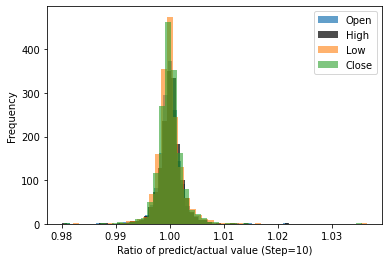

In [ ]:
step=10
plt.hist(pre_ohlc[step, :, 0]/ans_ohlc[step, :, 0], bins=50, alpha=0.7)
plt.hist(pre_ohlc[step, :, 1]/ans_ohlc[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(pre_ohlc[step, :, 2]/ans_ohlc[step, :, 2], bins=50, alpha=0.6)
plt.hist(pre_ohlc[step, :, 3]/ans_ohlc[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [ ]:
print("==============Mean============")
print("Open", np.mean(pre_ohlc[:, :, 0]/ans_ohlc[:, :, 0], axis=1))
print("High", np.mean(pre_ohlc[:, :, 1]/ans_ohlc[:, :, 1], axis=1))
print("Low", np.mean(pre_ohlc[:, :, 2]/ans_ohlc[:, :, 2], axis=1))
print("Close", np.mean(pre_ohlc[:, :, 3]/ans_ohlc[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(pre_ohlc[:, :, 0]/ans_ohlc[:, :, 0], axis=1))
print("High", np.var(pre_ohlc[:, :, 1]/ans_ohlc[:, :, 1], axis=1))
print("Low", np.var(pre_ohlc[:, :, 2]/ans_ohlc[:, :, 2], axis=1))
print("Close", np.var(pre_ohlc[:, :, 3]/ans_ohlc[:, :, 3], axis=1))

==============Mean============
Open [1.      1.      0.99999 0.99999 1.00002 1.00005 1.00006 1.00003 1.00003
 1.00004 1.00002]
High [1.      0.99998 1.      1.00001 1.00005 1.00008 1.00005 1.00005 1.00006
 1.00006 1.00005]
Low [1.      0.99998 0.99997 0.99999 1.      1.00005 1.00002 0.99998 1.00001
 1.      0.99997]
Close [1.      0.99999 0.99999 1.00001 1.00005 1.00006 1.00004 1.00003 1.00004
 1.00002 1.00001]
==============Var============
Open [0.00000e+00 4.22454e-08 4.75920e-07 1.09501e-06 1.58715e-06 2.03401e-06
 2.60272e-06 3.25623e-06 3.77373e-06 4.53652e-06 4.90568e-06]
High [0.00000e+00 4.03120e-07 7.24415e-07 1.38911e-06 1.81607e-06 2.27055e-06
 2.85817e-06 3.47199e-06 3.87085e-06 4.60337e-06 4.94231e-06]
Low [0.00000e+00 2.79448e-07 9.07413e-07 1.49096e-06 2.00723e-06 2.63863e-06
 3.12267e-06 3.69141e-06 4.76217e-06 5.15769e-06 6.06633e-06]
Close [0.00000e+00 4.70306e-07 1.09184e-06 1.57990e-06 2.01238e-06 2.59901e-06
 3.17851e-06 3.76647e-06 4.50434e-06 4.88804e-06 5.81747e

[]

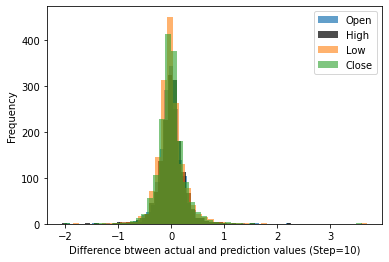

In [ ]:
step=10
plt.hist(pre_ohlc[step, :, 0] - ans_ohlc[step, :, 0], bins=50, alpha=0.7)
plt.hist(pre_ohlc[step, :, 1] - ans_ohlc[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(pre_ohlc[step, :, 2] - ans_ohlc[step, :, 2], bins=50, alpha=0.6)
plt.hist(pre_ohlc[step, :, 3] - ans_ohlc[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [ ]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(pre_ohlc[:, :, 0]-ans_ohlc[:, :, 0], axis=1))
print("High", np.mean(pre_ohlc[:, :, 1]-ans_ohlc[:, :, 1], axis=1))
print("Low", np.mean(pre_ohlc[:, :, 2]-ans_ohlc[:, :, 2], axis=1))
print("Close", np.mean(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(pre_ohlc[:, :, 0]-ans_ohlc[:, :, 0], axis=1))
print("High", np.var(pre_ohlc[:, :, 1]-ans_ohlc[:, :, 1], axis=1))
print("Low", np.var(pre_ohlc[:, :, 2]-ans_ohlc[:, :, 2], axis=1))
print("Close", np.var(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.00038 -0.00132 -0.00175  0.00159  0.00544  0.00623  0.0033
  0.00287  0.00458  0.00275]
High [ 0.00000e+00 -2.22710e-03  2.97031e-05  6.83168e-04  5.60396e-03
  8.23391e-03  5.08106e-03  5.20978e-03  6.29394e-03  6.12686e-03
  5.56374e-03]
Low [ 0.00000e+00 -1.58663e-03 -3.31621e-03 -9.52351e-04  1.07674e-04
  5.67636e-03  2.90347e-03 -1.80507e-03  1.16151e-03  9.46787e-05
 -2.83911e-03]
Close [ 0.      -0.00103 -0.00154  0.00139  0.00512  0.00646  0.00474  0.00311
  0.0042   0.00269  0.00101]
==============Var============
Open [0.      0.00053 0.00625 0.0141  0.02018 0.02595 0.0332  0.04148 0.0478
 0.05722 0.06219]
High [0.      0.00509 0.00946 0.01751 0.02301 0.02879 0.03637 0.04399 0.04906
 0.05829 0.06296]
Low [0.      0.00359 0.01172 0.01923 0.02553 0.03371 0.03994 0.04713 0.05973
 0.06515 0.07578]
Close [0.      0.00618 0.01406 0.02007 0.02567 0.03316 0.04055 0.04771 0.05685
 0.062   0.07286]


In [ ]:
val_inp, val_ans = ds[index:index+batch_size]
        
next_pre_ohlc, next_pre_volume, next_pre_spread = batch_prediction(*val_inp, indices)

### Basic Model with Daily Position

In [ ]:
org_index = df.index
hours_of_day = (df.index.hour + df.index.minute/60)*2
hours_of_day = hours_of_day.to_frame()
hours_of_day = hours_of_day.convert_dtypes(int)
hours_of_day.index = org_index

In [ ]:
new_df = pd.concat([df, hours_of_day], axis=1)
new_df

,open,high,low,close,tick_volume,spread,real_volume,time
time,,,,,,,,
2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0,17
2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0,18
2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0,19
2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0,20
2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0,21
...,...,...,...,...,...,...,...,...
2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0,43
2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0,44
2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0,45


In [ ]:
import random
import numpy as np
import torch


class CloseDiffIDTDS:
    
    def __init__(self, df, ohlc_columns, volume_column=None, spread_column=None, mins=30,
                 observation_length=60, device="cuda", future_step_size=1, seed=1017, is_training = True):
        self.seed(seed)
        self.columns = ohlc_columns
        self.ohlc_idf = self.__init_ohlc(df, ohlc_columns)        
        if volume_column is not None:
            self.volume_idf = self.__init_volume(df[volume_column])
            self.columns.append(volume_column)
            self.__get_volume = lambda idx: self.volume_idf.iloc[idx].values.tolist()
        if spread_column is not None:
            self.spread_idf = self.__init_spread(df[spread_column])
            self.columns.append(spread_column)
            self.__get_spread = lambda idx: self.spread_idf.iloc[idx].values.tolist()
        hours_of_week = (df.index.weekday*24 + df.index.hour + df.index.minute/60)*(60/30)
        self.hours_of_week = hours_of_week.to_frame().iloc[1:].convert_dtypes(int)

        self.__get_timeindex = lambda idx: self.hours_of_week.iloc[idx].values.tolist()
        
        self.observation_length = observation_length
        self.device = device
        self.future_step_size = future_step_size
        self.is_training = is_training
        self.__init_indicies(self.ohlc_idf)
    
    def revert_diff(self, prediction, ndx, last_close_value=None):
        if last_close_value is None:
            if type(ndx) is int:
                target_index = self._indices[ndx] + self.observation_length - 1
                #close.iloc[index - 1] + ohlc.iloc[index]. As index=0 was dropped, index of dataset equal index + 1 of original data
                last_close = df[self.columns[3]].iloc[target_index]
            else:
                target_index = [self._indices[index] + self.observation_length - 1 for index in ndx]
                batch_size = len(ndx)
                last_close = df[self.columns[3]].iloc[target_index].values.reshape(batch_size, 1)
            revert_ohlc = last_close + prediction[0:1]
            last_close = revert_ohlc[:, :, 3:]
            for index in range(1, len(prediction)):
                step_ohlc = last_close + prediction[index:index+1]
                last_close = step_ohlc[:, :, 3:]
                revert_ohlc = np.concatenate([revert_ohlc, step_ohlc], axis=0)
            return revert_ohlc            
        else:
            return last_close_value + prediction
    
    def revert(self, diff):
        pass
    
    def __init_ohlc(self, df, ohlc_columns, decimal_digits = 3):
        close_column = [ohlc_columns[3]]
        ohlc_cls_diff_df = df[ohlc_column].iloc[1:] - df[close_column].iloc[:-1].values
        min_value = ohlc_cls_diff_df.min().min()
        min_value_abs = abs(min_value)

        lower_value = math.ceil(min_value_abs) * 10 ** decimal_digits
        upper_value = math.ceil(ohlc_cls_diff_df.max().max()) * 10 ** decimal_digits
        id_df =  ohlc_cls_diff_df * 10 ** decimal_digits + lower_value
        self.ohlc_lower = lower_value
        id_df = id_df.astype('int64')
        self.ohlc_range_size = lower_value + upper_value
        return id_df
    
    def __get_volume(self, idx):
        return []
    
    def __get_spread(self, idx):
        return []
    
    def __init_volume(self, df):
        volume_df = df.iloc[1:].round(decimals=-1)/10
        volume_df.dropna(inplace=True)
        self.volume_range_size = math.ceil(volume_df.max()/100)*100
        volume_df = volume_df.astype(dtype='int64')
        return volume_df
    
    def __init_spread(self, df):
        spread_df = df.iloc[1:]
        spread_df = spread_df.astype('int64')
        self.spread_range_size = spread_df.max()*2
        return spread_df
    
    def __get_data_set(self, idx):
        ohlc_ids = self.ohlc_idf.iloc[idx].values.tolist()
        volume_ids = self.__get_volume(idx)
        spread_ids = self.__get_spread(idx)
        timestamp_ids = self.__get_timeindex(idx)
        return ohlc_ids, volume_ids, spread_ids, timestamp_ids
    
    def _output_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index + self.observation_length -1, index + self.observation_length + self.future_step_size)
            ohlc_ids, volume_ids, spread_ids, timestamp_ids = self.__get_data_set(idx)
            
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            timestamp_ids = torch.tensor(timestamp_ids, device=self.device, dtype=torch.int)
            
            return ohlc_ids, volume_ids, spread_ids, timestamp_ids
        elif type(batch_size) == slice:    
            ohlc_chunk_data = []
            volume_chunk_data = []
            spread_chunk_data = []
            timestamp_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index + self.observation_length -1, index + self.observation_length + self.future_step_size)
                ohlc_ids, volume_ids, spread_ids, timestamp_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                volume_chunk_data.append(volume_ids)
                spread_chunk_data.append(spread_ids)
                timestamp_data.append(timestamp_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            timestamp_ids = torch.tensor(timestamp_data, device=self.device, dtype=torch.int)
            
            return ohlc_ids.transpose(0, 1), volume_ids.transpose(0, 1), spread_ids.transpose(0, 1), timestamp_ids.transpose(0, 1)
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index, index + self.observation_length)
            ohlc_ids, volume_ids, spread_ids, timestamp_ids = self.__get_data_set(idx)
            
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            timestamp_ids = torch.tensor(timestamp_ids, device=self.device, dtype=torch.int)
            
            return ohlc_ids, volume_ids, spread_ids, timestamp_ids
        elif type(batch_size) == slice:
            ohlc_chunk_data = []
            volume_chunk_data = []
            spread_chunk_data = []
            timestamp_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index, index + self.observation_length)
                ohlc_ids, volume_ids, spread_ids, timestamp_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                volume_chunk_data.append(volume_ids)
                spread_chunk_data.append(spread_ids)
                timestamp_data.append(timestamp_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            timestamp_ids = torch.tensor(timestamp_data, device=self.device, dtype=torch.int)
            
            return ohlc_ids.transpose(0, 1), volume_ids.transpose(0, 1), spread_ids.transpose(0, 1), timestamp_ids.transpose(0, 1)
    
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def seed(self, seed=None):
        '''
        '''
        if seed is None:
            seed = 1192
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed
        
    def __init_indicies(self, data, split_ratio=0.7):
        length = len(data) - self.observation_length - self.future_step_size
        if length < 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")
        

        
        from_index = 1#avoid diff nan
        to_index = int(length*split_ratio)
        self.train_indices = random.sample(range(from_index, to_index), k=to_index - from_index)
        
        from_index = int(length*split_ratio)+self.observation_length + self.future_step_size
        to_index = length
        self.val_indices = random.sample(range(from_index, to_index), k=to_index - from_index)
        
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.val_indices
            
    def eval(self):
        self._indices = self.val_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = True

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(time_size, d_model, )

    def forward(self,time_ids):
        position = self.pe(time_ids)
        return position

In [15]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int, volume_size:int, spread_size:int, time_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        d_model = d_model + 6 - (d_model % 6)
        emb_d_model = int(d_model/6)
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim = emb_d_model)
        self.volume_embedded_layer = torch.nn.Embedding(num_embeddings=volume_size, embedding_dim = emb_d_model)
        self.spread_embedded_layer = torch.nn.Embedding(num_embeddings=spread_size, embedding_dim = emb_d_model)
        
        self.ohlc_positional_encoding = PositionalEncoding(time_size, emb_d_model)
        self.volume_positional_encoding = PositionalEncoding(time_size, emb_d_model)
        self.spread_positional_encoding = PositionalEncoding(time_size, emb_d_model)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.output_layer = nn.Linear(d_model, 6)
        

    def forward(
        self, src_ohlc: Tensor, src_volume: Tensor, src_spread: Tensor, src_time: Tensor,
        tgt_ohlc: Tensor, tgt_volume: Tensor, tgt_spread: Tensor, tgt_time: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        ohlc_pos = self.ohlc_positional_encoding(src_time)
        src_ohlc = self.ohlc_embedded_layer(src_ohlc)
        src_ohlc = src_ohlc + ohlc_pos
        
        volume_pos = self.volume_positional_encoding(src_time)
        src_volume = self.volume_embedded_layer(src_volume)
        src_volume = src_volume + volume_pos
        
        spread_pos = self.spread_positional_encoding(src_time)
        src_spread = self.spread_embedded_layer(src_spread)
        src_spread = src_spread + spread_pos
        
        src = torch.concat([src_ohlc, src_volume, src_spread], dim=2)
        src = src.reshape(src.size(0), src.size(1), src.size(2)*src.size(3))
        del src_ohlc, src_volume, src_spread
        
        tgt_ohlc_pos = self.ohlc_positional_encoding(tgt_time)
        tgt_ohlc = self.ohlc_embedded_layer(tgt_ohlc)
        tgt_ohlc = tgt_ohlc + tgt_ohlc_pos
        
        tgt_v_pos = self.volume_positional_encoding(tgt_time)
        tgt_volume = self.volume_embedded_layer(tgt_volume)
        tgt_volume = tgt_volume + tgt_v_pos
        
        tgt_sp_pos = self.spread_positional_encoding(tgt_time)
        tgt_spread = self.spread_embedded_layer(tgt_spread)
        tgt_spread = tgt_spread + tgt_sp_pos
        
        tgt = torch.concat([tgt_ohlc, tgt_volume, tgt_spread], dim=2)
        tgt = tgt.reshape(tgt.size(0), tgt.size(1), tgt.size(2)*tgt.size(3))
        del tgt_ohlc, tgt_volume, tgt_spread
        
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        output = self.output_layer(outs)
        
        return output

In [16]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int, volume_size:int, spread_size:int, time_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        d_model = d_model + 6 - (d_model % 6)
        emb_d_model = int(d_model/6)

        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim = emb_d_model)
        self.volume_embedded_layer = torch.nn.Embedding(num_embeddings=volume_size, embedding_dim = emb_d_model)
        self.spread_embedded_layer = torch.nn.Embedding(num_embeddings=spread_size, embedding_dim = emb_d_model)
        
        self.ohlc_positional_encoding = PositionalEncoding(time_size, emb_d_model)
        self.volume_positional_encoding = PositionalEncoding(time_size, emb_d_model)
        self.spread_positional_encoding = PositionalEncoding(time_size, emb_d_model)
        self.ohlc_dropaut_layer = nn.Dropout(dropout)
        self.volume_dropaut_layer = nn.Dropout(dropout)
        self.spread_dropaut_layer = nn.Dropout(dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.output_layer = nn.Linear(d_model, 6)
        

    def forward(
        self, src_ohlc: Tensor, src_volume: Tensor, src_spread: Tensor, src_time: Tensor,
        tgt_ohlc: Tensor, tgt_volume: Tensor, tgt_spread: Tensor, tgt_time: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        ohlc_pos = self.ohlc_positional_encoding(src_time)
        src_ohlc = self.ohlc_embedded_layer(src_ohlc)
        src_ohlc = src_ohlc + ohlc_pos
        src_ohlc = self.ohlc_dropaut_layer(src_ohlc)
        
        volume_pos = self.volume_positional_encoding(src_time)
        src_volume = self.volume_embedded_layer(src_volume)
        src_volume = src_volume + volume_pos
        src_volume = self.volume_dropaut_layer(src_volume)
        
        spread_pos = self.spread_positional_encoding(src_time)
        src_spread = self.spread_embedded_layer(src_spread)
        src_spread = src_spread + spread_pos
        src_spread = self.spread_dropaut_layer(src_spread)
        
        src = torch.concat([src_ohlc, src_volume, src_spread], dim=2)
        src = src.reshape(src.size(0), src.size(1), src.size(2)*src.size(3))
        del src_ohlc, src_volume, src_spread
        
        tgt_ohlc_pos = self.ohlc_positional_encoding(tgt_time)
        tgt_ohlc = self.ohlc_embedded_layer(tgt_ohlc)
        tgt_ohlc = tgt_ohlc + tgt_ohlc_pos
        tgt_ohlc = self.ohlc_dropaut_layer(tgt_ohlc)
        
        tgt_v_pos = self.volume_positional_encoding(tgt_time)
        tgt_volume = self.volume_embedded_layer(tgt_volume)
        tgt_volume = tgt_volume + tgt_v_pos
        tgt_volume = self.volume_dropaut_layer(tgt_volume)
        
        tgt_sp_pos = self.spread_positional_encoding(tgt_time)
        tgt_spread = self.spread_embedded_layer(tgt_spread)
        tgt_spread = tgt_spread + tgt_sp_pos
        tgt_spread = self.spread_dropaut_layer(tgt_spread)
        
        tgt = torch.concat([tgt_ohlc, tgt_volume, tgt_spread], dim=2)
        tgt = tgt.reshape(tgt.size(0), tgt.size(1), tgt.size(2)*tgt.size(3))
        del tgt_ohlc, tgt_volume, tgt_spread
        
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        output = self.output_layer(outs)
        
        return output

In [17]:
def train(model, ds, optimizer, criterion, batch_size):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, spread_src, time_src= src
        ohlc_tgt, volume_tgt, spread_tgt, time_tgt = tgt
        del src, tgt
        
        in_ohlc_tgt, in_volume_tgt, in_spread_tgt, in_time_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :], spread_tgt[:-1, :], time_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits = model(
            src_ohlc=ohlc_src, src_volume=volume_src, src_spread=spread_src, src_time = time_src,
            tgt_ohlc=in_ohlc_tgt, tgt_volume=in_volume_tgt, tgt_spread=in_spread_tgt, tgt_time = in_time_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        del in_ohlc_tgt, in_volume_tgt, in_spread_tgt
        del ohlc_src, volume_src, spread_src

        out_ohlc_tgt, out_v_tgt, out_s_tgt = ohlc_tgt[1:, :], volume_tgt[1:, :], spread_tgt[1:, :]
        out_ohlc_tgt = out_ohlc_tgt.to(dtype=torch.float)/ohlc_range_size
        out_v_tgt = out_v_tgt.to(dtype=torch.float)/volume_range_size
        out_s_tgt = out_s_tgt.to(dtype=torch.float)/spread_range_size
        
        out_tgt = torch.concat([out_ohlc_tgt, out_v_tgt, out_s_tgt], dim=2)
        
        optimizer.zero_grad()
        
        loss = criterion(logits, out_tgt)
        
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [18]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, spread_src, time_src= src
        ohlc_tgt, volume_tgt, spread_tgt, time_tgt = tgt
        del src, tgt
        
        in_ohlc_tgt, in_volume_tgt, in_spread_tgt, in_time_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :], spread_tgt[:-1, :], time_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits = model(
            src_ohlc=ohlc_src, src_volume=volume_src, src_spread=spread_src, src_time = time_src,
            tgt_ohlc=in_ohlc_tgt, tgt_volume=in_volume_tgt, tgt_spread=in_spread_tgt, tgt_time = in_time_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        del in_ohlc_tgt, in_volume_tgt, in_spread_tgt
        del ohlc_src, volume_src, spread_src

        out_ohlc_tgt, out_v_tgt, out_s_tgt = ohlc_tgt[1:, :], volume_tgt[1:, :], spread_tgt[1:, :]
        out_ohlc_tgt = out_ohlc_tgt.to(dtype=torch.float)/ohlc_range_size
        out_v_tgt = out_v_tgt.to(dtype=torch.float)/volume_range_size
        out_s_tgt = out_s_tgt.to(dtype=torch.float)/spread_range_size
        out_tgt = torch.concat([out_ohlc_tgt, out_v_tgt, out_s_tgt], dim=2)        
        
        loss = criterion(logits, out_tgt)
        losses += loss.item()
        
    return losses / length

#### Training

In [ ]:
ds = CloseDiffIDTDS(df, ["open", "high", "low", "close"], "tick_volume", spread_column="spread", mins=30,
               observation_length=60, device="cuda", future_step_size=10, seed=1017, is_training = True)

In [ ]:
device = "cuda"
nhead = 4
d_model = 512
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
feature_size = 6
dropout = 0.01

ohlc_range_size = ds.ohlc_range_size
volume_range_size = ds.volume_range_size
spread_range_size = ds.spread_range_size

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    ohlc_size=ds.ohlc_range_size, volume_size=ds.volume_range_size, spread_size=ds.spread_range_size,
    time_size=48,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.0001
batch_size = 16

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
epoch = 500
best_loss = float('Inf')
#best_loss = 0.0000743550
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|█████████▉| 4403/4404 [05:58<00:00, 12.28it/s]


[1/500] train loss: 0.0149510787, valid loss: 0.0007320035  59s] count: 0, **


100%|█████████▉| 4403/4404 [05:50<00:00, 12.57it/s]


[2/500] train loss: 0.0007216968, valid loss: 0.0003748869  50s] count: 0, **


 69%|██████▉   | 3055/4404 [04:01<01:46, 12.64it/s]


KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load('./finance_DID_P_transfomer_v1.torch'))

<All keys matched successfully>

#### Validation

In [ ]:
def revert_target(tgt_ohlc, tgt_volume, tgt_spread, indices):
    if tgt_ohlc.size(1) != len(indices):
        raise Exception("batch_size should be same as indices size")
    batch_size = len(indices)
    #revet id to difference: ohlc - last close
    ohlc_diff = (tgt_ohlc - ds.ohlc_lower) * 0.1 ** 3
    ohlc_diff = ohlc_diff.cpu().detach().numpy()
    first_ohlc = ds.revert_diff(ohlc_diff[0, :, :], indices)
    last_close = first_ohlc[:, -1:]
    revert_ohlc = first_ohlc.reshape(1, batch_size, 4)
    
    # last_observation + future_step_size
    for i in range(1, tgt_ohlc.size(0)):
        next_ohlc = ohlc_diff[i, :, :] + last_close
        last_close = next_ohlc[:, -1:]
        revert_ohlc = np.concatenate([revert_ohlc, next_ohlc.reshape(1, batch_size, 4)], axis=0)
    
    revert_volume = tgt_volume * 10
    revert_volume = revert_volume.cpu().detach().numpy()
    revert_spread = tgt_spread.cpu().detach().numpy()
    
    return revert_ohlc, revert_volume, revert_spread

In [ ]:
def batch_prediction(src_ohlc, src_volume, src_spread, src_time, indices):
    
    if src_ohlc.size(1) != len(indices):
        raise Exception("batch_size should be same as indices size")
    
    preds_ohlc = src_ohlc[-1:, :, :]
    preds_volume = src_volume[-1:, :, :]
    preds_spread = src_spread[-1:, :, :]
    entire_tgt_time = (src_time[-11:, :, :] + 10) % 48
    preds_tgt_time = entire_tgt_time[-1:, :, :]
    for i in range(0, 10):
        mask_tgt = nn.Transformer.generate_square_subsequent_mask(preds_ohlc.size(0)).to(device)
        

        logits = model(
            src_ohlc=src_ohlc, src_volume=src_volume, src_spread=src_spread, src_time = src_time,
            tgt_ohlc=preds_ohlc, tgt_volume=preds_volume, tgt_spread=preds_spread,tgt_time = preds_tgt_time,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        
        #as model predicts id/range, revert it for next input
        next_preds_ohlc = (logits[-1:, :, :4] *  ohlc_range_size).to(dtype=torch.int)
        next_preds_volume = (logits[-1:, :, 4:5] * volume_range_size).to(dtype=torch.int)
        next_preds_spread = (logits[-1:, :, 5:] * spread_range_size).to(dtype=torch.int)
        
        preds_ohlc = torch.concat([preds_ohlc, next_preds_ohlc])
        preds_volume = torch.concat([preds_volume, next_preds_volume])
        preds_spread = torch.concat([preds_spread, next_preds_spread])
        preds_tgt_time = entire_tgt_time[:i+2]
    return revert_target(preds_ohlc, preds_volume, preds_spread, indices)


In [ ]:
src, tgt = ds[0:16]

In [ ]:
ans_ohlc, ans_volume, ans_spread = batch_prediction(*src, [i for i in range(0, 16)])

In [ ]:
batch_index = 0
sample_answer = ans_ohlc[:, batch_index, :]

In [ ]:
sample_answer

array([[108.531     , 108.638     , 108.525     , 108.62400001],
       [108.62300001, 108.71100001, 108.607     , 108.68200001],
       [108.68100001, 108.71000001, 108.64100001, 108.67900001],
       [108.67800001, 108.70200001, 108.582     , 108.66000001],
       [108.66100001, 108.67700001, 108.62100001, 108.64500001],
       [108.64600001, 108.65800001, 108.60800001, 108.63200001],
       [108.63000001, 108.66100001, 108.605     , 108.64300001],
       [108.64400001, 108.75400002, 108.622     , 108.74500001],
       [108.74400001, 108.81000002, 108.70300001, 108.77400001],
       [108.77300001, 108.82200001, 108.75800001, 108.79200001],
       [108.78900001, 108.81400002, 108.70200001, 108.72300001]])

In [ ]:
# answe[0] has last observation value, so observation length is 60 - 1
observation_length = 59
diff_padding_index = 1

actual_index = ds._indices[0]
start_index = actual_index+observation_length+diff_padding_index
end_index = start_index + 11
df.iloc[start_index:end_index]

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2021-03-24 10:00:00,108.532,108.638,108.525,108.625,2276,2,0
2021-03-24 10:30:00,108.625,108.654,108.586,108.601,2369,2,0
2021-03-24 11:00:00,108.601,108.652,108.575,108.652,2425,2,0
2021-03-24 11:30:00,108.651,108.716,108.628,108.635,3412,2,0
2021-03-24 12:00:00,108.634,108.703,108.617,108.678,2100,3,0
2021-03-24 12:30:00,108.678,108.686,108.628,108.635,2153,3,0
2021-03-24 13:00:00,108.634,108.755,108.625,108.743,2544,3,0
2021-03-24 13:30:00,108.743,108.748,108.699,108.731,1362,3,0
2021-03-24 14:00:00,108.731,108.731,108.666,108.679,1482,3,0


In [ ]:
import time
ds.eval()
batch_size = 16
ans_ohlc, ans_volume, ans_spread = None, None, None
pre_ohlc, pre_volume, pre_spread = None, None, None

for index in range(0, len(ds), batch_size):
    if len(ds) - index < batch_size:
        break
    indices = [index for index in range(index, index+batch_size)]
    val_inp, val_ans = ds[index:index+batch_size]
        
    next_pre_ohlc, next_pre_volume, next_pre_spread = batch_prediction(*val_inp, indices)
    torch.cuda.empty_cache()
    
    if pre_ohlc is None:
        pre_ohlc = next_pre_ohlc
        pre_volume = next_pre_volume
        pre_spread = next_pre_spread
    else:
        pre_ohlc = np.concatenate([pre_ohlc, next_pre_ohlc], axis=1)
        pre_volume = np.concatenate([pre_volume, next_pre_volume], axis=1)
        pre_spread = np.concatenate([pre_spread, next_pre_spread], axis=1)
    
    del next_pre_ohlc, next_pre_volume, next_pre_spread
    
    next_ans_ohlc, next_ans_volume, next_ans_spread = revert_target(*val_ans[:3], indices)
    torch.cuda.empty_cache()
    
    if ans_ohlc is None:
        ans_ohlc = next_ans_ohlc
        ans_volume = next_ans_volume
        ans_spread = next_ans_spread
    else:
        ans_ohlc = np.concatenate([ans_ohlc, next_ans_ohlc], axis=1)
        ans_volume = np.concatenate([ans_volume, next_ans_volume], axis=1)
        ans_spread = np.concatenate([ans_spread, next_ans_spread], axis=1)
    
    del next_ans_ohlc, next_ans_volume, next_ans_spread
    torch.cuda.empty_cache()
    
    time.sleep(40)

In [ ]:
index

1904

In [ ]:
pre_ohlc.shape

(11, 1904, 4)

#### Plot Results

[]

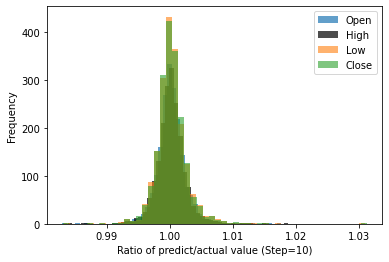

In [ ]:
step=10
plt.hist(pre_ohlc[step, :, 0]/ans_ohlc[step, :, 0], bins=50, alpha=0.7)
plt.hist(pre_ohlc[step, :, 1]/ans_ohlc[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(pre_ohlc[step, :, 2]/ans_ohlc[step, :, 2], bins=50, alpha=0.6)
plt.hist(pre_ohlc[step, :, 3]/ans_ohlc[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [ ]:
print("==============Mean============")
print("Open", np.mean(pre_ohlc[:, :, 0]/ans_ohlc[:, :, 0], axis=1))
print("High", np.mean(pre_ohlc[:, :, 1]/ans_ohlc[:, :, 1], axis=1))
print("Low", np.mean(pre_ohlc[:, :, 2]/ans_ohlc[:, :, 2], axis=1))
print("Close", np.mean(pre_ohlc[:, :, 3]/ans_ohlc[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(pre_ohlc[:, :, 0]/ans_ohlc[:, :, 0], axis=1))
print("High", np.var(pre_ohlc[:, :, 1]/ans_ohlc[:, :, 1], axis=1))
print("Low", np.var(pre_ohlc[:, :, 2]/ans_ohlc[:, :, 2], axis=1))
print("Close", np.var(pre_ohlc[:, :, 3]/ans_ohlc[:, :, 3], axis=1))

==============Mean============
Open [1.         0.99999335 0.99999356 1.0000342  1.00010342 1.00017344
 1.00020329 1.00021477 1.00023363 1.00026104 1.00027573]
High [1.         0.9999498  0.99994414 0.99998249 1.00005129 1.00010408
 1.00010036 1.00012689 1.0001474  1.00017902 1.0002004 ]
Low [1.         1.00002781 1.00006986 1.00015033 1.00020406 1.00029068
 1.00029098 1.00029083 1.0003386  1.00035267 1.00036207]
Close [1.         0.99999896 1.0000384  1.00010426 1.00017235 1.0002064
 1.0002286  1.00023801 1.00026009 1.00027716 1.00029719]
==============Var============
Open [0.00000000e+00 3.90733362e-08 4.42262250e-07 1.08655629e-06
 1.69042556e-06 2.24654115e-06 2.96873772e-06 3.68382498e-06
 4.19317171e-06 5.04386279e-06 5.45836998e-06]
High [0.00000000e+00 2.69670321e-07 7.48515266e-07 1.36702857e-06
 1.89807229e-06 2.56085340e-06 3.22214123e-06 3.84569148e-06
 4.44139063e-06 5.13606975e-06 5.48882170e-06]
Low [0.00000000e+00 2.61342136e-07 8.85129303e-07 1.53686772e-06
 2.15933448

[]

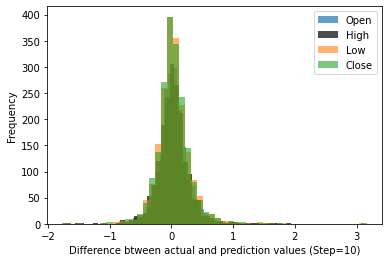

In [ ]:
step=10
plt.hist(pre_ohlc[step, :, 0] - ans_ohlc[step, :, 0], bins=50, alpha=0.7)
plt.hist(pre_ohlc[step, :, 1] - ans_ohlc[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(pre_ohlc[step, :, 2] - ans_ohlc[step, :, 2], bins=50, alpha=0.6)
plt.hist(pre_ohlc[step, :, 3] - ans_ohlc[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [ ]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(pre_ohlc[:, :, 0]-ans_ohlc[:, :, 0], axis=1))
print("High", np.mean(pre_ohlc[:, :, 1]-ans_ohlc[:, :, 1], axis=1))
print("Low", np.mean(pre_ohlc[:, :, 2]-ans_ohlc[:, :, 2], axis=1))
print("Close", np.mean(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(pre_ohlc[:, :, 0]-ans_ohlc[:, :, 0], axis=1))
print("High", np.var(pre_ohlc[:, :, 1]-ans_ohlc[:, :, 1], axis=1))
print("Low", np.var(pre_ohlc[:, :, 2]-ans_ohlc[:, :, 2], axis=1))
print("Close", np.var(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.00072 -0.00095  0.00362  0.01148  0.0193   0.02292  0.02428
  0.02654  0.02978  0.03138]
High [ 0.      -0.00583 -0.00653 -0.00227  0.00568  0.01166  0.01133  0.01433
  0.01685  0.02052  0.02275]
Low [0.      0.00312 0.00766 0.01673 0.02278 0.03263 0.03284 0.03282 0.03845
 0.04015 0.04094]
Close [ 0.      -0.00034  0.00408  0.01155  0.01919  0.02327  0.02583  0.02705
  0.02968  0.03153  0.03351]
==============Var============
Open [0.      0.0005  0.00572 0.01381 0.02143 0.0286  0.03766 0.04673 0.05287
 0.06415 0.06957]
High [0.      0.00351 0.0095  0.0172  0.0241  0.03234 0.04079 0.04845 0.05644
 0.06555 0.07022]
Low [0.      0.00334 0.01126 0.01961 0.02739 0.0358  0.04473 0.05269 0.06326
 0.07062 0.07903]
Close [0.      0.00563 0.01376 0.02123 0.02828 0.0376  0.04582 0.05281 0.06383
 0.06938 0.07824]


### Basic Model with weekly position

In [ ]:
org_index = df.index

hours_of_day = (df.index.weekday*24 + df.index.hour + df.index.minute/60)*2
hours_of_day = hours_of_day.to_frame()
hours_of_day = hours_of_day.convert_dtypes(int)
hours_of_day.index = org_index

In [6]:
import random
import numpy as np
import torch


class CloseDiffIDTDS:
    
    def __init__(self, df, ohlc_columns, volume_column=None, spread_column=None, mins=30,
                 observation_length=60, device="cuda", future_step_size=1, seed=1017, is_training = True):
        self.seed(seed)
        self.columns = ohlc_columns
        self.ohlc_idf = self.__init_ohlc(df, ohlc_columns)
        if volume_column is not None:
            self.volume_idf = self.__init_volume(df[volume_column])
            self.columns.append(volume_column)
            self.__get_volume = lambda idx: self.volume_idf.iloc[idx].values.tolist()
        if spread_column is not None:
            self.spread_idf = self.__init_spread(df[spread_column])
            self.columns.append(spread_column)
            self.__get_spread = lambda idx: self.spread_idf.iloc[idx].values.tolist()
        hours_of_week = (df.index.weekday*24 + df.index.hour + df.index.minute/60)*(60/30)
        self.hours_of_week = hours_of_week.to_frame().iloc[1:].convert_dtypes(int)

        self.__get_timeindex = lambda idx: self.hours_of_week.iloc[idx].values.tolist()
        
        self.observation_length = observation_length
        self.device = device
        self.future_step_size = future_step_size
        self.is_training = is_training
        self.__init_indicies(self.ohlc_idf)
            
    def revert_diff(self, prediction, ndx, last_close_value=None):
        if last_close_value is None:
            if type(ndx) is int:
                target_index = self._indices[ndx] + self.observation_length - 1
                #close.iloc[index - 1] + ohlc.iloc[index]. As index=0 was dropped, index of dataset equal index + 1 of original data
                last_close = df[self.columns[3]].iloc[target_index]
            else:
                target_index = [self._indices[index] + self.observation_length - 1 for index in ndx]
                batch_size = len(ndx)
                last_close = df[self.columns[3]].iloc[target_index].values.reshape(batch_size, 1)
            revert_ohlc = last_close + prediction[0:1]
            last_close = revert_ohlc[:, :, 3:]
            for index in range(1, len(prediction)):
                step_ohlc = last_close + prediction[index:index+1]
                last_close = step_ohlc[:, :, 3:]
                revert_ohlc = np.concatenate([revert_ohlc, step_ohlc], axis=0)
            return revert_ohlc            
        else:
            return last_close_value + prediction
    
    def revert(self, diff):
        pass
    
    def __init_ohlc(self, df, ohlc_columns, decimal_digits = 3):
        close_column = [ohlc_columns[3]]
        ohlc_cls_diff_df = df[ohlc_column].iloc[1:] - df[close_column].iloc[:-1].values
        min_value = ohlc_cls_diff_df.min().min()
        min_value_abs = abs(min_value)

        lower_value = math.ceil(min_value_abs) * 10 ** decimal_digits
        upper_value = math.ceil(ohlc_cls_diff_df.max().max()) * 10 ** decimal_digits
        id_df =  ohlc_cls_diff_df * 10 ** decimal_digits + lower_value
        self.ohlc_lower = lower_value
        id_df = id_df.astype('int64')
        self.ohlc_range_size = lower_value + upper_value
        return id_df
    
    def __get_volume(self, idx):
        return []
    
    def __get_spread(self, idx):
        return []
    
    def __init_volume(self, df):
        volume_df = df.iloc[1:].round(decimals=-1)/10
        volume_df.dropna(inplace=True)
        self.volume_range_size = math.ceil(volume_df.max()/100)*100
        volume_df = volume_df.astype(dtype='int64')
        return volume_df
    
    def __init_spread(self, df):
        spread_df = df.iloc[1:]
        spread_df = spread_df.astype('int64')
        self.spread_range_size = spread_df.max()*2
        return spread_df
    
    def __get_data_set(self, idx):
        ohlc_ids = self.ohlc_idf.iloc[idx].values.tolist()
        volume_ids = self.__get_volume(idx)
        spread_ids = self.__get_spread(idx)
        timestamp_ids = self.__get_timeindex(idx)
        return ohlc_ids, volume_ids, spread_ids, timestamp_ids
    
    def _output_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index + self.observation_length -1, index + self.observation_length + self.future_step_size)
            ohlc_ids, volume_ids, spread_ids, timestamp_ids = self.__get_data_set(idx)
            
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            timestamp_ids = torch.tensor(timestamp_ids, device=self.device, dtype=torch.int)
            
            return ohlc_ids, volume_ids, spread_ids, timestamp_ids
        elif type(batch_size) == slice:    
            ohlc_chunk_data = []
            volume_chunk_data = []
            spread_chunk_data = []
            timestamp_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index + self.observation_length -1, index + self.observation_length + self.future_step_size)
                ohlc_ids, volume_ids, spread_ids, timestamp_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                volume_chunk_data.append(volume_ids)
                spread_chunk_data.append(spread_ids)
                timestamp_data.append(timestamp_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            timestamp_ids = torch.tensor(timestamp_data, device=self.device, dtype=torch.int)
            
            return ohlc_ids.transpose(0, 1), volume_ids.transpose(0, 1), spread_ids.transpose(0, 1), timestamp_ids.transpose(0, 1)
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index, index + self.observation_length)
            ohlc_ids, volume_ids, spread_ids, timestamp_ids = self.__get_data_set(idx)
            
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            timestamp_ids = torch.tensor(timestamp_ids, device=self.device, dtype=torch.int)
            
            return ohlc_ids, volume_ids, spread_ids, timestamp_ids
        elif type(batch_size) == slice:
            ohlc_chunk_data = []
            volume_chunk_data = []
            spread_chunk_data = []
            timestamp_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index, index + self.observation_length)
                ohlc_ids, volume_ids, spread_ids, timestamp_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                volume_chunk_data.append(volume_ids)
                spread_chunk_data.append(spread_ids)
                timestamp_data.append(timestamp_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            timestamp_ids = torch.tensor(timestamp_data, device=self.device, dtype=torch.int)
            
            return ohlc_ids.transpose(0, 1), volume_ids.transpose(0, 1), spread_ids.transpose(0, 1), timestamp_ids.transpose(0, 1)
    
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def seed(self, seed=None):
        '''
        '''
        if seed == None:
            seed = 1192
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed
            
    def __init_indicies(self, data, split_ratio=0.7):
        length = len(data) - self.observation_length - self.future_step_size
        if length < 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")
        
        from_index = 1#avoid diff nan
        to_index = int(length*split_ratio)
        self.train_indices = random.sample(range(from_index, to_index), k=to_index - from_index)
        
        from_index = int(length*split_ratio)+self.observation_length + self.future_step_size
        to_index = length
        self.val_indices = random.sample(range(from_index, to_index), k=to_index - from_index)
        
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.val_indices
            
    def eval(self):
        self._indices = self.val_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = True

#### Training

In [12]:
ds = CloseDiffIDTDS(df, ["open", "high", "low", "close"], "tick_volume", spread_column="spread", mins=30,
               observation_length=60, device="cuda", future_step_size=10, seed=1017, is_training = True)

In [24]:
device = "cuda"
nhead = 4
d_model = 512
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
feature_size = 6
dropout = 0.01

ohlc_range_size = ds.ohlc_range_size
volume_range_size = ds.volume_range_size
spread_range_size = ds.spread_range_size

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    ohlc_size=ds.ohlc_range_size, volume_size=ds.volume_range_size, spread_size=ds.spread_range_size,
    time_size=48*7,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.0001
batch_size = 16

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
src, tgt = ds[0:16]

In [ ]:
ds.eval()
src, tgt = ds[0:16]

In [25]:
import json
import logging

model_name = "finance_did_wp_transfomer"
model_version = 2
log_file_path = f"{folder}/{model_name}_{model_version}.log"

logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
print(f"param nums: {params}")

params = {"processes": [],
          "source": file_path,
          "features": ["open", "high", "low", "close", "tick_volume", "spread"],
          "batch_size": batch_size,
          "observation_length": 60,
          "prediction_length": 10,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

param_file_path = f"{folder}/{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

param nums: 33080726
saved params on  ../../Data/finance_did_wp_transfomer_2_params.json
training log will be saved on  ../../Data/finance_did_wp_transfomer_2.log


In [26]:
epoch = 100

best_loss = float('Inf')
#best_loss = 0.0000743550
best_model = None
patience = 3
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|█████████▉| 4403/4404 [07:46<00:00,  9.43it/s]


[1/100] train loss: 0.0144058427, valid loss: 0.0004800598  47s] count: 0, **


100%|█████████▉| 4403/4404 [07:50<00:00,  9.36it/s]


[2/100] train loss: 0.0007185773, valid loss: 0.0005651337  50s] count: 0, 


100%|█████████▉| 4403/4404 [08:25<00:00,  8.72it/s]


[3/100] train loss: 0.0003639056, valid loss: 0.0003566881  25s] count: 1, **


100%|█████████▉| 4403/4404 [08:10<00:00,  8.97it/s]


[4/100] train loss: 0.0002338456, valid loss: 0.0003449786  11s] count: 0, **


100%|█████████▉| 4403/4404 [07:57<00:00,  9.22it/s]


[5/100] train loss: 0.0001701711, valid loss: 0.0003695104  58s] count: 0, 


100%|█████████▉| 4403/4404 [08:08<00:00,  9.00it/s]


[6/100] train loss: 0.0001306672, valid loss: 0.0003321713  9s] count: 1, **


100%|█████████▉| 4403/4404 [07:52<00:00,  9.33it/s]


[7/100] train loss: 0.0001127966, valid loss: 0.0003418989  52s] count: 0, 


100%|█████████▉| 4403/4404 [07:48<00:00,  9.40it/s]


[8/100] train loss: 0.0000956949, valid loss: 0.0003346432  48s] count: 1, 


100%|█████████▉| 4403/4404 [07:34<00:00,  9.68it/s]


[9/100] train loss: 0.0000824803, valid loss: 0.0003476814  35s] count: 2, 


100%|█████████▉| 4403/4404 [08:21<00:00,  8.78it/s]


[10/100] train loss: 0.0000734047, valid loss: 0.0003403945  21s] count: 3, 


In [27]:
torch.save(best_model.state_dict(), os.path.join(folder, './finance_DID_WP_transfomer_v3_180.torch'))

#### Validation

In [ ]:
model.load_state_dict(torch.load('./finance_DID_WP_transfomer_v1.torch'))

<All keys matched successfully>

In [ ]:
def revert_target(tgt_ohlc, tgt_volume, tgt_spread, indices):
    if tgt_ohlc.size(1) != len(indices):
        raise Exception("batch_size should be same as indices size")
    batch_size = len(indices)
    #revet id to difference: ohlc - last close
    ohlc_diff = (tgt_ohlc - ds.ohlc_lower) * 0.1 ** 3
    ohlc_diff = ohlc_diff.cpu().detach().numpy()
    revert_ohlc = ds.revert_diff(ohlc_diff, indices)
        
    revert_volume = tgt_volume * 10
    revert_volume = revert_volume.cpu().detach().numpy()
    revert_spread = tgt_spread.cpu().detach().numpy()
    
    return revert_ohlc, revert_volume, revert_spread

In [ ]:
def batch_prediction(src_ohlc, src_volume, src_spread, src_time, indices):
    
    if src_ohlc.size(1) != len(indices):
        raise Exception("batch_size should be same as indices size")
    
    preds_ohlc = src_ohlc[-1:, :, :]
    preds_volume = src_volume[-1:, :, :]
    preds_spread = src_spread[-1:, :, :]
    entire_tgt_time = (src_time[-11:, :, :] + 10) % 48
    preds_tgt_time = entire_tgt_time[:1, :, :]
    for i in range(0, 10):
        mask_tgt = nn.Transformer.generate_square_subsequent_mask(preds_ohlc.size(0)).to(device)
        

        logits = model(
            src_ohlc=src_ohlc, src_volume=src_volume, src_spread=src_spread, src_time = src_time,
            tgt_ohlc=preds_ohlc, tgt_volume=preds_volume, tgt_spread=preds_spread,tgt_time = preds_tgt_time,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        
        #as model predicts id/range, revert it for next input
        next_preds_ohlc = (logits[-1:, :, :4] *  ohlc_range_size).to(dtype=torch.int)
        next_preds_volume = (logits[-1:, :, 4:5] * volume_range_size).to(dtype=torch.int)
        next_preds_spread = (logits[-1:, :, 5:] * spread_range_size).to(dtype=torch.int)
        
        preds_ohlc = torch.concat([preds_ohlc, next_preds_ohlc])
        preds_volume = torch.concat([preds_volume, next_preds_volume])
        preds_spread = torch.concat([preds_spread, next_preds_spread])
        preds_tgt_time = entire_tgt_time[:i+2]
    return revert_target(preds_ohlc, preds_volume, preds_spread, indices)


In [ ]:
src, tgt = ds[0:16]
ans_ohlc, ans_volume, ans_spread = batch_prediction(*src, [i for i in range(0, 16)])

batch_index = 0
sample_answer = ans_ohlc[:, batch_index, :]

In [ ]:
sample_answer

array([[113.933     , 113.933     , 113.73499998, 113.757     ],
       [113.756     , 113.796     , 113.54799999, 113.65199999],
       [113.65099999, 113.673     , 113.54299999, 113.59799999],
       [113.59699999, 113.681     , 113.52199999, 113.57199999],
       [113.56999999, 113.62399999, 113.51299999, 113.57799999],
       [113.57699999, 113.653     , 113.52899999, 113.60299999],
       [113.60199999, 113.654     , 113.53799999, 113.61099999],
       [113.60999999, 113.67399999, 113.54199999, 113.60099999],
       [113.59999999, 113.66399999, 113.54199999, 113.59699999],
       [113.59599999, 113.713     , 113.58299999, 113.676     ],
       [113.676     , 113.737     , 113.59399999, 113.679     ]])

In [ ]:
# answe[0] has last observation value, so observation length is 60 - 1
observation_length = 59
diff_padding_index = 1

actual_index = ds._indices[0]
start_index = actual_index+observation_length+diff_padding_index
end_index = start_index + 11
df.iloc[start_index:end_index]

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2016-02-18 10:00:00,113.933,113.933,113.735,113.758,5659,9,4819383000
2016-02-18 10:30:00,113.759,113.788,113.612,113.672,5505,9,6277605000
2016-02-18 11:00:00,113.672,113.788,113.646,113.754,4963,9,5712400000
2016-02-18 11:30:00,113.753,113.878,113.736,113.812,3547,9,3663348000
2016-02-18 12:00:00,113.812,113.932,113.781,113.877,3420,9,3252157000
2016-02-18 12:30:00,113.877,113.925,113.827,113.880,3748,9,3941410000
2016-02-18 13:00:00,113.880,114.003,113.873,113.966,4987,9,4897713000
2016-02-18 13:30:00,113.966,113.976,113.827,113.852,3919,9,4047180000
2016-02-18 14:00:00,113.853,113.921,113.785,113.811,4576,9,6366910000


In [ ]:
import time

ds.eval()
model.eval()

batch_size = 320
ans_ohlc, ans_volume, ans_spread = None, None, None
pre_ohlc, pre_volume, pre_spread = None, None, None

for index in range(0, len(ds), batch_size):
    if len(ds) - index < batch_size:
        break
    indices = [index for index in range(index, index+batch_size)]
    val_inp, val_ans = ds[index:index+batch_size]
        
    next_pre_ohlc, next_pre_volume, next_pre_spread = batch_prediction(*val_inp, indices)
    torch.cuda.empty_cache()
    
    if pre_ohlc is None:
        pre_ohlc = next_pre_ohlc
        pre_volume = next_pre_volume
        pre_spread = next_pre_spread
    else:
        pre_ohlc = np.concatenate([pre_ohlc, next_pre_ohlc], axis=1)
        pre_volume = np.concatenate([pre_volume, next_pre_volume], axis=1)
        pre_spread = np.concatenate([pre_spread, next_pre_spread], axis=1)
    
    del next_pre_ohlc, next_pre_volume, next_pre_spread
    
    next_ans_ohlc, next_ans_volume, next_ans_spread = revert_target(*val_ans[:3], indices)
    torch.cuda.empty_cache()
    
    if ans_ohlc is None:
        ans_ohlc = next_ans_ohlc
        ans_volume = next_ans_volume
        ans_spread = next_ans_spread
    else:
        ans_ohlc = np.concatenate([ans_ohlc, next_ans_ohlc], axis=1)
        ans_volume = np.concatenate([ans_volume, next_ans_volume], axis=1)
        ans_spread = np.concatenate([ans_spread, next_ans_spread], axis=1)
    
    del next_ans_ohlc, next_ans_volume, next_ans_spread
    torch.cuda.empty_cache()
    
    time.sleep(30)

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemmStridedBatched( handle, opa, opb, m, n, k, &alpha, a, lda, stridea, b, ldb, strideb, &beta, c, ldc, stridec, num_batches)`

In [ ]:
pre_ohlc.shape

(11, 9920, 4)

#### Plot Results

[]

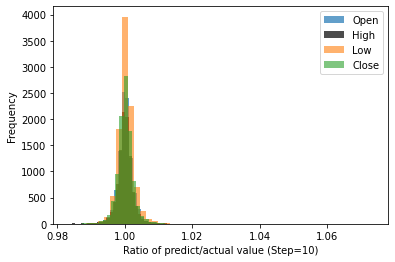

In [ ]:
step=10
plt.hist(pre_ohlc[step, :, 0]/ans_ohlc[step, :, 0], bins=50, alpha=0.7)
plt.hist(pre_ohlc[step, :, 1]/ans_ohlc[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(pre_ohlc[step, :, 2]/ans_ohlc[step, :, 2], bins=50, alpha=0.6)
plt.hist(pre_ohlc[step, :, 3]/ans_ohlc[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [ ]:
print("==============Mean============")
print("Open", np.mean(pre_ohlc[:, :, 0]/ans_ohlc[:, :, 0], axis=1))
print("High", np.mean(pre_ohlc[:, :, 1]/ans_ohlc[:, :, 1], axis=1))
print("Low", np.mean(pre_ohlc[:, :, 2]/ans_ohlc[:, :, 2], axis=1))
print("Close", np.mean(pre_ohlc[:, :, 3]/ans_ohlc[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(pre_ohlc[:, :, 0]/ans_ohlc[:, :, 0], axis=1))
print("High", np.var(pre_ohlc[:, :, 1]/ans_ohlc[:, :, 1], axis=1))
print("Low", np.var(pre_ohlc[:, :, 2]/ans_ohlc[:, :, 2], axis=1))
print("Close", np.var(pre_ohlc[:, :, 3]/ans_ohlc[:, :, 3], axis=1))

==============Mean============
Open [1.         0.99999292 1.00001083 1.00002458 1.00004373 1.00007326
 1.00009138 1.00010518 1.00011022 1.00012273 1.00013864]
High [1.         0.99994406 0.99993818 0.99994227 0.9999632  0.99998211
 0.99999163 1.00000275 1.00001068 1.00002408 1.00002819]
Low [1.         1.00006594 1.00009569 1.00013291 1.00015843 1.00019443
 1.00021252 1.00022554 1.00023466 1.00024695 1.00025646]
Close [1.         1.00001833 1.00003079 1.00005001 1.000081   1.00009919
 1.00011666 1.00011746 1.00013091 1.00014623 1.00014448]
==============Var============
Open [0.00000000e+00 1.27390241e-08 4.54131668e-07 1.11158813e-06
 1.73133558e-06 2.30866729e-06 2.99574812e-06 3.72986527e-06
 4.28099074e-06 5.02676663e-06 5.71177098e-06]
High [0.00000000e+00 2.39517072e-07 7.72358201e-07 1.41166846e-06
 1.98951746e-06 2.56832353e-06 3.23145606e-06 3.90199969e-06
 4.51353184e-06 5.16279761e-06 5.82189616e-06]
Low [0.00000000e+00 2.62670996e-07 8.55726008e-07 1.63258511e-06
 2.1688154

[]

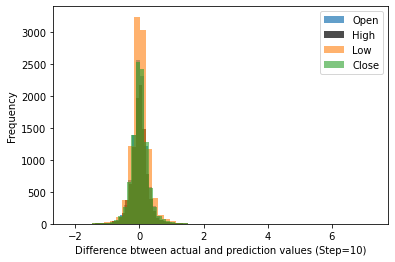

In [ ]:
step=10
plt.hist(pre_ohlc[step, :, 0] - ans_ohlc[step, :, 0], bins=50, alpha=0.7)
plt.hist(pre_ohlc[step, :, 1] - ans_ohlc[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(pre_ohlc[step, :, 2] - ans_ohlc[step, :, 2], bins=50, alpha=0.6)
plt.hist(pre_ohlc[step, :, 3] - ans_ohlc[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [ ]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(pre_ohlc[:, :, 0]-ans_ohlc[:, :, 0], axis=1))
print("High", np.mean(pre_ohlc[:, :, 1]-ans_ohlc[:, :, 1], axis=1))
print("Low", np.mean(pre_ohlc[:, :, 2]-ans_ohlc[:, :, 2], axis=1))
print("Close", np.mean(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(pre_ohlc[:, :, 0]-ans_ohlc[:, :, 0], axis=1))
print("High", np.var(pre_ohlc[:, :, 1]-ans_ohlc[:, :, 1], axis=1))
print("Low", np.var(pre_ohlc[:, :, 2]-ans_ohlc[:, :, 2], axis=1))
print("Close", np.var(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.00079  0.00115  0.00265  0.00475  0.00805  0.01016  0.01173
  0.01219  0.01345  0.01521]
High [ 0.00000e+00 -6.35444e-03 -7.12278e-03 -6.71764e-03 -4.38548e-03
 -2.21361e-03 -1.09345e-03  2.66133e-05  8.17642e-04  2.29728e-03
  2.68468e-03]
Low [0.      0.00744 0.01077 0.0149  0.01772 0.02178 0.02381 0.02529 0.02614
 0.02742 0.02839]
Close [0.      0.00199 0.00334 0.00545 0.00891 0.01103 0.013   0.013   0.01437
 0.01606 0.01573]
==============Var============
Open [0.      0.00016 0.00579 0.01424 0.02232 0.0298  0.03861 0.04783 0.055
 0.06427 0.07284]
High [0.      0.00306 0.00998 0.01823 0.02575 0.03314 0.0416  0.05024 0.05815
 0.0662  0.07461]
Low [0.      0.00336 0.01091 0.02078 0.02792 0.03676 0.04847 0.05456 0.06439
 0.07342 0.08446]
Close [0.      0.0056  0.01404 0.02223 0.02961 0.03848 0.0475  0.05489 0.06415
 0.07284 0.08132]


In [ ]:
import time

ds.eval()
model.eval()

batch_size = 16
ans_ohlc, ans_volume, ans_spread = None, None, None
pre_ohlc, pre_volume, pre_spread = None, None, None

index = 0

indices = [index for index in range(index, index+batch_size)]
val_inp, val_ans = ds[index:index+batch_size]
    
next_pre_ohlc, next_pre_volume, next_pre_spread = batch_prediction(*val_inp, indices)
torch.cuda.empty_cache()

if pre_ohlc is None:
    pre_ohlc = next_pre_ohlc
    pre_volume = next_pre_volume
    pre_spread = next_pre_spread
else:
    pre_ohlc = np.concatenate([pre_ohlc, next_pre_ohlc], axis=1)
    pre_volume = np.concatenate([pre_volume, next_pre_volume], axis=1)
    pre_spread = np.concatenate([pre_spread, next_pre_spread], axis=1)

next_ans_ohlc, next_ans_volume, next_ans_spread = revert_target(*val_ans[:3], indices)
torch.cuda.empty_cache()

if ans_ohlc is None:
    ans_ohlc = next_ans_ohlc
    ans_volume = next_ans_volume
    ans_spread = next_ans_spread
else:
    ans_ohlc = np.concatenate([ans_ohlc, next_ans_ohlc], axis=1)
    ans_volume = np.concatenate([ans_volume, next_ans_volume], axis=1)
    ans_spread = np.concatenate([ans_spread, next_ans_spread], axis=1)

In [ ]:
def revert_diff(source, ndx, last_close_values=None):
    ohlc_diff = (source - ds.ohlc_lower) * 0.1 ** 3
    revert_ohlc = None
    if last_close_values is None:
        if type(ndx) is int:
            target_index = ds._indices[ndx]
            #close.iloc[index - 1] + ohlc.iloc[index]. As index=0 was dropped, index of dataset equal index + 1 of original data
            last_close = df[ds.columns[3]].iloc[target_index]
        else:
            target_index = [ds._indices[index] for index in ndx]
            batch_size = len(ndx)
            last_close = df[ds.columns[3]].iloc[target_index].values.reshape(1, batch_size, 1)
        
        revert_ohlc = last_close + ohlc_diff[0:1]
        print(last_close)
        last_close = revert_ohlc[:, :, 3:]
        for index in range(1, len(ohlc_diff)):
            step_ohlc = last_close + ohlc_diff[index:index+1]
            last_close = step_ohlc[:, :, 3:]
            revert_ohlc = np.concatenate([revert_ohlc, step_ohlc], axis=0)
        return revert_ohlc
    else:
        return last_close_values + ohlc_diff(axis=1)

In [ ]:
def revert_diff(source, ndx, last_close_values=None):
    ohlc_diff = (source - ds.ohlc_lower) * 0.1 ** 3
    revert_ohlc = None
    if type(ndx) is int:
        target_index = ds._indices[ndx]
        #close.iloc[index - 1] + ohlc.iloc[index]. As index=0 was dropped, index of dataset equal index + 1 of original data
        last_close = df[ds.columns[3]].iloc[target_index: target_index + 60]
        return source + last_close
    else:
        batch_index = 0
        i = ndx[0]
        index = ds._indices[i]
        last_close = df[ds.columns[3]].iloc[index: index + 60].values.reshape(60, 1, 1)
        revert_ohlc = last_close + ohlc_diff[:, batch_index:batch_index+1, :]
        for i in ndx[1:]:
            index = ds._indices[i]
            last_close = df[ds.columns[3]].iloc[index: index + 60].values.reshape(60, 1, 1)
            step_ohlc = last_close + ohlc_diff[:, batch_index:batch_index+1, :]
            revert_ohlc = np.concatenate([revert_ohlc, step_ohlc], axis=1)
            batch_index += 1
        return revert_ohlc

In [ ]:
src_ohlc = val_inp[0].cpu().detach().numpy()
original_ohlc = revert_diff(src_ohlc, indices)

In [ ]:
src_ohlc[-1:, 0, :]

array([[4999, 4999, 4801, 4823]])

In [ ]:
original_ohlc[-1:, 0, :]

array([[113.933, 113.933, 113.735, 113.757]])

In [ ]:
val_ans[0][0, 0, :]

tensor([4999, 4999, 4801, 4823], device='cuda:0', dtype=torch.int32)

In [ ]:
ans_ohlc[0, 0, :]

array([113.933     , 113.933     , 113.73499998, 113.757     ])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
close_mean = [0., 0.00199, 0.00334, 0.00545, 0.00891, 0.01103, 0.013, 0.013, 0.01437, 0.01606, 0.01573]

pre_ohlc[:, 0, 3] + close_mean

array([113.757     , 113.82998999, 113.94534   , 113.91245   ,
       113.97391   , 113.98303   , 113.891     , 113.976     ,
       113.93937   , 113.99106   , 113.87573   ])

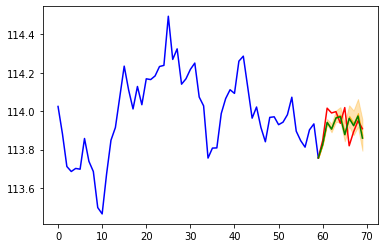

In [ ]:
close_mean = [0., 0.00199, 0.00334, 0.00545, 0.00891, 0.01103, 0.013, 0.013, 0.01437, 0.01606, 0.01573]
close_var = [0., 0.0056, 0.01404, 0.02223, 0.02961, 0.03848, 0.0475, 0.05489, 0.06415, 0.07284, 0.08132]
x = np.arange(70)

pred_value = pre_ohlc[:, 0, 3]
pred_add_mean = pred_value + close_mean
pred_upper = pred_add_mean + close_var
pred_lower = pred_add_mean - close_var

plt.fill_between(x[59:], pred_value, pred_add_mean, color="orange", alpha=0.7)
plt.fill_between(x[59:], pred_lower, pred_upper, color="orange", alpha=0.3)
plt.plot(x[:60], original_ohlc[:, 0, 3], color="blue")
plt.plot(x[59:], ans_ohlc[:, 0, 3], color="red")
plt.plot(x[59:], pred_value, color="green")
plt.show()

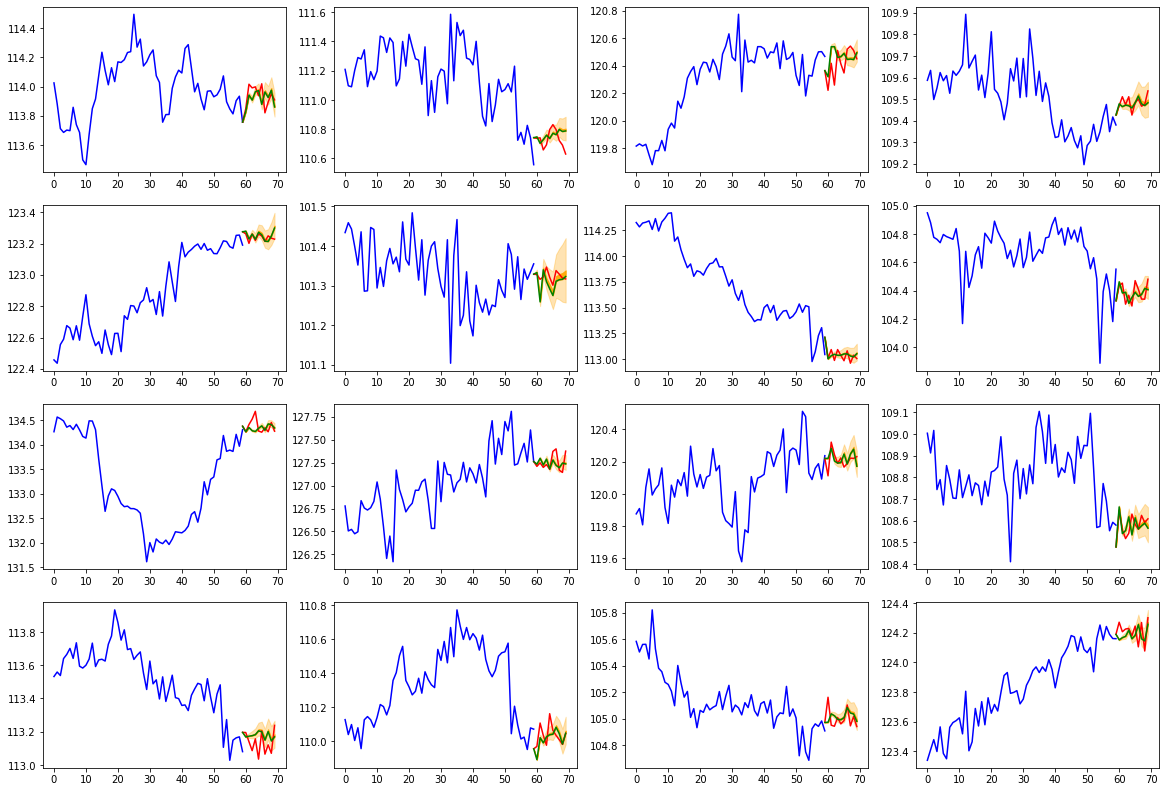

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
x = np.arange(70)

for i, ax in enumerate(axs.flat):
    pred_value = pre_ohlc[:, i, 3]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[59:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[59:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:60], original_ohlc[:, i, 3], color="blue")
    ax.plot(x[59:], ans_ohlc[:, i, 3], color="red")
    ax.plot(x[59:], pred_value, color="green")
    
plt.savefig(f"DID_WP_TS_v1_batch0.png")

In [ ]:
import time

ds.eval()
model.eval()

x = np.arange(70)
batch_size = 16
ans_ohlc, ans_volume, ans_spread = None, None, None
pre_ohlc, pre_volume, pre_spread = None, None, None

for index in range(0, len(ds), batch_size):
    if len(ds) - index < batch_size:
        break
    indices = [index for index in range(index, index+batch_size)]
    val_inp, val_ans = ds[index:index+batch_size]
        
    src_ohlc = val_inp[0].cpu().detach().numpy()
    original_ohlc = revert_diff(src_ohlc, indices)
    
    next_pre_ohlc, next_pre_volume, next_pre_spread = batch_prediction(*val_inp, indices)
    torch.cuda.empty_cache()
    
    if pre_ohlc is None:
        pre_ohlc = next_pre_ohlc
        pre_volume = next_pre_volume
        pre_spread = next_pre_spread
    else:
        pre_ohlc = np.concatenate([pre_ohlc, next_pre_ohlc], axis=1)
        pre_volume = np.concatenate([pre_volume, next_pre_volume], axis=1)
        pre_spread = np.concatenate([pre_spread, next_pre_spread], axis=1)
    
    next_ans_ohlc, next_ans_volume, next_ans_spread = revert_target(*val_ans[:3], indices)
    torch.cuda.empty_cache()
    
    if ans_ohlc is None:
        ans_ohlc = next_ans_ohlc
        ans_volume = next_ans_volume
        ans_spread = next_ans_spread
    else:
        ans_ohlc = np.concatenate([ans_ohlc, next_ans_ohlc], axis=1)
        ans_volume = np.concatenate([ans_volume, next_ans_volume], axis=1)
        ans_spread = np.concatenate([ans_spread, next_ans_spread], axis=1)

    torch.cuda.empty_cache()
    
    fig, axs = plt.subplots(4, 4, figsize=(20, 14))

    for i, ax in enumerate(axs.flat):
        pred_value = next_pre_ohlc[:, i, 3]
        pred_add_mean = pred_value + close_mean
        pred_upper = pred_add_mean + close_var
        pred_lower = pred_add_mean - close_var

        ax.fill_between(x[59:], pred_value, pred_add_mean, color="orange", alpha=0.9)
        ax.fill_between(x[59:], pred_lower, pred_upper, color="orange", alpha=0.3)
        ax.plot(x[:60], original_ohlc[:, i, 3], color="blue")
        ax.plot(x[59:], next_ans_ohlc[:, i, 3], color="red")
        ax.plot(x[59:], pred_value, color="green")
        
    plt.savefig(f"DID_WP_TS_v1_batch{index}.png")
    plt.show()

## Transformer with Clipped Diff ID

In [115]:
ohlc_column = ['open','high','low','close']
time_column = "time"
file_name = "mt5_USDJPY_min30.csv"
file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=[time_column], index_col=0)

In [118]:
ohlc_std = df[ohlc_column].diff().std().max()
ohlc_std


0.08576317731604662

array([[<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>]], dtype=object)

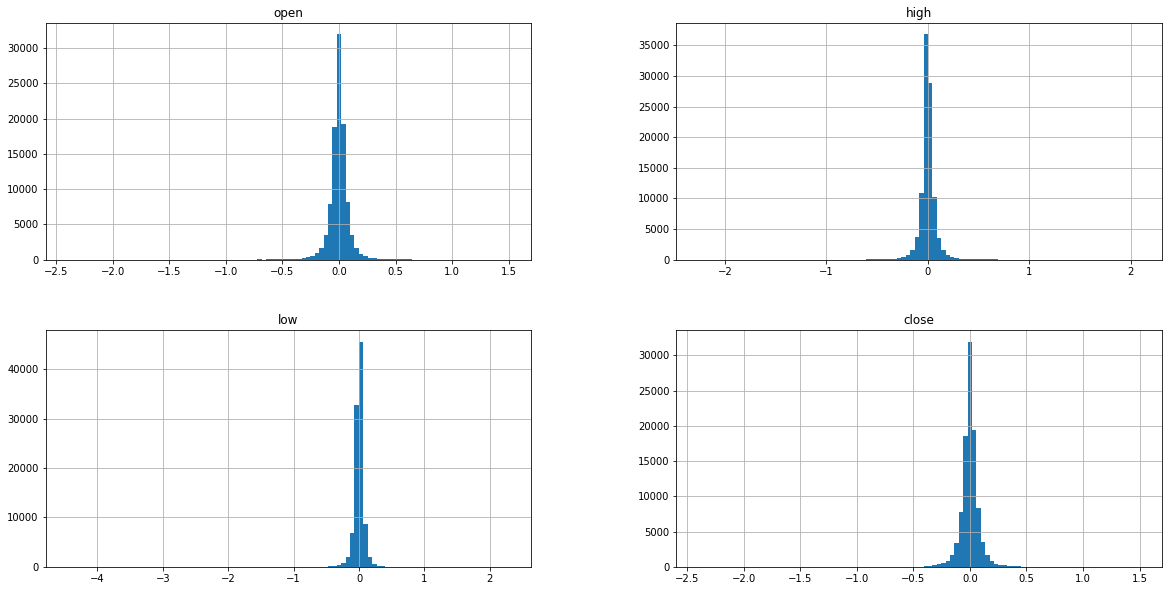

In [122]:
df[ohlc_column].diff().hist(bins=100, figsize=(20, 10))

In [127]:
diff_df = df["tick_volume"].diff()
volume_std = diff_df.std()
diff_df[diff_df >= volume_std*2] = volume_std*2 + 0.01
diff_df[diff_df <= -volume_std*2] = -volume_std*2 - 0.01

<AxesSubplot:>

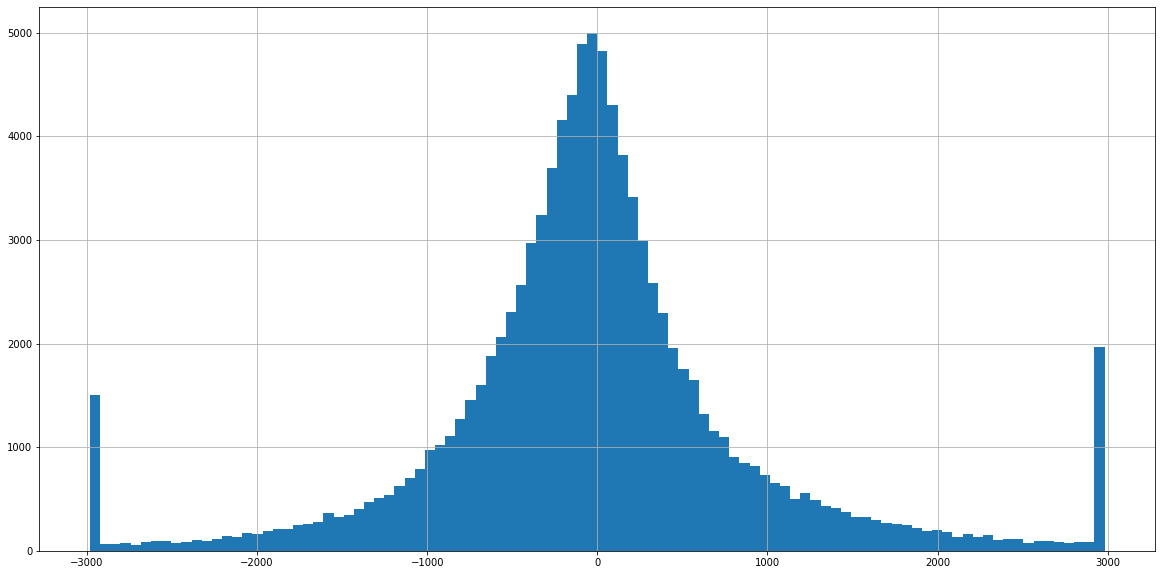

In [128]:
diff_df.hist(bins=100, figsize=(20, 10))

In [134]:
import random
import numpy as np
import torch


class CloseDiffIDDS:
    
    def __init__(self, df, ohlc_columns, volume_column=None, spread_column=None, observation_length=60,
                device="cuda", future_step_size=1, alpha=2, seed=1017, is_training = True):
        self.seed(seed)
        self.columns = ohlc_columns
        self.ohlc_idf = self.__init_ohlc(df, ohlc_columns, alpha)
        
        if volume_column is not None:
            self.volume_idf = self.__init_volume(df[volume_column], alpha)
            self.columns.append(volume_column)
            self.__get_volume = lambda idx: self.volume_idf.iloc[idx].values.tolist()
        if spread_column is not None:
            self.spread_idf = self.__init_spread(df[spread_column], alpha)
            self.columns.append(spread_column)
            self.__get_spread = lambda idx: self.spread_idf.iloc[idx].values.tolist()
        
        self.observation_length = observation_length
        self.device = device
        self.future_step_size = future_step_size
        self.is_training = is_training
        self.__init_indicies(self.ohlc_idf)
        
    
    def __init_indicies(self, data, split_ratio=0.8):
        length = len(data) - self.observation_length - self.future_step_size
        if length < 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")
        
        to_index = int(length * split_ratio)
        from_index = 1
        train_indices = list(range(from_index, to_index))
        self.train_indices = random.sample(train_indices, k=to_index - from_index)

        # Note: If unique value exits in validation data only, validation loss would be grater than expected
        from_index = int(length * split_ratio) + self.observation_length + self.future_step_size
        to_index = length
        eval_indices = list(range(from_index, to_index))
        self.eval_indices = random.sample(eval_indices, k=to_index - from_index)
        
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.eval_indices
    
    def revert_diff(self, prediction, ndx, last_close_value=None):
        if last_close_value is None:
            if type(ndx) is int:
                target_index = self._indices[ndx] + self.observation_length - 1
                #close.iloc[index - 1] + ohlc.iloc[index]. As index=0 was dropped, index of dataset equal index + 1 of original data
                last_close = df[self.columns[3]].iloc[target_index]
            else:
                target_index = [self._indices[index] + self.observation_length - 1 for index in ndx]
                batch_size = len(ndx)
                last_close = df[self.columns[3]].iloc[target_index].values.reshape(batch_size, 1)
            return last_close + prediction
            
        else:
            return last_close_value + prediction
    
    def revert(self, diff):
        pass
    
    def __init_ohlc(self, df, ohlc_columns, alpha, decimal_digits = 3):
        close_column = [ohlc_columns[3]]
        ohlc_cls_diff_df = df[ohlc_columns].iloc[1:] - df[close_column].iloc[:-1].values
        std = ohlc_cls_diff_df.std().max()
        ohlc_cls_diff_df[ohlc_cls_diff_df <= -std * alpha] = -std*alpha - 0.1**decimal_digits
        ohlc_cls_diff_df[ohlc_cls_diff_df >= std * alpha] = std*alpha + 0.1**decimal_digits
        min_value = ohlc_cls_diff_df.min().min()
        min_value_abs = abs(min_value)

        lower_value = math.ceil(min_value_abs) * 10 ** decimal_digits
        upper_value = math.ceil(ohlc_cls_diff_df.max().max()) * 10 ** decimal_digits
        id_df =  ohlc_cls_diff_df * 10 ** decimal_digits + lower_value
        self.ohlc_lower = lower_value
        id_df = id_df.astype('int64')
        self.ohlc_range_size = lower_value + upper_value
        return id_df
    
    def __get_volume(self, idx):
        return []
    
    def __get_spread(self, idx):
        return []
    
    def __init_volume(self, df, alpha):
        volume_df = df.iloc[1:].round(decimals=-1)/10
        volume_df.dropna(inplace=True)
        std = volume_df.std()
        volume_df[volume_df >= std * alpha] = int(std*alpha) + 1
        self.volume_range_size = math.ceil(volume_df.max()/100)*100
        volume_df = volume_df.astype(dtype='int64')
        return volume_df
    
    def __init_spread(self, df, alpha):
        spread_df = df.iloc[1:]
        spread_df = spread_df.astype('int64')
        std = spread_df.std()
        spread_df[spread_df >= std * alpha] = int(std*alpha) + 1
        self.spread_range_size = spread_df.max()*2
        return spread_df
    
    def __get_data_set(self, idx):
        ohlc_ids = self.ohlc_idf.iloc[idx].values.tolist()
        volume_ids = self.__get_volume(idx)
        spread_ids = self.__get_spread(idx)
        return ohlc_ids, volume_ids, spread_ids
    
    def _output_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index + self.observation_length -1, index + self.observation_length + self.future_step_size)
            ohlc_ids, volume_ids, spread_ids = self.__get_data_set(idx)
            
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            
            return ohlc_ids, volume_ids, spread_ids
        elif type(batch_size) == slice:    
            ohlc_chunk_data = []
            volume_chunk_data = []
            spread_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index + self.observation_length -1, index + self.observation_length + self.future_step_size)
                ohlc_ids, volume_ids, spread_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                volume_chunk_data.append(volume_ids)
                spread_chunk_data.append(spread_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            
            return ohlc_ids.transpose(0, 1), volume_ids.transpose(0, 1), spread_ids.transpose(0, 1)
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index, index + self.observation_length)
            ohlc_ids, volume_ids, spread_ids = self.__get_data_set(idx)
            
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_ids, device=self.device, dtype=torch.int).unsqueeze(2)
            
            return ohlc_ids, volume_ids, spread_ids
        elif type(batch_size) == slice:
            ohlc_chunk_data = []
            volume_chunk_data = []
            spread_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index, index + self.observation_length)
                ohlc_ids, volume_ids, spread_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                volume_chunk_data.append(volume_ids)
                spread_chunk_data.append(spread_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int)
            volume_ids = torch.tensor(volume_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            spread_ids = torch.tensor(spread_chunk_data, device=self.device, dtype=torch.int).unsqueeze(2)
            
            return ohlc_ids.transpose(0, 1), volume_ids.transpose(0, 1), spread_ids.transpose(0, 1)
    
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def seed(self, seed=None):
        '''
        '''
        if seed is None:
            seed = 1192
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed
            
    def eval(self):
        self._indices = self.eval_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = False

In [144]:
ohlc_column = ['open','high','low','close']
time_column = "time"
file_name = "mt5_USDJPY_min30.csv"
file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=[time_column], index_col=0)

ds = CloseDiffIDDS(df, ohlc_column, "tick_volume", spread_column="spread", observation_length=60,
                device="cuda:0", future_step_size=10, alpha=1, seed=1017, is_training = True)

In [145]:
device = "cuda:0"
nhead = 4
d_model = 120
dim_feedforward = 100
num_encoder_layers = 4
num_decoder_layers = 4
feature_size = 5
dropout = 0

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    ohlc_size=ds.ohlc_range_size, volume_size=ds.volume_range_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.0001
batch_size = 64

criterion = nn.CrossEntropyLoss()

In [146]:
optimizer_o = torch.optim.AdamW(get_parameters(model, "open_output"), lr=lr)
scheduler_o = torch.optim.lr_scheduler.StepLR(optimizer_o, 1.0, gamma = 0.5)
optimizer_h = torch.optim.AdamW(get_parameters(model, "high_output"), lr=lr)
scheduler_h = torch.optim.lr_scheduler.StepLR(optimizer_h, 1.0, gamma = 0.5)
optimizer_l = torch.optim.AdamW(get_parameters(model, "low_output"), lr=lr)
scheduler_l = torch.optim.lr_scheduler.StepLR(optimizer_l, 1.0, gamma = 0.5)
optimizer_c = torch.optim.AdamW(get_parameters(model, "close_output"), lr=lr)
scheduler_c = torch.optim.lr_scheduler.StepLR(optimizer_c, 1.0, gamma = 0.5)
optimizer_v = torch.optim.AdamW(get_parameters(model, "volume_output"), lr=lr)
scheduler_v = torch.optim.lr_scheduler.StepLR(optimizer_v, 1.0, gamma = 0.5)

In [147]:
epoch = 500
model.train()
ds.train()
best_loss = float('Inf')
best_model = None
best_losses = [float('Inf') for i in range(6)]
patience = 3
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizers=[optimizer_o, optimizer_h, optimizer_l, optimizer_c, optimizer_v, optimizer_s],
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    amount_loss_valid = sum(loss_valid)
    print(f'{loop}/{epoch} {str(int(math.floor(elapsed_time / 60))) + "m" if math.floor(elapsed_time / 60) > 0 else ""}{elapsed_time % 60}s count: {counter}, \
        {sum(loss_train)}, {amount_loss_valid}\
        {"**" if best_loss > amount_loss_valid else ""}')
    print(f'train loss: {loss_train}')
    print(f'valid loss: {loss_valid}')
    
    if best_loss > amount_loss_valid:
        best_loss = amount_loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
    for index, scheduler in enumerate([scheduler_o, scheduler_h, scheduler_l, scheduler_c, scheduler_v]):
        if best_losses[index] < loss_valid[index]:
            scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 1258/1258 [04:41<00:00,  4.48it/s]


1/500 4m41.007813453674316s count: 0,         0.022046273450093752, 0.02222064381737689        **
train loss: [0.002080541083982636, 0.0020775491536637086, 0.002077750511776578, 0.0020785611516888174, 0.013731871548982014]
valid loss: [0.002083185507991739, 0.0020831852680350525, 0.0020831853134926854, 0.0020831853716188394, 0.013887902356238574]


100%|██████████| 1258/1258 [04:21<00:00,  4.80it/s]


2/500 4m21.919001817703247s count: 0,         0.022196688402696847, 0.022220636243837123        **
train loss: [0.002080950356208111, 0.0020809473042612326, 0.00208095832872015, 0.002080958116095134, 0.013872874297412222]
valid loss: [0.0020831852531309103, 0.0020831843313097263, 0.00208318270824866, 0.0020831844833319748, 0.01388789946781585]


100%|██████████| 1258/1258 [04:57<00:00,  4.23it/s]


3/500 4m57.75853204727173s count: 0,         0.022193747695929834, 0.02222064282252541        
train loss: [0.0020809463176292976, 0.0020808588313253906, 0.0020808588496615196, 0.0020809132529575765, 0.01387017044435605]
valid loss: [0.002083185250895289, 0.0020831852449336324, 0.002083185227048662, 0.0020831852561117386, 0.01388790184353609]


100%|██████████| 1258/1258 [04:45<00:00,  4.41it/s]


4/500 4m45.070878982543945s count: 1,         0.022196736300556436, 0.02222064229044754        
train loss: [0.002080943970604729, 0.0020809456858662924, 0.00208094555121613, 0.00208096215374788, 0.013872938939121403]
valid loss: [0.002083185236736354, 0.002083185177119786, 0.0020831851145223894, 0.002083185198730792, 0.01388790156333822]


100%|██████████| 1258/1258 [04:28<00:00,  4.69it/s]


5/500 4m28.109954833984375s count: 2,         0.022196102550581423, 0.02222064334417038        
train loss: [0.0020809422838660337, 0.002080922971847035, 0.0020809229075779753, 0.0020809364492726024, 0.013872377938017778]
valid loss: [0.0020831853351036913, 0.0020831852128897267, 0.0020831853067858216, 0.002083185344791384, 0.013887902144599758]


100%|██████████| 1258/1258 [04:28<00:00,  4.69it/s]


6/500 4m28.088928699493408s count: 3,         0.022196703873204122, 0.02222063915163523        
train loss: [0.0020809408058628724, 0.0020809395386325934, 0.002080940900321721, 0.0020809403457927155, 0.01387294228259422]
valid loss: [0.002083185294117301, 0.002083184684537892, 0.0020831849364178925, 0.002083185183081443, 0.013887899053480701]


## Transformer with Argumented Diff ID Dataset

In [4]:
import zipfile
import os

import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d %H%M%S'), index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

In [5]:
import glob
import os

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"

folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')

for file in files:
    min_df = read_histdata_file(file)
    df = pd.concat([df, min_df], axis=0)

In [6]:
freq = 30
freq_str = "30MIN"

org_df = df.groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()

DFS = []
BIAS = 2

for bias in range(-BIAS, BIAS+1):
    min_df = df.copy()
    min_df.index += pd.Timedelta(minutes=bias)
    rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()
    rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq=freq_str)).max().dropna()
    rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq=freq_str)).min().dropna()
    rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq=freq_str)).last().dropna()
    #rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq=freq_str)).sum()
    #rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
    rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close], axis=1)
    rolled_df = rolled_df[rolled_df.index.isin(org_df.index)]
    DFS.append(rolled_df)

### Basic Model 2'

changed embedded position from sin/cos to Embedding Layer

In [7]:
import random
import numpy as np
import torch


class CloseDiffIDDS:
    
    def __init__(self, df, ohlc_columns, observation_length=60,
                device="cuda", prediction_length=10, seed=1017, is_training = True):
        self.seed(seed)
        self.columns = ohlc_columns
        self.ohlc_idf = self.__init_ohlc(df, ohlc_columns)
        
        self.observation_length = observation_length
        self.device = device
        self.prediction_length = prediction_length
        self.is_training = is_training
        self.__init_indicies(self.ohlc_idf)
        
    
    def __init_indicies(self, data, split_ratio=0.8):
        length = len(data.index) - self.observation_length - self.prediction_length
        to_index = int(length * split_ratio)
        from_index = 1
        train_indices = list(range(from_index, to_index))
        self.train_indices = random.sample(train_indices, k=to_index - from_index)

        # Note: If unique value exits in validation data only, validation loss would be grater than expected
        from_index = int(length * split_ratio) + self.observation_length + self.prediction_length
        to_index = length
        eval_indices = list(range(from_index, to_index))
        self.eval_indices = random.sample(eval_indices, k=to_index - from_index)
        
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.eval_indices
    
    def revert_diff(self, org_df, prediction, ndx, last_close_value=None):
        if last_close_value is None:
            if type(ndx) is int:
                target_index = self._indices[ndx] + self.observation_length - 1
                #close.iloc[index - 1] + ohlc.iloc[index]. As index=0 was dropped, index of dataset equal index + 1 of original data
                last_close = org_df[self.columns[3]].iloc[target_index]
            else:
                target_index = [self._indices[index] + self.observation_length - 1 for index in ndx]
                batch_size = len(ndx)
                last_close = org_df[self.columns[3]].iloc[target_index].values.reshape(batch_size, 1)
            return last_close + prediction
            
        else:
            return last_close_value + prediction
    
    def revert(self, diff):
        pass
    
    def __init_ohlc(self, df, ohlc_columns, decimal_digits = 3):
        close_column = [ohlc_columns[3]]
        ohlc_cls_diff_df = df[ohlc_column].iloc[1:] - df[close_column].iloc[:-1].values
        min_value = ohlc_cls_diff_df.min().min()
        min_value_abs = abs(min_value)

        lower_value = math.ceil(min_value_abs) * 10 ** decimal_digits
        upper_value = math.ceil(ohlc_cls_diff_df.max().max()) * 10 ** decimal_digits
        id_df =  ohlc_cls_diff_df * 10 ** decimal_digits + lower_value
        self.ohlc_lower = lower_value
        id_df = id_df.astype('int64')
        self.ohlc_range_size = lower_value + upper_value
        return id_df
    
    
    def __get_data_set(self, idx):
        ohlc_ids = self.ohlc_idf.iloc[idx].values.tolist()
        return ohlc_ids
    
    def _output_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index + self.observation_length -1, index + self.observation_length + self.prediction_length)
            ohlc_ids = self.__get_data_set(idx)
            
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int)
            
            return ohlc_ids
        elif type(batch_size) == slice:    
            ohlc_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index + self.observation_length -1, index + self.observation_length + self.prediction_length)
                ohlc_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int)
            
            return ohlc_ids.transpose(0, 1)
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index, index + self.observation_length)
            ohlc_ids = self.__get_data_set(idx)
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int)
            
            return ohlc_ids
        elif type(batch_size) == slice:
            ohlc_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index, index + self.observation_length)
                ohlc_ids = self.__get_data_set(idx)
                ohlc_chunk_data.append(ohlc_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int)
            
            return ohlc_ids.transpose(0, 1)
    
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def seed(self, seed=None):
        '''
        '''
        if seed == None:
            seed = 1192
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed
            
    def eval(self):
        self._indices = self.eval_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = False

In [8]:
ds_array = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Dataset parameters
batch_size = 128
observation_length = 30
prediction_length = 10

for df_ in DFS:
  ohlc_column = ['open','high','low','close']

  ds = CloseDiffIDDS(df_, ohlc_column, observation_length=observation_length, prediction_length=prediction_length, device=device)
  ds_array.append(ds)

#### Define Model

In [196]:
class VariationalDropout(nn.Dropout):
    def forward(self, input):
        if self.training:
            mask = self.get_mask(input)
            return input * mask
        else:
            return input

    def get_mask(self, input):
        return torch.ones_like(input).bernoulli_(1 - self.p) / (1 - self.p)

In [197]:
class PositionalEncoding(nn.Module):
    def __init__(self, position_size, d_model, dropout, vp=False):
        super().__init__()
        self.pe = nn.Embedding(position_size, d_model)
        if vp:
            self.dropout = VariationalDropout(dropout)
        else:
            self.dropout = nn.Dropout(dropout)

    def forward(self, position_ids):
        position = self.pe(position_ids)
        return position

In [198]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int, observation_length, prediction_length,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8, vp=False
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        d_model = d_model + (d_model % 4)
        emb_d_model = int(d_model/4)
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim = emb_d_model)
        
        self.positional_encoding = PositionalEncoding(observation_length + prediction_length, d_model, dropout=dropout, vp=vp)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.output_layer = nn.Linear(d_model, 4)
        

    def forward(
        self, src_ohlc: Tensor, src_positions: Tensor, tgt_ohlc: Tensor, tgt_positions: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        src_ohlc = self.ohlc_embedded_layer(src_ohlc)
        src_ohlc = src_ohlc.reshape(src_ohlc.size(0), src_ohlc.size(1), src_ohlc.size(2)*src_ohlc.size(3))
        
        src_positions = self.positional_encoding(src_positions)
        src_ohlc = torch.add(src_ohlc, src_positions)
        
        tgt_ohlc = self.ohlc_embedded_layer(tgt_ohlc)
        tgt_ohlc = tgt_ohlc.reshape(tgt_ohlc.size(0), tgt_ohlc.size(1), tgt_ohlc.size(2)*tgt_ohlc.size(3))
        tgt_positions = self.positional_encoding(tgt_positions)
        tgt_ohlc = torch.add(tgt_ohlc, tgt_positions)
        
        memory = self.transformer_encoder(src_ohlc, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt_ohlc, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        output = self.output_layer(outs)
        
        return output

In [17]:
def train(model, ds_array, optimizer, criterion, batch_size, device):
    
    model.train()
    losses = 0
    length = 0
    end_index = 0
    
    mini_batch = int(batch_size/len(ds_array))
    if mini_batch <= 1:
        mini_batch = 2
    
    ds_length = []
    for ds in ds_array:
        ds_length.append(len(ds))
        ds.train()
    
    end_index = min(ds_length)
    
    end = False
    for index in tqdm(range(0, end_index - mini_batch, mini_batch)):
        length+=1.0
        sources = []
        targets = []
        for ds in ds_array:
            try:
                src, tgt = ds[index:index+mini_batch]
                sources.append(src)
                targets.append(tgt)
            except:
                break
            
        src = torch.concat(sources, dim=1)
        tgt = torch.concat(targets, dim=1)

        in_ohlc_tgt = tgt[:-1, :]
        obs_length = src.shape[0]
        batch_length = src.shape[1]
        src_positions = torch.arange(0, obs_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_length).to(device)
        tgt_positions = torch.arange(obs_length, obs_length + in_ohlc_tgt.shape[0], 1, dtype=torch.int).reshape(in_ohlc_tgt.shape[0], 1).repeat(1, batch_length).to(device)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.shape[0]).to(device)
        logits = model(
            src_ohlc=src, src_positions=src_positions,
            tgt_ohlc=in_ohlc_tgt, tgt_positions=tgt_positions,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_ohlc_tgt = tgt[1:, :]
        out_ohlc_tgt = out_ohlc_tgt.to(dtype=torch.float)/ohlc_range_size
        
        optimizer.zero_grad()
        
        loss = criterion(logits, out_ohlc_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [18]:
def evaluate(model, ds, criterion, batch_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        
        in_ohlc_tgt = tgt[:-1, :]
        obs_length = src.shape[0]
        batch_length = src.shape[1]
        src_positions = torch.arange(0, obs_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_length).to(device)
        tgt_positions = torch.arange(obs_length, obs_length + in_ohlc_tgt.shape[0], 1, dtype=torch.int).reshape(in_ohlc_tgt.shape[0], 1).repeat(1, batch_length).to(device)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.shape[0]).to(device)
        logits = model(
            src_ohlc=src, src_positions=src_positions,
            tgt_ohlc=in_ohlc_tgt, tgt_positions=tgt_positions,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_ohlc_tgt = tgt[1:, :]
        out_ohlc_tgt = out_ohlc_tgt.to(dtype=torch.float)/ohlc_range_size
        
        optimizer.zero_grad()
        
        loss = criterion(logits, out_ohlc_tgt)
        losses += loss.item()
        
    return losses / length

#### Train

In [ ]:
device = "cuda:0"
nhead = 4
d_model = 124
dim_feedforward = 1000
num_encoder_layers = 12
num_decoder_layers = 12
feature_size = 4
dropout = 0.2

ohlc_range_size = max([ds.ohlc_range_size for ds in ds_array])

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    ohlc_size=ds.ohlc_range_size,
    observation_length=ds.observation_length,
    prediction_length=ds.prediction_length,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead, vp=True
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.0001

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [20]:
import json
import logging

model_name = f"finance_did_pl_transfomer_shift{BIAS}"
model_version = "3"

log_file_path = f"{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
print(params)
params = {"processes": [ ],
          "ohlc_range_size": ohlc_range_size,
          "source": files,
          "freq":30,
          "symbols": ["USDJPY"],
          "features": ohlc_column,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

param_file_path = f"{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

8572316
saved params on  finance_did_pl_transfomer_shift2_3_params.json
training log will be saved on  finance_did_pl_transfomer_shift2_3.log


In [19]:
# model = torch.nn.DataParallel(model)

d:\workspace\SakuraGit\python\torch\stocknet\venv\lib\site-packages\torch\nn\parallel\data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [15]:
batch_size = 64

In [23]:
logger.debug("start training")

epoch = 500
best_loss = float('Inf')
best_model = None
patience = 5
counter = 0

ACTUAL_DS_INDEX = BIAS

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds_array=ds_array, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds_array[ACTUAL_DS_INDEX], criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    elapsed_mins = math.floor(elapsed_time / 60)
    log = '[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(elapsed_mins)) + 'm' if elapsed_mins > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    )
    print(log)
    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
          
    if counter > patience:
        break

100%|██████████| 4588/4588 [14:34<00:00,  5.25it/s]


[1/500] train loss: 0.0000374706, valid loss: 0.0000220230  34s] count: 0, 


100%|██████████| 4588/4588 [13:14<00:00,  5.77it/s]


[2/500] train loss: 0.0000372952, valid loss: 0.0000218942  15s] count: 1, **


100%|██████████| 4588/4588 [13:50<00:00,  5.53it/s]


[3/500] train loss: 0.0000372490, valid loss: 0.0000218589  50s] count: 0, **


100%|██████████| 4588/4588 [14:58<00:00,  5.11it/s]


[4/500] train loss: 0.0000371925, valid loss: 0.0000217809  59s] count: 0, **


100%|██████████| 4588/4588 [15:56<00:00,  4.80it/s]


[5/500] train loss: 0.0000371388, valid loss: 0.0000218070  57s] count: 0, 


100%|██████████| 4588/4588 [15:29<00:00,  4.93it/s]


[6/500] train loss: 0.0000370869, valid loss: 0.0000216718  30s] count: 1, **


100%|██████████| 4588/4588 [14:01<00:00,  5.45it/s]


[7/500] train loss: 0.0000370353, valid loss: 0.0000216134  2s] count: 0, **


100%|██████████| 4588/4588 [15:54<00:00,  4.81it/s]


[8/500] train loss: 0.0000369550, valid loss: 0.0000215808  55s] count: 0, **


100%|██████████| 4588/4588 [12:48<00:00,  5.97it/s]


[9/500] train loss: 0.0000368967, valid loss: 0.0000214569  49s] count: 0, **


100%|██████████| 4588/4588 [13:20<00:00,  5.73it/s]


[10/500] train loss: 0.0000368817, valid loss: 0.0000214972  20s] count: 0, 


100%|██████████| 4588/4588 [13:15<00:00,  5.77it/s]


[11/500] train loss: 0.0000367824, valid loss: 0.0000214292  16s] count: 1, **


100%|██████████| 4588/4588 [13:15<00:00,  5.77it/s]


[12/500] train loss: 0.0000367194, valid loss: 0.0000213450  16s] count: 0, **


100%|██████████| 4588/4588 [12:46<00:00,  5.98it/s]


[13/500] train loss: 0.0000366701, valid loss: 0.0000212438  47s] count: 0, **


100%|██████████| 4588/4588 [12:21<00:00,  6.18it/s]


[14/500] train loss: 0.0000366164, valid loss: 0.0000212097  22s] count: 0, **


100%|██████████| 4588/4588 [12:18<00:00,  6.21it/s]


[15/500] train loss: 0.0000365622, valid loss: 0.0000210847  18s] count: 0, **


100%|██████████| 4588/4588 [12:19<00:00,  6.20it/s]


[16/500] train loss: 0.0000364973, valid loss: 0.0000210626  20s] count: 0, **


100%|██████████| 4588/4588 [12:15<00:00,  6.23it/s]


[17/500] train loss: 0.0000364806, valid loss: 0.0000209956  16s] count: 0, **


100%|██████████| 4588/4588 [12:02<00:00,  6.35it/s]


[18/500] train loss: 0.0000364194, valid loss: 0.0000208961  3s] count: 0, **


100%|██████████| 4588/4588 [12:02<00:00,  6.35it/s]


[19/500] train loss: 0.0000363992, valid loss: 0.0000208044  2s] count: 0, **


100%|██████████| 4588/4588 [11:54<00:00,  6.42it/s]


[20/500] train loss: 0.0000362837, valid loss: 0.0000207177  54s] count: 0, **


100%|██████████| 4588/4588 [11:55<00:00,  6.42it/s]


[21/500] train loss: 0.0000362243, valid loss: 0.0000206711  55s] count: 0, **


100%|██████████| 4588/4588 [11:44<00:00,  6.51it/s]


[22/500] train loss: 0.0000361614, valid loss: 0.0000204988  45s] count: 0, **


100%|██████████| 4588/4588 [12:56<00:00,  5.91it/s]


[23/500] train loss: 0.0000361061, valid loss: 0.0000204217  56s] count: 0, **


100%|██████████| 4588/4588 [13:42<00:00,  5.58it/s]


[24/500] train loss: 0.0000360957, valid loss: 0.0000203099  42s] count: 0, **


100%|██████████| 4588/4588 [15:22<00:00,  4.97it/s]


[25/500] train loss: 0.0000359842, valid loss: 0.0000202448  22s] count: 0, **


100%|██████████| 4588/4588 [13:26<00:00,  5.69it/s]


[26/500] train loss: 0.0000359036, valid loss: 0.0000202117  27s] count: 0, **


100%|██████████| 4588/4588 [13:28<00:00,  5.68it/s]


[27/500] train loss: 0.0000358379, valid loss: 0.0000199747  28s] count: 0, **


100%|██████████| 4588/4588 [13:25<00:00,  5.70it/s]


[28/500] train loss: 0.0000357901, valid loss: 0.0000199271  25s] count: 0, **


100%|██████████| 4588/4588 [13:23<00:00,  5.71it/s]


[29/500] train loss: 0.0000356926, valid loss: 0.0000198734  23s] count: 0, **


100%|██████████| 4588/4588 [13:23<00:00,  5.71it/s]


[30/500] train loss: 0.0000356235, valid loss: 0.0000198578  23s] count: 0, **


100%|██████████| 4588/4588 [13:25<00:00,  5.70it/s]


[31/500] train loss: 0.0000355381, valid loss: 0.0000196389  25s] count: 0, **


100%|██████████| 4588/4588 [13:27<00:00,  5.68it/s]


[32/500] train loss: 0.0000354299, valid loss: 0.0000195056  27s] count: 0, **


100%|██████████| 4588/4588 [13:23<00:00,  5.71it/s]


[33/500] train loss: 0.0000353588, valid loss: 0.0000194173  24s] count: 0, **


100%|██████████| 4588/4588 [13:25<00:00,  5.69it/s]


[34/500] train loss: 0.0000353017, valid loss: 0.0000191863  26s] count: 0, **


100%|██████████| 4588/4588 [13:24<00:00,  5.70it/s]


[35/500] train loss: 0.0000351783, valid loss: 0.0000191719  24s] count: 0, **


100%|██████████| 4588/4588 [13:26<00:00,  5.69it/s]


[36/500] train loss: 0.0000351302, valid loss: 0.0000190183  27s] count: 0, **


100%|██████████| 4588/4588 [13:23<00:00,  5.71it/s]


[37/500] train loss: 0.0000350464, valid loss: 0.0000192221  24s] count: 0, 


100%|██████████| 4588/4588 [13:22<00:00,  5.72it/s]


[38/500] train loss: 0.0000349697, valid loss: 0.0000188321  22s] count: 1, **


100%|██████████| 4588/4588 [13:23<00:00,  5.71it/s]


[39/500] train loss: 0.0000350200, valid loss: 0.0000187960  24s] count: 0, **


100%|██████████| 4588/4588 [13:23<00:00,  5.71it/s]


[40/500] train loss: 0.0000348426, valid loss: 0.0000187562  24s] count: 0, **


100%|██████████| 4588/4588 [13:25<00:00,  5.69it/s]


[41/500] train loss: 0.0000347945, valid loss: 0.0000186220  26s] count: 0, **


100%|██████████| 4588/4588 [13:24<00:00,  5.70it/s]


[42/500] train loss: 0.0000347118, valid loss: 0.0000186518  25s] count: 0, 


100%|██████████| 4588/4588 [13:24<00:00,  5.70it/s]


[43/500] train loss: 0.0000346294, valid loss: 0.0000185870  25s] count: 1, **


100%|██████████| 4588/4588 [13:26<00:00,  5.69it/s]


[44/500] train loss: 0.0000345709, valid loss: 0.0000185238  26s] count: 0, **


100%|██████████| 4588/4588 [13:24<00:00,  5.70it/s]


[45/500] train loss: 0.0000345070, valid loss: 0.0000183688  25s] count: 0, **


100%|██████████| 4588/4588 [13:34<00:00,  5.63it/s]


[46/500] train loss: 0.0000344481, valid loss: 0.0000183404  35s] count: 0, **


100%|██████████| 4588/4588 [14:38<00:00,  5.22it/s]


[47/500] train loss: 0.0000343551, valid loss: 0.0000181867  39s] count: 0, **


100%|██████████| 4588/4588 [13:25<00:00,  5.70it/s]


[48/500] train loss: 0.0000343376, valid loss: 0.0000181071  25s] count: 0, **


100%|██████████| 4588/4588 [13:21<00:00,  5.73it/s]


[49/500] train loss: 0.0000342249, valid loss: 0.0000181172  21s] count: 0, 


100%|██████████| 4588/4588 [13:19<00:00,  5.74it/s]


[50/500] train loss: 0.0000341604, valid loss: 0.0000180242  20s] count: 1, **


100%|██████████| 4588/4588 [13:20<00:00,  5.73it/s]


[51/500] train loss: 0.0000340809, valid loss: 0.0000179491  20s] count: 0, **


100%|██████████| 4588/4588 [13:20<00:00,  5.73it/s]


[52/500] train loss: 0.0000340141, valid loss: 0.0000178832  21s] count: 0, **


100%|██████████| 4588/4588 [13:24<00:00,  5.71it/s]


[53/500] train loss: 0.0000339801, valid loss: 0.0000179429  24s] count: 0, 


100%|██████████| 4588/4588 [13:22<00:00,  5.72it/s]


[54/500] train loss: 0.0000339373, valid loss: 0.0000177494  22s] count: 1, **


100%|██████████| 4588/4588 [13:23<00:00,  5.71it/s]


[55/500] train loss: 0.0000338728, valid loss: 0.0000176662  23s] count: 0, **


100%|██████████| 4588/4588 [13:25<00:00,  5.70it/s]


[56/500] train loss: 0.0000337927, valid loss: 0.0000176786  25s] count: 0, 


100%|██████████| 4588/4588 [13:22<00:00,  5.71it/s]


[57/500] train loss: 0.0000337854, valid loss: 0.0000175490  23s] count: 1, **


100%|██████████| 4588/4588 [13:22<00:00,  5.71it/s]


[58/500] train loss: 0.0000336548, valid loss: 0.0000176186  23s] count: 0, 


100%|██████████| 4588/4588 [14:01<00:00,  5.45it/s]


[59/500] train loss: 0.0000336101, valid loss: 0.0000176578  2s] count: 1, 


100%|██████████| 4588/4588 [14:46<00:00,  5.17it/s]


[60/500] train loss: 0.0000335509, valid loss: 0.0000174138  47s] count: 2, **


100%|██████████| 4588/4588 [15:14<00:00,  5.02it/s]


[61/500] train loss: 0.0000335039, valid loss: 0.0000172253  14s] count: 0, **


 41%|████      | 1868/4588 [05:38<08:13,  5.51it/s]


KeyboardInterrupt: 

In [19]:
torch.save(best_model.state_dict(), f'{model_name}_{model_version}.torch')

#### Validation

##### Confirm validation methods

In [140]:
model.load_state_dict(torch.load(f'{model_name}_{model_version}.torch'))

<All keys matched successfully>

In [142]:
ds = ds_array[BIAS]
ds.eval()

In [143]:
index = 0
src, tgt = ds[index:index + 16]

In [148]:
batch_length = src.shape[1]
src_positions = torch.arange(0, observation_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_length).to(device)
preds_close = src[-1:, :, :]
tgt_positions = torch.arange(observation_length, observation_length + preds_close.shape[0], 1, dtype=torch.int).reshape(preds_close.shape[0], 1).repeat(1, batch_length).to(device)
mask_tgt = nn.Transformer.generate_square_subsequent_mask(preds_close.size(0)).to(device)

logits = model(
            src_ohlc=src, src_positions=src_positions,
            tgt_ohlc=preds_close, tgt_positions=tgt_positions,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

In [149]:
logits.shape

torch.Size([1, 16, 4])

In [164]:
logits * ohlc_range_size

tensor([[[4999.2446, 5032.6494, 4960.3232, 4995.3228],
         [5000.8394, 5049.7910, 4889.5366, 4950.1802],
         [4999.6973, 5045.5981, 4952.9688, 5001.7642],
         [4998.6763, 5081.5420, 4957.7627, 5043.8164],
         [4999.2690, 5025.8433, 4973.0942, 4999.7622],
         [5001.2583, 5218.1553, 4961.8530, 5147.3848],
         [4999.5898, 5045.7109, 4896.6006, 4958.4795],
         [5000.5493, 5050.3135, 4940.9839, 4999.0200],
         [4999.9639, 5043.9155, 4964.4751, 5008.7319],
         [5000.1396, 5028.7969, 4972.7666, 5001.8721],
         [5000.4858, 5045.7271, 4950.5088, 5000.6255],
         [4999.0049, 5016.8242, 4981.3257, 4997.5591],
         [4999.9014, 5024.2251, 4973.4897, 4998.0679],
         [4999.6270, 5058.0576, 4929.1865, 4995.2256],
         [4999.4575, 5032.4121, 4969.3481, 5001.9604],
         [4999.7222, 5051.9468, 4934.3223, 4996.4653]]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [206]:
ans_df = DFS[BIAS]

In [235]:
org_tgt_diff = ((tgt - ds.ohlc_lower) * (0.1 ** 3)).cpu().numpy()
target_index = [ds.eval_indices[index] + observation_length - 1 for index in [*range(16)]]
batch_size = 16
last_close = ans_df[ohlc_column[3]].iloc[target_index].values
org_tgt_close = org_tgt_diff[:, :, 3].cumsum(axis=0) + last_close
org_tgt_close = org_tgt_close.reshape(*org_tgt_close.shape, 1)
org_tgt = org_tgt_diff[1:, :, :3] + org_tgt_close[:-1]
org_tgt = np.concatenate([org_tgt_diff[0:1, :, :3] + last_close.reshape(*last_close.shape, 1), org_tgt], axis=0)
org_tgt = np.concatenate([org_tgt, org_tgt_close], axis=2)

In [236]:
org_tgt[:, 0, :]

array([[109.857     , 109.872     , 109.819     , 109.851     ],
       [109.852     , 109.882     , 109.843     , 109.846     ],
       [109.847     , 109.86      , 109.803     , 109.821     ],
       [109.821     , 109.833     , 109.768     , 109.801     ],
       [109.801     , 109.804     , 109.745     , 109.759     ],
       [109.758     , 109.81      , 109.74899999, 109.78399999],
       [109.78199999, 109.874     , 109.78099999, 109.81699999],
       [109.81799999, 109.84099999, 109.76199999, 109.77999999],
       [109.78299999, 109.829     , 109.70899999, 109.73      ],
       [109.73      , 109.787     , 109.70899999, 109.772     ],
       [109.77      , 109.781     , 109.69      , 109.72199999]])

In [208]:
org_index = ds.eval_indices[0]
ans_df.iloc[org_index + observation_length : org_index + observation_length + 10]

,open,high,low,close
time,,,,
2019-02-08 05:30:00,109.857,109.872,109.820,109.851
2019-02-08 06:00:00,109.852,109.882,109.843,109.847
2019-02-08 06:30:00,109.848,109.861,109.804,109.822
2019-02-08 07:00:00,109.822,109.835,109.769,109.802
2019-02-08 07:30:00,109.803,109.806,109.747,109.761
2019-02-08 08:00:00,109.760,109.812,109.751,109.786
2019-02-08 08:30:00,109.785,109.876,109.783,109.820
2019-02-08 09:00:00,109.821,109.844,109.765,109.783
2019-02-08 09:30:00,109.786,109.833,109.713,109.733


##### Start validation

In [246]:
def revert_target(tgt_ohlc, indices):
    if tgt_ohlc.size(1) != len(indices):
        raise Exception("batch_size should be same as indices size")
    batch_size = len(indices)
    #revet id to difference: ohlc - last close
    target_index = [ds.eval_indices[index] + observation_length - 1 for index in indices]
    org_tgt_diff = ((tgt_ohlc - ds.ohlc_lower) * (0.1 ** 3)).cpu().numpy()
    last_close = ans_df[ohlc_column[3]].iloc[target_index].values
    org_tgt_close = org_tgt_diff[:, :, 3].cumsum(axis=0) + last_close
    org_tgt_close = org_tgt_close.reshape(*org_tgt_close.shape, 1)
    org_tgt = org_tgt_diff[1:, :, :3] + org_tgt_close[:-1]
    org_tgt = np.concatenate([org_tgt_diff[0:1, :, :3] + last_close.reshape(*last_close.shape, 1), org_tgt], axis=0)
    org_tgt = np.concatenate([org_tgt, org_tgt_close], axis=2)
    
    return org_tgt

In [241]:
def batch_prediction(src, indices):
    
    if src.size(1) != len(indices):
        raise Exception("batch_size should be same as indices size")
    
    batch_length = src.shape[1]
    src_positions = torch.arange(0, observation_length, 1, dtype=torch.int).reshape(src.shape[0], 1).repeat(1, batch_length).to(device)
    preds_ohlc = src[-1:, :, :]
    # prediction length
    for i in range(0, 10):
        tgt_positions = torch.arange(observation_length, observation_length + preds_ohlc.shape[0], 1, dtype=torch.int).reshape(preds_ohlc.shape[0], 1).repeat(1, batch_length).to(device)
        mask_tgt = nn.Transformer.generate_square_subsequent_mask(preds_ohlc.size(0)).to(device)

        logits = model(
            src_ohlc=src, src_positions=src_positions,
            tgt_ohlc=preds_ohlc, tgt_positions=tgt_positions,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        
        #as model predicts id/range, revert it for next input
        next_preds_ohlc = (logits[-1:, :, :] *  ohlc_range_size).to(dtype=torch.int)
        preds_ohlc = torch.concat([preds_ohlc, next_preds_ohlc])
    return revert_target(preds_ohlc, indices)


In [247]:
ds.eval()
model.eval()
src, tgt = ds[0:16]
ans_ohlc = batch_prediction(src, [*range(16)])

batch_index = 0
sample_answer = ans_ohlc[:, batch_index, :]
sample_answer

array([[109.857     , 109.872     , 109.819     , 109.851     ],
       [109.85      , 109.883     , 109.811     , 109.846     ],
       [109.847     , 109.897     , 109.81      , 109.862     ],
       [109.861     , 109.9       , 109.814     , 109.853     ],
       [109.852     , 109.886     , 109.806     , 109.842     ],
       [109.841     , 109.878     , 109.795     , 109.832     ],
       [109.831     , 109.868     , 109.78799999, 109.827     ],
       [109.826     , 109.864     , 109.78299999, 109.823     ],
       [109.821     , 109.859     , 109.769     , 109.81      ],
       [109.809     , 109.847     , 109.767     , 109.806     ],
       [109.804     , 109.847     , 109.756     , 109.802     ]])

In [243]:
ans_df = DFS[BIAS]
org_index = ds.eval_indices[batch_index]
# values of first index is same as last value of src. So it should be same between preds ans answer
# Note that revert process makes a bit error like 0.001
ans_df.iloc[org_index + observation_length : org_index + observation_length + 10]

,open,high,low,close
time,,,,
2019-02-08 05:30:00,109.857,109.872,109.820,109.851
2019-02-08 06:00:00,109.852,109.882,109.843,109.847
2019-02-08 06:30:00,109.848,109.861,109.804,109.822
2019-02-08 07:00:00,109.822,109.835,109.769,109.802
2019-02-08 07:30:00,109.803,109.806,109.747,109.761
2019-02-08 08:00:00,109.760,109.812,109.751,109.786
2019-02-08 08:30:00,109.785,109.876,109.783,109.820
2019-02-08 09:00:00,109.821,109.844,109.765,109.783
2019-02-08 09:30:00,109.786,109.833,109.713,109.733


In [249]:
import time

ds.eval()
model.eval()

batch_size = 320
ans_ohlc = None
pre_ohlc = None

for index in range(0, len(ds), batch_size):
    if len(ds) - index < batch_size:
        break
    indices = [index for index in range(index, index+batch_size)]
    val_inp, val_ans = ds[index:index+batch_size]
        
    next_pre_ohlc = batch_prediction(val_inp, indices)
    
    if pre_ohlc is None:
        pre_ohlc = next_pre_ohlc
    else:
        pre_ohlc = np.concatenate([pre_ohlc, next_pre_ohlc], axis=1)
    
    # to remove a error made by revert functions between answer and prediction, do same process to answer
    next_ans_ohlc = revert_target(val_ans, indices)
    if ans_ohlc is None:
        ans_ohlc = next_ans_ohlc
    else:
        ans_ohlc = np.concatenate([ans_ohlc, next_ans_ohlc], axis=1)

##### Plot results

[]

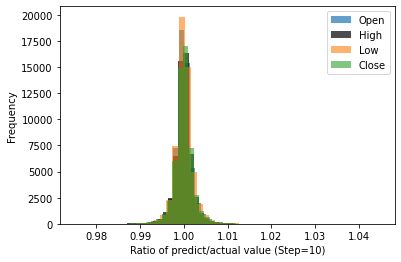

In [251]:
step=10
plt.hist(pre_ohlc[step, :, 0]/ans_ohlc[step, :, 0], bins=50, alpha=0.7)
plt.hist(pre_ohlc[step, :, 1]/ans_ohlc[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(pre_ohlc[step, :, 2]/ans_ohlc[step, :, 2], bins=50, alpha=0.6)
plt.hist(pre_ohlc[step, :, 3]/ans_ohlc[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [260]:
print("==============Mean============")
print("Open", np.mean(pre_ohlc[:, :, 0]/ans_ohlc[:, :, 0], axis=1))
print("High", np.mean(pre_ohlc[:, :, 1]/ans_ohlc[:, :, 1], axis=1))
print("Low", np.mean(pre_ohlc[:, :, 2]/ans_ohlc[:, :, 2], axis=1))
print("Close", np.mean(pre_ohlc[:, :, 3]/ans_ohlc[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(pre_ohlc[:, :, 0]/ans_ohlc[:, :, 0], axis=1))
print("High", np.var(pre_ohlc[:, :, 1]/ans_ohlc[:, :, 1], axis=1))
print("Low", np.var(pre_ohlc[:, :, 2]/ans_ohlc[:, :, 2], axis=1))
print("Close", np.var(pre_ohlc[:, :, 3]/ans_ohlc[:, :, 3], axis=1))

==============Mean============
Open [1.      0.99999 0.99999 0.99999 0.99999 0.99999 0.99999 0.99999 0.99999
 0.99999 0.99999]
High [1.      0.99997 0.99996 0.99996 0.99996 0.99995 0.99995 0.99995 0.99994
 0.99994 0.99994]
Low [1.      1.00001 1.00002 1.00002 1.00003 1.00003 1.00003 1.00004 1.00004
 1.00004 1.00004]
Close [1.      0.99999 0.99999 0.99999 0.99999 0.99999 0.99999 0.99999 0.99999
 0.99999 0.99999]
==============Var============
Open [0.00000e+00 4.84744e-09 1.99264e-07 8.06842e-07 1.42239e-06 2.04416e-06
 2.64299e-06 3.27598e-06 3.86425e-06 4.49557e-06 5.09201e-06]
High [0.00000e+00 1.01483e-07 4.68815e-07 1.04317e-06 1.64725e-06 2.22225e-06
 2.81877e-06 3.42066e-06 4.03041e-06 4.62481e-06 5.22323e-06]
Low [0.00000e+00 1.09437e-07 6.08663e-07 1.29797e-06 1.94248e-06 2.56723e-06
 3.22306e-06 3.82625e-06 4.44855e-06 5.09799e-06 5.69174e-06]
Close [0.00000e+00 1.88493e-07 7.96491e-07 1.41001e-06 2.03399e-06 2.62985e-06
 3.26481e-06 3.85286e-06 4.48326e-06 5.08304e-06 5.69491e

[]

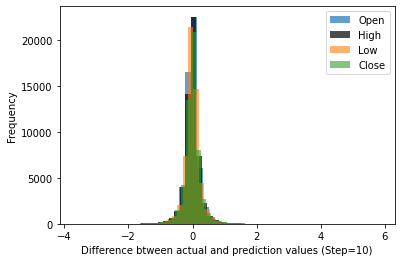

In [254]:
step=10
plt.hist(pre_ohlc[step, :, 0] - ans_ohlc[step, :, 0], bins=50, alpha=0.7)
plt.hist(pre_ohlc[step, :, 1] - ans_ohlc[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(pre_ohlc[step, :, 2] - ans_ohlc[step, :, 2], bins=50, alpha=0.6)
plt.hist(pre_ohlc[step, :, 3] - ans_ohlc[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [259]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(pre_ohlc[:, :, 0]-ans_ohlc[:, :, 0], axis=1))
print("High", np.mean(pre_ohlc[:, :, 1]-ans_ohlc[:, :, 1], axis=1))
print("Low", np.mean(pre_ohlc[:, :, 2]-ans_ohlc[:, :, 2], axis=1))
print("Close", np.mean(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(pre_ohlc[:, :, 0]-ans_ohlc[:, :, 0], axis=1))
print("High", np.var(pre_ohlc[:, :, 1]-ans_ohlc[:, :, 1], axis=1))
print("Low", np.var(pre_ohlc[:, :, 2]-ans_ohlc[:, :, 2], axis=1))
print("Close", np.var(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.00056 -0.00172 -0.00167 -0.00117 -0.00116 -0.00107 -0.00148
 -0.00142 -0.00158 -0.00161]
High [ 0.      -0.00318 -0.00531 -0.00524 -0.00522 -0.00558 -0.00598 -0.00658
 -0.00692 -0.00739 -0.0077 ]
Low [0.      0.00157 0.00253 0.00307 0.00363 0.00405 0.00401 0.0044  0.00455
 0.00483 0.0051 ]
Close [ 0.      -0.00134 -0.00128 -0.00077 -0.00074 -0.00067 -0.00106 -0.00101
 -0.00116 -0.00118 -0.00122]
==============Var============
Open [0.00000e+00 6.31997e-05 2.55791e-03 1.16527e-02 2.09503e-02 3.03806e-02
 3.93685e-02 4.89209e-02 5.77479e-02 6.72142e-02 7.61691e-02]
High [0.      0.00133 0.00652 0.01509 0.02418 0.03287 0.04182 0.05095 0.0601
 0.06901 0.07807]
Low [0.      0.00143 0.00885 0.01931 0.02906 0.03844 0.04832 0.05733 0.06665
 0.07639 0.08525]
Close [0.      0.00242 0.01152 0.02079 0.03025 0.0392  0.04879 0.05761 0.06707
 0.07606 0.08529]


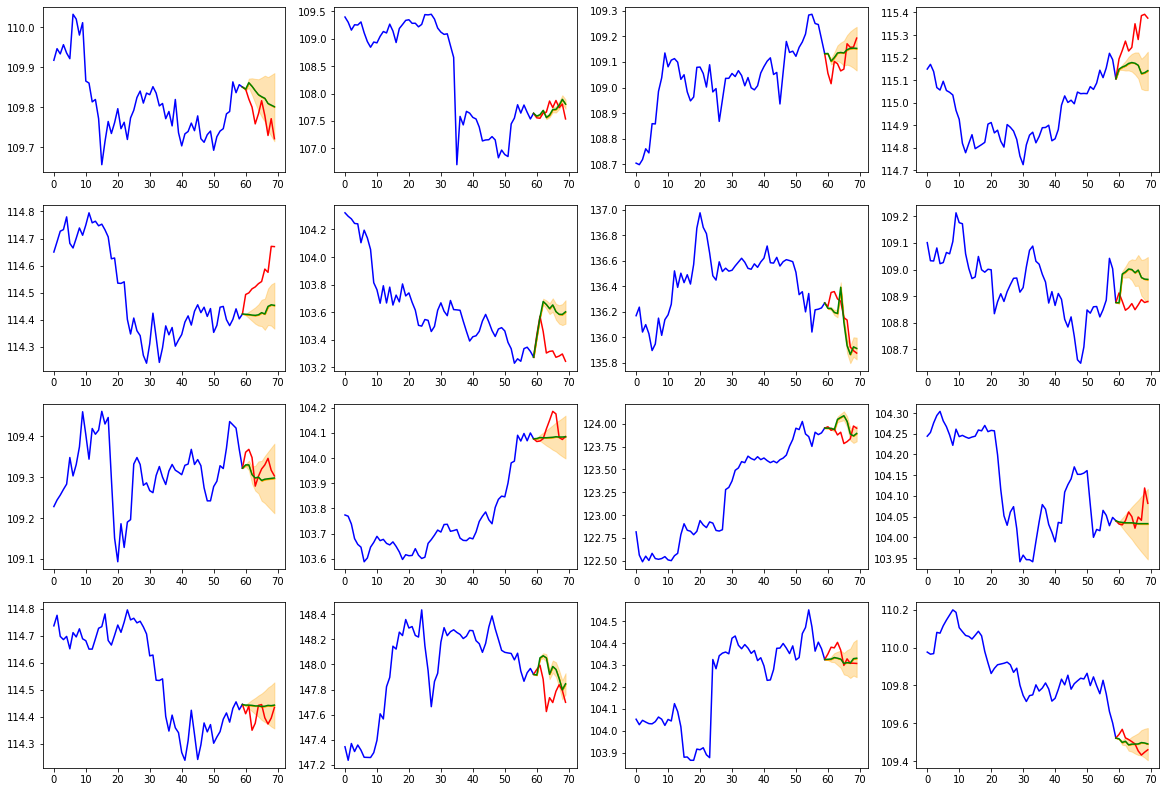

: 

In [262]:
ans_df = DFS[BIAS]

close_mean = np.mean(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=1)
close_var =  np.var(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=1)

fig, axs = plt.subplots(4, 4, figsize=(20, 14))
x = np.arange(70)

for i, ax in enumerate(axs.flat):
    # add 1 to ajust index removed by diff
    org_index = ds.eval_indices[i] + 1
    original_close = ans_df[ohlc_column[3]].iloc[org_index: org_index + observation_length]
    pred_value = pre_ohlc[:, i, 3]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[59:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[59:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:60], original_close, color="blue")
    ax.plot(x[59:], ans_ohlc[:, i, 3], color="red")
    ax.plot(x[59:], pred_value, color="green")
    
plt.savefig(f"finance_did_pl_transfomer_shift2.png")

## Transformer with Close Diff ID Dataset

Above models go bankrupt when a value not found in train data exist.
Try to apply pretraining for numerical prediction.

### Define Dataset

In [56]:
import random
import numpy as np
import torch


class CloseDiffIDDS:
    
    def __init__(self, df, close_column, observation_length=60,
                device="cuda", prediction_length=10, seed=1017, is_training = True, amplify=2, decimal_digits=3):
        self.seed(seed)
        self.columns = close_column
        self.ohlc_idf = self.__init_ohlc(df, decimal_digits=decimal_digits, amplify=amplify)
        self.observation_length = observation_length
        self.device = device
        self.prediction_length = prediction_length
        self.is_training = is_training
        self.__init_indicies(self.ohlc_idf)
        
    
    def __init_indicies(self, data, split_ratio=0.8):
        length = len(data.index) - self.observation_length - self.prediction_length
        to_index = int(length * split_ratio)
        from_index = 0
        train_indices = list(range(from_index, to_index))
        self.train_indices = random.sample(train_indices, k=to_index - from_index)
 
        # Note: If unique value exits in validation data only, validation loss would be grater than expected
        from_index = int(length * split_ratio) + self.observation_length + self.prediction_length
        to_index = length
        eval_indices = list(range(from_index, to_index))
        self.eval_indices = random.sample(eval_indices, k=to_index - from_index)
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.eval_indices
    
    def revert_diff(self, prediction, ndx, last_close_value=None):
        if last_close_value is None:
            if type(ndx) is int:
                target_index = self._indices[ndx] + self.observation_length - 1
                #close.iloc[index - 1] + ohlc.iloc[index]. As index=0 was dropped, index of dataset equal index + 1 of original data
                last_close = df[self.columns[3]].iloc[target_index]
            else:
                target_index = [self._indices[index] + self.observation_length - 1 for index in ndx]
                batch_size = len(ndx)
                last_close = df[self.columns[3]].iloc[target_index].values.reshape(batch_size, 1)
            return last_close + prediction
            
        else:
            return last_close_value + prediction
    
    def revert(self, diff):
        pass
    
    def __init_ohlc(self, df, decimal_digits = 3, amplify=2):
        diff_df = df[self.columns].diff().iloc[1:]
        max_value = diff_df.abs().max()
        
        # amplify for prtraining
        #lower_value = lower_value * amplify
        max_value = int( math.ceil(max_value) * (10 ** decimal_digits) * amplify)
        id_df =  diff_df * 10 ** decimal_digits + max_value
        self.ohlc_lower = max_value
        id_df = id_df.astype('int64')
        self.ohlc_range_size = max_value * 2
        return id_df
    
    def __get_data_set(self, idx):
        ohlc_ids = self.ohlc_idf.iloc[idx].values.tolist()
        return ohlc_ids
    
    def _output_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index + self.observation_length -1, index + self.observation_length + self.prediction_length)
            ohlc_ids = self.__get_data_set(idx)
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int)
            
            return ohlc_ids
        elif type(batch_size) == slice:    
            ohlc_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index + self.observation_length -1, index + self.observation_length + self.prediction_length)
                ohlc_ids = self.__get_data_set(idx)                
                ohlc_chunk_data.append(ohlc_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int)
            return ohlc_ids.transpose(0, 1)
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index, index + self.observation_length)
            ohlc_ids = self.__get_data_set(idx)            
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int)
            
            return ohlc_ids
        elif type(batch_size) == slice:
            ohlc_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index, index + self.observation_length)
                ohlc_ids = self.__get_data_set(idx)
                ohlc_chunk_data.append(ohlc_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int)
            return ohlc_ids.transpose(0, 1)
    
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def seed(self, seed=None):
        '''
        '''
        if seed == None:
            seed = 1192
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed
            
    def eval(self):
        self._indices = self.eval_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = False

In [57]:
amplify=2
decimal_digits = 3

ds = CloseDiffIDDS(df, ohlc_column[3], amplify=amplify, decimal_digits=decimal_digits)

In [58]:
import numpy as np

class RandomMathDataset:
    
    def __init__(self, min_value, max_value, amplify, observation_length, device="cuda", length=None, method="sum") -> None:
        self.min_value = int(min_value)
        self.max_value = int(max_value - self.min_value)
        self.rand_min = int(min_value/amplify)
        self.rand_max = int(max_value/amplify)
        self.amplify = amplify
        if length is None:
            length = max_value * abs(min_value)
        self.length = length
        self.observation_length = observation_length
        self.device = device
        self.is_training = True
        if method.lower() == "sum":
            self.__get_method = self.get_sum
        elif method.lower() == "diff":
            self.__get_method = self.get_diff
        else:
            raise ValueError(f"{method} is not supported")
    
    def get_diff(self, ndx):
        batch_size = 1
        if type(ndx) is int:
            src = np.random.randint(self.rand_min, self.rand_max, size=(self.observation_length, batch_size))
        else:
            batch_size = ndx.stop - ndx.start
            src = np.random.randint(self.rand_min, self.rand_max, size=(self.observation_length, batch_size))
            
        tgt = src[1:, :] - src[:-1, :]
        src += abs(self.min_value)
        tgt += abs(self.min_value)
        tgt = np.concatenate([np.zeros((1, tgt.shape[1])), tgt], axis=0)
        positions = torch.arange(0, self.observation_length, 1, dtype=torch.int).reshape(self.observation_length, 1).repeat(1, batch_size).to(self.device)
        return (
            torch.tensor(src, device=self.device, dtype=torch.int),
            torch.tensor(tgt, device=self.device, dtype=torch.int),
            positions
        )
        
    def get_sum(self, ndx):
        batch_size = 1
        if type(ndx) is int:
            src = np.random.randint(self.rand_min, self.rand_max, size=(self.observation_length, batch_size))
        else:
            batch_size = ndx.stop - ndx.start
            src = np.random.randint(self.rand_min, self.rand_max, size=(self.observation_length, batch_size))
        tgt = src[:-1, :] + src[1:, :]
        positions = torch.arange(0, self.observation_length, 1, dtype=torch.int).reshape(self.observation_length, 1).repeat(1, batch_size).to(self.device)
        src += abs(self.min_value)
        tgt += abs(self.min_value)
        tgt = np.concatenate([np.zeros((1, tgt.shape[1])), tgt], axis=0)
        return (
            torch.tensor(src, device=self.device, dtype=torch.int),
            torch.tensor(tgt, device=self.device, dtype=torch.int),
            positions
        )
        
    def __getitem__(self, ndx):
        return self.__get_method(ndx)
        
    def __len__(self):
        if self.is_training:
            return self.length
        else:
            return int(self.length * 0.2)
    
    def to(self, device):
        self.device = device
    
    def train(self):
        self.is_training = True
        
    def eval(self):
        self.is_training = False

In [61]:
pds = RandomMathDataset(-ds.ohlc_lower, ds.ohlc_range_size - ds.ohlc_lower, observation_length=60, amplify=amplify, method="diff")

### Define Model

In [62]:
class PositionalEncoding(nn.Module):
    def __init__(self, position_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(position_size, d_model)

    def forward(self, position_ids):
        position = self.pe(position_ids)
        return position

In [63]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int, observation_length: int, prediction_length: int, 
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8,
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim = d_model)
        self.ohlc_positional_encoding = PositionalEncoding(observation_length + prediction_length, d_model)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.output_layer = nn.Linear(d_model, ohlc_size)
        

    def forward(
        self, src: Tensor, tgt: Tensor, src_pos: Tensor, tgt_pos: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        pos = self.ohlc_positional_encoding(src_pos)
        src = self.ohlc_embedded_layer(src)
        src = src + pos
        
        pos = self.ohlc_positional_encoding(tgt_pos)
        tgt = self.ohlc_embedded_layer(tgt)
        tgt = tgt + pos
                
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        output = self.output_layer(outs)
        
        return output

### Define Training

In [83]:
def train(model, ds, optimizer, criterion, batch_size, vocab_size):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index - batch_size, batch_size)):
        length+=1.0
        src, tgt, positions = ds[index:index+batch_size]
        
        in_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_tgt.size(0)).to(device)
        logits  = model(
            src=src, tgt=in_tgt, src_pos=positions, tgt_pos=positions[:-1, :],
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_tgt = tgt[1:, :].to(torch.int64)
        out_tgt = torch.nn.functional.one_hot(out_tgt, num_classes=vocab_size).to(torch.float32)
        
        optimizer.zero_grad()

        loss = criterion(logits, out_tgt)
        
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [75]:
def evaluate(model, ds, criterion, batch_size, vocab_size):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt, positions = ds[index:index+batch_size]
        
        in_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_tgt.size(0)).to(device)
        logits  = model(
            src=src, tgt=in_tgt, src_pos=positions, tgt_pos=positions[:-1, :],
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_tgt = tgt[1:, :].to(torch.int64)
        out_tgt = torch.nn.functional.one_hot(out_tgt, num_classes=vocab_size).to(torch.float32)
        
        optimizer.zero_grad()

        loss = criterion(logits, out_tgt)
        losses += loss.item()
        
    return losses / length

### Pretraining 1

In [79]:
device = "cuda"
pds.to(device)

nhead = 4
d_model = 124
dim_feedforward = 1000
num_encoder_layers = 12
num_decoder_layers = 12
feature_size = 1
dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model, ohlc_size = ds.ohlc_range_size, observation_length=60, prediction_length=10,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [80]:
lr = 0.001
batch_size = 64

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.90)

In [81]:
import json
import logging

model_name = "finance_did_transfomer_close_p1"
model_version = 1

log_file_path = f"{model_name}_{model_version}.log"
#log_file_path = f"{model_name}_{model_version}.log"
logging.basicConfig(
    filename= log_file_path,
    level=logging.INFO,
    format="[%(levelname)s],%(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    force=True
)
logger = logging.getLogger(model_name)

params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()

params = {"processes": [ ],
          "source": file_path,
          "features": ohlc_column[3],
          "batch_size": batch_size,
          "observation_length": 60,
          "prediction_length": 10,
          "nhead": nhead,
          "dim_feedforward": dim_feedforward,
          "num_encoder_layers": num_encoder_layers,
          "num_decoder_layers": num_decoder_layers,
          "dropout": dropout,
          "params_num": params
}

param_file_path = f"{model_name}_{model_version}_params.json"
with open(param_file_path, mode="w") as fp:
  json.dump(params, fp)

print("saved params on ", param_file_path)
print("training log will be saved on ", log_file_path)

saved params on  finance_did_transfomer_close_p1_1_params.json
training log will be saved on  finance_did_transfomer_close_p1_1.log


In [85]:
pds = RandomMathDataset(-ds.ohlc_lower, ds.ohlc_range_size - ds.ohlc_lower, observation_length=60, amplify=amplify, method="diff", length=50000)

In [70]:
while True:
    src, tgt, positions = pds[0:128]
    if len(src[src < 0]) > 0:
        print("src has minus value")
        break
    if len(tgt[tgt < 0]) > 0:
        print("tgt has minus value")
        break
    if len(src[src > 12000]) > 0:
        print("src has too large value")
        break
    if len(tgt[tgt > 12000]) > 0:
        print("tgt has too large value")
        break

KeyboardInterrupt: 

In [87]:
epoch = 30
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=pds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        vocab_size=ds.ohlc_range_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=pds, criterion=criterion,batch_size=batch_size,vocab_size=ds.ohlc_range_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    logger.info(f"{loss_train}, {loss_valid}, {elapsed_time}")
    
    if best_loss > loss_train:
        best_loss = loss_train
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 781/781 [02:29<00:00,  5.21it/s]


[1/30] train loss: 0.0221808351, valid loss: 0.0221807097  30s] count: 0, **


100%|██████████| 781/781 [02:25<00:00,  5.35it/s]


[2/30] train loss: 0.0221807924, valid loss: 0.0221807097  26s] count: 0, **


100%|██████████| 781/781 [02:27<00:00,  5.31it/s]


[3/30] train loss: 0.0221807904, valid loss: 0.0221807097  27s] count: 0, **


100%|██████████| 781/781 [02:19<00:00,  5.60it/s]


[4/30] train loss: 0.0221807635, valid loss: 0.0221807097  20s] count: 0, **


100%|██████████| 781/781 [02:21<00:00,  5.51it/s]


[5/30] train loss: 0.0221807731, valid loss: 0.0221807097  22s] count: 0, **


100%|██████████| 781/781 [02:13<00:00,  5.84it/s]


[6/30] train loss: 0.0221807331, valid loss: 0.0221807097  14s] count: 1, **


100%|██████████| 781/781 [02:21<00:00,  5.53it/s]


[7/30] train loss: 0.0221807261, valid loss: 0.0221807097  21s] count: 0, **


100%|██████████| 781/781 [02:16<00:00,  5.70it/s]


[8/30] train loss: 0.0221807557, valid loss: 0.0221807097  17s] count: 0, **


100%|██████████| 781/781 [02:26<00:00,  5.34it/s]


[9/30] train loss: 0.0221807352, valid loss: 0.0221807096  26s] count: 1, **


100%|██████████| 781/781 [02:23<00:00,  5.43it/s]


[10/30] train loss: 0.0221807321, valid loss: 0.0221807097  24s] count: 2, **


100%|██████████| 781/781 [02:10<00:00,  5.97it/s]


[11/30] train loss: 0.0221807294, valid loss: 0.0221807096  11s] count: 3, **


100%|██████████| 781/781 [02:10<00:00,  5.97it/s]


[12/30] train loss: 0.0221807387, valid loss: 0.0221807097  11s] count: 4, **


100%|██████████| 781/781 [02:09<00:00,  6.01it/s]


[13/30] train loss: 0.0221807219, valid loss: 0.0221807097  10s] count: 5, **


100%|██████████| 781/781 [02:09<00:00,  6.03it/s]


[14/30] train loss: 0.0221807253, valid loss: 0.0221807097  10s] count: 0, **


100%|██████████| 781/781 [02:09<00:00,  6.02it/s]


[15/30] train loss: 0.0221807313, valid loss: 0.0221807097  10s] count: 1, **


100%|██████████| 781/781 [02:07<00:00,  6.10it/s]


[16/30] train loss: 0.0221807060, valid loss: 0.0221807096  8s] count: 2, **


100%|██████████| 781/781 [02:08<00:00,  6.09it/s]


[17/30] train loss: 0.0221807208, valid loss: 0.0221807097  8s] count: 0, 


100%|██████████| 781/781 [02:09<00:00,  6.04it/s]


[18/30] train loss: 0.0221807254, valid loss: 0.0221807096  9s] count: 1, 


100%|██████████| 781/781 [02:07<00:00,  6.14it/s]


[19/30] train loss: 0.0221807188, valid loss: 0.0221807097  7s] count: 2, 


100%|██████████| 781/781 [02:09<00:00,  6.05it/s]


[20/30] train loss: 0.0221807172, valid loss: 0.0221807097  9s] count: 3, 


100%|██████████| 781/781 [02:09<00:00,  6.04it/s]


[21/30] train loss: 0.0221807264, valid loss: 0.0221807096  9s] count: 4, 


100%|██████████| 781/781 [02:09<00:00,  6.05it/s]


[22/30] train loss: 0.0221807113, valid loss: 0.0221807096  9s] count: 5, 


100%|██████████| 781/781 [02:08<00:00,  6.06it/s]


[23/30] train loss: 0.0221807165, valid loss: 0.0221807098  9s] count: 6, 


100%|██████████| 781/781 [02:06<00:00,  6.18it/s]


[24/30] train loss: 0.0221807141, valid loss: 0.0221807096  6s] count: 7, 


100%|██████████| 781/781 [02:09<00:00,  6.05it/s]


[25/30] train loss: 0.0221807171, valid loss: 0.0221807097  9s] count: 8, 


100%|██████████| 781/781 [02:09<00:00,  6.01it/s]


[26/30] train loss: 0.0221807125, valid loss: 0.0221807096  10s] count: 9, 


100%|██████████| 781/781 [02:12<00:00,  5.87it/s]


[27/30] train loss: 0.0221807186, valid loss: 0.0221807097  13s] count: 10, 


## Meaningful Tokenizer

In [ ]:
import pandas as pd

df = pd.read_csv("./mt5_USDJPY_min30.csv", parse_dates=True, index_col=0)

### Define Dataset

In [ ]:
import random
import numpy as np
import torch


class DiffTokenIDDS:
    
    def __init__(self, df, column="close", observation_length=60, prediction_length=10,
                dicimal=3, device="cuda", seed=1017, is_training = True):
        self.seed(seed)
        self.columns = column
        token_array = ["<pad>", "<s>", "<e>", "+", "-", "n", ".", *[str(value) for value in range(21)]]
        self.src_max_length = 6*observation_length + 2
        self.tgt_max_length = 6*(prediction_length + 1) + 2
        self.vocab = {token: index for index, token in enumerate(token_array)}
        self.observation_length = observation_length
        self.device = device
        self.future_step_size = prediction_length
        self.is_training = is_training
        self.data = self.__init_df(df, column, dicimal)
        self.__init_indicies(self.data)
        
    
    def __init_indicies(self, data, split_ratio=0.7):
        length = len(data) - self.observation_length - self.future_step_size
        if length < 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")
        
        indices = random.sample(range(0, length), k=length)

        if self.is_training:
            from_index = 1#avoid diff nan
            to_index = int(length*split_ratio)
        else:
            from_index = int(length*split_ratio)+1
            to_index = length
        
        self._indices = indices[from_index:to_index]
        self._entire_indices = indices
    
    def revert(self, diff):
        pass

    def tokenizer(self, sentence, max_length=1000):
        tokens = [self.vocab["<s>"]]
        tokens += [self.vocab[value] for value in sentence]
        if len(tokens) < max_length:
            tokens += [self.vocab["<pad>"]] * (max_length - len(tokens))
        tokens += [self.vocab["<e>"]]
        return tokens

    def pre_tokenizer(self, int_df, squeeze=False):
        if squeeze:
            print("squeeze=True is not implemented yet")
        value_str_array = []
        for srs in int_df.iloc:
            value = srs.close
            base = srs.base

            if pd.isna(value):
                value_str_array = ["n"]
                continue
            
            value = int(value)
            if value == 0:
                value_str_array.append("0")
            else:
                if base == "1":
                    value_str_array.append(".")
                else:
                    for unit in base.split("."):
                        value_str_array.append(".")

                if value > 0:
                    value_str_array.append("+")
                elif value < 0:
                    value_str_array.append("-")
                    
                value_str = str(abs(value))
                value_str_array.append(value_str)
        return value_str_array

    def split_decimal_number(self, df, digit=3, factor=2):
        columns = df.name
        
        temp_int_df = df[df==0]
        operated_index = temp_int_df.index
        temp_int_df = pd.concat([temp_int_df, pd.Series("", index=temp_int_df.index)], axis=1, keys=[columns, "base"])
        int_dfs = [temp_int_df]
        
        for d in range(digit+1):
            temp_int_df = df[~df.index.isin(operated_index)]
            temp_int_df = temp_int_df * (10 ** d)
            temp_int_df = (temp_int_df[temp_int_df.abs() >= 1] * factor).round()
            temp_int_df = pd.concat([temp_int_df, pd.Series("."*d, index=temp_int_df.index)], axis=1, keys=[columns, "base"])
            operated_index = operated_index.append(temp_int_df.index)
            int_dfs.append(temp_int_df)
        temp_int_df = df[~df.index.isin(operated_index)]
        temp_int_df = pd.concat([temp_int_df, pd.Series(".", index=temp_int_df.index)], axis=1, keys=[columns, "base"])
        int_dfs.append(temp_int_df)
        int_df = pd.concat(int_dfs, axis=0)
        return int_df.sort_index()
    
    def __init_df(self, df, column, decimal_digits = 3):
        diff_df = df[column].diff()
        int_df = self.split_decimal_number(diff_df, digit=decimal_digits)
        return int_df

    def _output_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index + self.observation_length, index + self.observation_length + self.future_step_size)
            ids = self.data.iloc[idx]
            ids = self.tokenizer(self.pre_tokenizer(ids), self.tgt_max_length)
            ohlc_ids = torch.tensor(ids, device=self.device, dtype=torch.int)
            
            return ohlc_ids
        elif type(batch_size) == slice:    
            ohlc_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index + self.observation_length, index + self.observation_length + self.future_step_size)
                ids = self.data.iloc[idx]
                ids = self.tokenizer(self.pre_tokenizer(ids), self.tgt_max_length)
                ohlc_chunk_data.append(ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int64)
            return ohlc_ids.transpose(0, 1)
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index, index + self.observation_length)
            ids = self.data.iloc[ndx]
            ids = self.tokenizer(self.pre_tokenizer(ids), self.src_max_length)
            ids = torch.tensor(ids, device=self.device, dtype=torch.int)
            
            return ids
        elif type(batch_size) == slice:
            ohlc_chunk_data = []
            
            for index in self._indices[batch_size]:
                ndx = slice(index, index + self.observation_length)
                ids = self.data.iloc[ndx]
                ids = self.tokenizer(self.pre_tokenizer(ids), self.src_max_length)
                ohlc_chunk_data.append(ids)

            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int64)
            return ohlc_ids.transpose(0, 1)
    
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def seed(self, seed=None):
        '''
        '''
        if seed == None:
            seed = 1192
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed
            
    def eval(self):
        split_ratio = 0.7
        length = len(self._entire_indices)
        from_index = int(length*split_ratio)+1
        to_index = length
        self._indices = self._entire_indices[from_index:to_index]
        self.is_training = False
        
    def train(self):
        split_ratio = 0.7
        length = len(self._entire_indices)
        from_index = 0
        to_index = int(length*split_ratio)
        self._indices = self._entire_indices[from_index:to_index]
        self.is_training = False

In [ ]:
ds = DiffTokenIDDS(df, device="cpu")

C:\Users\s138277\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\random.py:46: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)
  return default_generator.manual_seed(seed)


In [ ]:
batch_size = 32

for i in range(0, len(ds)-batch_size, batch_size):
    src, tgt = ds[i:i+batch_size]
print(src.shape, tgt.shape)

In [ ]:
ds.eval()

for i in range(0, len(ds)-batch_size, batch_size):
    src, tgt = ds[i:i+batch_size]
print(src.shape, tgt.shape)

### Define Model

In [ ]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src):
        src_pos = src.size(1)
        return self.dropout(torch.add(src, self.pe[:src_pos, :]))

In [ ]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim = d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.output_layer = nn.Linear(d_model, vocab_size)
        self.activation = nn.Softmax(dim=2)
        

    def forward(
        self, src: Tensor, tgt: Tensor, 
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        src = self.ohlc_embedded_layer(src)
        tgt = self.ohlc_embedded_layer(tgt)
        
        src = self.positional_encoding(src)
        tgt = self.positional_encoding(tgt)

        memory = self.transformer_encoder(src, mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        logits = self.output_layer(outs)
        
        return logits

### Define Training

In [ ]:
def train(model, ds, optimizer, criterion, batch_size, vocab_size):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index - batch_size, batch_size)):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        
        in_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_tgt.size(0)).to(device)
        logits  = model(
            src=src, tgt=in_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_tgt = tgt[1:, :]
        out_tgt = torch.nn.functional.one_hot(out_tgt, num_classes=vocab_size).to(torch.float32)
        
        optimizer.zero_grad()

        loss = criterion(logits, out_tgt)
        
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [ ]:
def evaluate(model, ds, criterion, batch_size, vocab_size):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        
        in_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_tgt.size(0)).to(device)
        logits  = model(
            src=src, tgt=in_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_tgt = tgt[1:, :]
        out_tgt = torch.nn.functional.one_hot(out_tgt, num_classes=vocab_size).to(torch.float32)
        
        optimizer.zero_grad()

        loss = criterion(logits, out_tgt)
        losses += loss.item()
        
    return losses / length

### Train

In [ ]:
device = "cuda"
ds = DiffTokenIDDS(df, device=device)

nhead = 4
d_model = 12
dim_feedforward = 1000
num_encoder_layers = 12
num_decoder_layers = 12
feature_size = 1
dropout = 0.001
vocab_size = len(ds.vocab)

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    vocab_size=vocab_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.001
batch_size = 32

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.90)

In [ ]:
epoch = 30
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        vocab_size=vocab_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size,vocab_size=vocab_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 2201/2201 [18:47<00:00,  1.95it/s]


[1/30] train loss: 3.9611799402, valid loss: 3.9608411898  48s] count: 0, **


100%|██████████| 2201/2201 [18:43<00:00,  1.96it/s]


[2/30] train loss: 3.9608745377, valid loss: 3.9608413941  43s] count: 0, 


100%|██████████| 2201/2201 [18:45<00:00,  1.96it/s]


[3/30] train loss: 3.9608538717, valid loss: 3.9608411733  45s] count: 1, **


100%|██████████| 2201/2201 [18:50<00:00,  1.95it/s]


[4/30] train loss: 3.9608478501, valid loss: 3.9608412927  50s] count: 0, 


100%|██████████| 2201/2201 [18:32<00:00,  1.98it/s]


[5/30] train loss: 3.9608455073, valid loss: 3.9608411536  33s] count: 1, **


100%|██████████| 2201/2201 [18:42<00:00,  1.96it/s]


[6/30] train loss: 3.9608449187, valid loss: 3.9608411842  42s] count: 0, 


100%|██████████| 2201/2201 [18:40<00:00,  1.97it/s]


[7/30] train loss: 3.9608428714, valid loss: 3.9608411379  40s] count: 1, **


100%|██████████| 2201/2201 [18:35<00:00,  1.97it/s]


[8/30] train loss: 3.9608434487, valid loss: 3.9608411352  35s] count: 0, **


100%|██████████| 2201/2201 [18:35<00:00,  1.97it/s]


[9/30] train loss: 3.9608427673, valid loss: 3.9608411458  35s] count: 0, 


100%|██████████| 2201/2201 [18:27<00:00,  1.99it/s]


[10/30] train loss: 3.9608415376, valid loss: 3.9608411354  27s] count: 1, 


100%|██████████| 2201/2201 [18:26<00:00,  1.99it/s]


[11/30] train loss: 3.9608424271, valid loss: 3.9608411352  27s] count: 2, 


100%|██████████| 2201/2201 [18:29<00:00,  1.98it/s]


[12/30] train loss: 3.9608420202, valid loss: 3.9608411369  30s] count: 3, 


100%|██████████| 2201/2201 [18:26<00:00,  1.99it/s]


[13/30] train loss: 3.9608414593, valid loss: 3.9608411349  26s] count: 4, **


100%|██████████| 2201/2201 [18:33<00:00,  1.98it/s]


[14/30] train loss: 3.9608417595, valid loss: 3.9608411344  33s] count: 0, **


100%|██████████| 2201/2201 [18:36<00:00,  1.97it/s]


[15/30] train loss: 3.9608414695, valid loss: 3.9608411346  37s] count: 0, 


100%|██████████| 2201/2201 [18:34<00:00,  1.97it/s]


[16/30] train loss: 3.9608423975, valid loss: 3.9608411855  35s] count: 1, 


100%|██████████| 2201/2201 [18:49<00:00,  1.95it/s]


[17/30] train loss: 3.9608417585, valid loss: 3.9608411349  50s] count: 2, 


 33%|███▎      | 737/2201 [06:30<12:56,  1.89it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.save(best_model.state_dict(), os.path.join(folder, 'finance_DiffToken_transfomer_v1.torch'))

## Meaning less Tokenizer

### Define Dataset

In [ ]:
import json
import collections

class BytePairTokenizer:

    def __init__(self, token_dict=None) -> None:
        self.bpe_units = [f" {unit}" for unit in range(0, 2**8)]
        self.bpe_units += ["<pad>", "<s>", "<e>"]
        if token_dict is not None:
            self.token_dict = token_dict
        else:
            self.token_dict = None
            print("please use create_vocab to initialize token_dict")

    def create_vocab(self, df, num_merges=10000, minimum_pair_count=100, minimum_token_length=10000):
        i = 0
        tokens = self.to_byte_array(df)
        # apply BPE
        while i < num_merges or len(set(tokens)) < minimum_token_length:
            pairs = collections.defaultdict(int)
            for j in range(len(tokens)-1):
                pairs[tuple(tokens[j:j+2])] += 1
            
            if pairs:
                best_pair = max(pairs, key=pairs.get)
                if pairs[best_pair] < minimum_pair_count:
                    print("pair count less than 100")
                    break
                new_tokens = []
                skip = False
                for j in range(len(tokens)-1):
                    if skip:
                        skip = False
                        continue
                    pair = tuple(tokens[j:j+2])
                    if pair == best_pair:
                        new_token = best_pair[0] + best_pair[1]
                        new_tokens.append(new_token)
                        skip = True
                    else:
                        new_tokens.append(tokens[j])
                if not skip:
                    new_tokens.append(tokens[-1])
                
                tokens = new_tokens
            else:
                print("no more pair")
                break
            i+=1
        unique_tokens = set(tokens)
        unique_tokens = unique_tokens | set(self.bpe_units)

        # create token dictionary
        token_dict = {}
        id = 0
        for token in unique_tokens:
            token_dict[token] = id
            id += 1
        self.token_dict = token_dict
    
    def to_byte_array(self, df):
        byte_arr = df.values.tobytes()
        value_units = [self.bpe_units[b] for b in byte_arr]
        return value_units

    def __call__(self, df, length=None):
      return self.tokenize(df, length)

    def tokenize(self, df, length=None):
        tokens = [self.token_dict["<s>"]]
        i = 0
        value_units = self.to_byte_array(df)
        while i < len(value_units):
            token = value_units[i:i+1][0]
            i += 1
            while i < len(value_units):
                next_token = value_units[i:i+1][0]
                if token + next_token in self.token_dict:
                    token += next_token
                    i += 1
                else:
                    break
            tokens.append(self.token_dict[token])
        tokens.append(self.token_dict["<e>"])
        
        padding_id = self.token_dict["<pad>"]
        while len(tokens) < length-1:
          tokens.append(padding_id)
        return tokens
    
    def save_vocab(self, filename=None):
        if filename is None:
            filename = "./byte_vocab.json"
        with open(filename, mode="w") as fp:
            json.dump(self.token_dict, fp)

In [7]:
import random
import numpy as np
import torch


class DiffByteTokenIDDS:
    
    def __init__(self, df, tokenizer, column="close", observation_length=60, prediction_length=10,
                device="cuda", seed=1017, is_training = True):
        self.seed(seed)
        self.columns = column
        self.src_max_length = 4*2*observation_length
        self.tgt_max_length = 4*2*(prediction_length + 1)
        self.observation_length = observation_length
        self.device = device
        self.future_step_size = prediction_length
        self.is_training = is_training
        self.data = self.__init_df(df, column)
        if tokenizer.token_dict is None:
          tokenizer.create_vocab(self.data)
        self.tokenizer = tokenizer
        self.__init_indicies(self.data)
        
    
    def __init_indicies(self, data, split_ratio=0.7):
        length = len(data) - self.observation_length - self.future_step_size
        if length < 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")
        
        to_index = int(length * split_ratio)
        from_index = 1
        train_indices = list(range(from_index, to_index))
        train_indices = random.sample(train_indices, k=to_index - from_index)

        # Note: If unique value exits in validation data only, validation loss would be grater than expected
        from_index = int(length * split_ratio) + self.observation_length + self.future_step_size
        to_index = length
        eval_indices = list(range(from_index, to_index))
        eval_indices = random.sample(eval_indices, k=to_index - from_index)
        if self.is_training:
          self._indices = train_indices
        else:
          self._indices = eval_indices
        self.train_indices = train_indices
        self.eval_indices = eval_indices
    
    def revert(self, diff):
        pass
    
    def __init_df(self, df, column):
        diff_df = df[column].diff()
        return diff_df

    def _output_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index + self.observation_length, index + self.observation_length + self.future_step_size)
            ids = self.data.iloc[idx]
            ids = self.tokenizer(ids, self.tgt_max_length)
            ohlc_ids = torch.tensor(ids, device=self.device, dtype=torch.int)
            
            return ohlc_ids
        elif type(batch_size) == slice:    
            ohlc_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = slice(index + self.observation_length, index + self.observation_length + self.future_step_size)
                ids = self.data.iloc[idx]
                ids = self.tokenizer(ids, self.tgt_max_length)
                ohlc_chunk_data.append(ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int64)
            return ohlc_ids.transpose(0, 1)
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index, index + self.observation_length)
            ids = self.data.iloc[ndx]
            ids = self.tokenizer(ids, self.src_max_length)
            ids = torch.tensor(ids, device=self.device, dtype=torch.int)
            
            return ids
        elif type(batch_size) == slice:
            ohlc_chunk_data = []
            
            for index in self._indices[batch_size]:
                ndx = slice(index, index + self.observation_length)
                ids = self.data.iloc[ndx]
                ids = self.tokenizer(ids, self.src_max_length)
                ohlc_chunk_data.append(ids)

            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int64)
            return ohlc_ids.transpose(0, 1)
    
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def seed(self, seed=None):
        '''
        '''
        if seed == None:
            seed = 1192
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed
            
    def eval(self):
        self._indices = random.sample(self.eval_indices, k=len(self.eval_indices))
        self.is_training = False

    def train(self):
        self._indices = random.sample(self.train_indices, k=len(self.train_indices))
        self.is_training = True

In [ ]:
import os 
import json

token_dict_file = folder + '/close_diff_30min_vocab.json'

if os.path.exists(token_dict_file):
  with open(token_dict_file, mode="r") as fp:
    token_dict = json.load(fp)
  bpt = BytePairTokenizer(token_dict)
else:
  bpt = BytePairTokenizer()

In [ ]:
s = DiffByteTokenIDDS(df,bpt , column="close", observation_length=60, prediction_length=10,
                device="cuda", seed=1017, is_training = True)

In [ ]:
ds.tokenizer.save_vocab(folder + '/close_diff_30min_vocab.json')

In [ ]:
src, tgt = ds[:16]
src

tensor([[713, 713, 713,  ..., 713, 713, 713],
        [916, 307, 916,  ..., 307, 916, 307],
        [829, 205, 569,  ..., 425, 131, 683],
        ...,
        [521, 521, 521,  ..., 521, 521, 521],
        [521, 521, 521,  ..., 521, 521, 521],
        [809, 809, 809,  ..., 809, 809, 809]], device='cuda:0')

### Define Model

In [24]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)

In [25]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src):
        src_pos = src.size(1)
        return self.dropout(torch.add(src, self.pe[:src_pos, :]))

In [26]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim = d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.output_layer = nn.Linear(d_model, vocab_size)
        self.activation = nn.Softmax(dim=2)
        

    def forward(
        self, src: Tensor, tgt: Tensor, 
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        src = self.ohlc_embedded_layer(src)
        tgt = self.ohlc_embedded_layer(tgt)
        
        src = self.positional_encoding(src)
        tgt = self.positional_encoding(tgt)

        memory = self.transformer_encoder(src, mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        logits = self.output_layer(outs)
        
        return logits

### Define Training

In [27]:
def train(model, ds, optimizer, criterion, batch_size, vocab_size):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index - batch_size, batch_size)):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        
        in_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_tgt.size(0)).to(device)
        logits  = model(
            src=src, tgt=in_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_tgt = tgt[1:, :]
        out_tgt = torch.nn.functional.one_hot(out_tgt, num_classes=vocab_size).to(torch.float32)
        
        optimizer.zero_grad()

        loss = criterion(logits, out_tgt)
        
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [28]:
def evaluate(model, ds, criterion, batch_size, vocab_size):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        
        in_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_tgt.size(0)).to(device)
        logits  = model(
            src=src, tgt=in_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        out_tgt = tgt[1:, :]
        out_tgt = torch.nn.functional.one_hot(out_tgt, num_classes=vocab_size).to(torch.float32)
        
        optimizer.zero_grad()

        loss = criterion(logits, out_tgt)
        losses += loss.item()
        
    return losses / length

### Train

In [ ]:
len(ds.tokenizer.token_dict)

936

In [ ]:
device = "cuda"

nhead = 4
d_model = 60
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
feature_size = 1
dropout = 0.001
vocab_size = len(ds.tokenizer.token_dict)

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    vocab_size=vocab_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.001
batch_size = 32

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.90)

In [ ]:
epoch = 30
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        vocab_size=vocab_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size,vocab_size=vocab_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 2201/2201 [07:13<00:00,  5.07it/s]


[1/30] train loss: 0.0623030624, valid loss: 0.0620844394  14s] count: 0, **


100%|██████████| 2201/2201 [07:10<00:00,  5.11it/s]


[2/30] train loss: 0.0620579351, valid loss: 0.0619376595  11s] count: 0, **


100%|██████████| 2201/2201 [07:11<00:00,  5.10it/s]


[3/30] train loss: 0.0619280956, valid loss: 0.0618976566  11s] count: 0, **


100%|██████████| 2201/2201 [07:11<00:00,  5.10it/s]


[4/30] train loss: 0.0618434090, valid loss: 0.0618146763  12s] count: 0, **


100%|██████████| 2201/2201 [07:12<00:00,  5.09it/s]


[5/30] train loss: 0.0617859891, valid loss: 0.0617717675  12s] count: 0, **


100%|██████████| 2201/2201 [07:11<00:00,  5.10it/s]


[6/30] train loss: 0.0617302796, valid loss: 0.0617569233  12s] count: 0, **


100%|██████████| 2201/2201 [07:12<00:00,  5.09it/s]


[7/30] train loss: 0.0616846733, valid loss: 0.0617328006  12s] count: 0, **


100%|██████████| 2201/2201 [07:12<00:00,  5.09it/s]


[8/30] train loss: 0.0616449259, valid loss: 0.0619442382  13s] count: 0, 


100%|██████████| 2201/2201 [07:15<00:00,  5.06it/s]


[9/30] train loss: 0.0615885381, valid loss: 0.0617299949  15s] count: 1, **


100%|██████████| 2201/2201 [07:12<00:00,  5.09it/s]


[10/30] train loss: 0.0615582091, valid loss: 0.0616616714  13s] count: 0, **


100%|██████████| 2201/2201 [07:12<00:00,  5.09it/s]


[11/30] train loss: 0.0615293543, valid loss: 0.0617592358  12s] count: 0, 


100%|██████████| 2201/2201 [07:10<00:00,  5.11it/s]


[12/30] train loss: 0.0614791428, valid loss: 0.0617446630  11s] count: 1, 


100%|██████████| 2201/2201 [07:12<00:00,  5.09it/s]


[13/30] train loss: 0.0614358526, valid loss: 0.0617988271  12s] count: 2, 


100%|██████████| 2201/2201 [07:12<00:00,  5.09it/s]


[14/30] train loss: 0.0613945213, valid loss: 0.0617167878  12s] count: 3, 


100%|██████████| 2201/2201 [07:12<00:00,  5.08it/s]


[15/30] train loss: 0.0613502521, valid loss: 0.0618336959  13s] count: 4, 


100%|██████████| 2201/2201 [07:11<00:00,  5.10it/s]


[16/30] train loss: 0.0613099250, valid loss: 0.0618056008  12s] count: 5, 


100%|██████████| 2201/2201 [07:12<00:00,  5.09it/s]


[17/30] train loss: 0.0612713121, valid loss: 0.0619154273  12s] count: 6, 


100%|██████████| 2201/2201 [07:11<00:00,  5.10it/s]


[18/30] train loss: 0.0612336787, valid loss: 0.0618101781  12s] count: 7, 


100%|██████████| 2201/2201 [07:11<00:00,  5.10it/s]


[19/30] train loss: 0.0612026824, valid loss: 0.0619289824  12s] count: 8, 


100%|██████████| 2201/2201 [07:11<00:00,  5.10it/s]


[20/30] train loss: 0.0611676433, valid loss: 0.0618898567  11s] count: 9, 


100%|██████████| 2201/2201 [07:11<00:00,  5.11it/s]


[21/30] train loss: 0.0611361881, valid loss: 0.0619954372  11s] count: 10, 


In [ ]:
torch.save(best_model.state_dict(), os.path.join(folder, 'finance_DiffBinaryToken_transfomer_v1.torch'))

In [ ]:
model.load_state_dict(torch.load(os.path.join(folder, 'finance_DiffBinaryToken_transfomer_v1.torch')))

<All keys matched successfully>

## Binary Tokenizer

In [ ]:
import pandas as pd

df = pd.read_csv("./mt5_USDJPY_min30.csv", parse_dates=True, index_col=0)

In [5]:
import struct


class ByteTokenizer:

    def __init__(self, byte_num=1) -> None:
        self.byte_num = byte_num
        # assume np.dtype == np.float64
        if self.byte_num == 2:
            self.byte_to_id = lambda x: struct.unpack('<H', x)[0]
        elif self.byte_num == 4:
            self.byte_to_id = lambda x: struct.unpack('<I', x)[0]
        elif self.byte_num == 8:
            self.byte_to_id = lambda x: struct.unpack('<Q', x)[0]
        else:
            self.byte_to_id = lambda x: x[0]
            self.byte_num = 1
        sp_id_base = 2**(self.byte_num*8)
        self.token_dict = {
             "<s>": (sp_id_base + 1),
            "<e>": (sp_id_base + 2),
            "<pad>": (sp_id_base + 3)
        }
    
    def to_byte_array(self, np_array):
        byte_arr = np_array.tobytes()
        return byte_arr

    def byte_to_id(self, bytes):
        pass

    def tokenize(self, np_array, length):
        tokens = [self.token_dict["<s>"]]

        byte_arr = self.to_byte_array(np_array)

        for index in range(0, len(byte_arr), self.byte_num):
            tokens.append(self.byte_to_id(byte_arr[index: index + self.byte_num]))
        end_id = self.token_dict["<e>"]
        tokens.append(end_id)
        remaining_length = length - len(tokens)
        if remaining_length > 0:
            pad_id = self.token_dict["<pad>"]
            tokens += [pad_id for _ in range(remaining_length)]
        return tokens
    
    def __call__(self, df, length):
        return self.tokenize(df, length)

    def detokenization(self, tokens):
        special_tokens = [self.token_dict["<s>"], self.token_dict["<e>"], self.token_dict["<pad>"]]
        org_bytes = b''
        for id in tokens:
            if id in special_tokens:
                continue
            org_bytes += id.to_bytes(self.byte_num, 'little')
        return np.frombuffer(org_bytes, dtype=np.float64)

In [ ]:
ds = DiffByteTokenIDDS(df, ByteTokenizer(2), column="close", observation_length=30, prediction_length=10,
                device="cuda", seed=1017, is_training = True)

In [ ]:
device = "cpu"

nhead = 4
d_model = 256
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
feature_size = 1
dropout = 0.001
vocab_size = 2**(2*8)

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    vocab_size=vocab_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.001
batch_size = 32

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.90)

In [ ]:
epoch = 30
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        vocab_size=vocab_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size,vocab_size=vocab_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

### Pretraining

Consider

- NaN to value

In [ ]:
class ByteTokenMaskedDS(DiffByteTokenIDDS):
        
    
    def __init__(self, df, tokenizer, column="close", observation_length=60, mask_ratio=0.1,
                device="cuda", seed=1017, is_training = True):
        super().__init__(df, tokenizer, column, observation_length, 10, device, seed, is_training)
        self.mask_ratio = mask_ratio
        self.src_max_length = observation_length * 4 + 2
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = slice(index, index + self.observation_length)
            data = self.data.iloc[idx].values
            ans_ids = self.tokenizer(data, self.src_max_length)
            data[random.sample(len(data), k=mask_num)] = np.NaN
            masked_ids = self.tokenizer(data, self.src_max_length)
            ans_ids = torch.tensor(ans_ids, device=self.device, dtype=torch.int)
            masked_ids = torch.tensor(masked_ids, device=self.device, dtype=torch.int)
            return masked_ids, ans_ids
        elif type(batch_size) == slice:
            input_chunk_data = []
            output_chunk_data = []
            
            mask_num = int(self.observation_length * self.mask_ratio)
            for index in self._indices[batch_size]:
                ndx = slice(index, index + self.observation_length)
                data = self.data.iloc[ndx].values
                ans_ids = self.tokenizer(data, self.src_max_length)
                output_chunk_data.append(ans_ids)
                data[random.sample(range(len(data)), k=mask_num)] = np.NaN
                masked_ids = self.tokenizer(data, self.src_max_length)
                input_chunk_data.append(masked_ids)

            masked_ids = torch.tensor(input_chunk_data, device=self.device, dtype=torch.int64)
            ans_ids = torch.tensor(output_chunk_data, device=self.device, dtype=torch.int64)
            return masked_ids.transpose(0, 1), ans_ids.transpose(0, 1)
    
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, ndx):
        return self._input_func(ndx)

In [ ]:
ds = ByteTokenMaskedDS(df, ByteTokenizer(2), column="close", observation_length=30,
                device="cuda", seed=1017, is_training = True)

In [ ]:
src, tgt = ds[:16]
src.shape, tgt.shape

(torch.Size([242, 16]), torch.Size([242, 16]))

In [ ]:
device = "cuda"

nhead = 4
d_model = 256
dim_feedforward = 500
num_encoder_layers = 6
num_decoder_layers = 6
feature_size = 1
dropout = 0.001
vocab_size = 2**16 + 10

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    vocab_size=vocab_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.001
batch_size = 32

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.90)

In [ ]:
epoch = 30
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        vocab_size=vocab_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size,vocab_size=vocab_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 2202/2202 [11:48<00:00,  3.11it/s]


[1/30] train loss: 0.0016922246, valid loss: 0.0016919958  48s] count: 0, **


100%|██████████| 2202/2202 [11:44<00:00,  3.12it/s]


[2/30] train loss: 0.0016920041, valid loss: 0.0016919958  45s] count: 0, 


100%|██████████| 2202/2202 [11:45<00:00,  3.12it/s]


[3/30] train loss: 0.0016919961, valid loss: 0.0016919958  45s] count: 1, 


100%|██████████| 2202/2202 [11:43<00:00,  3.13it/s]


[4/30] train loss: 0.0016919958, valid loss: 0.0016919959  44s] count: 2, 


100%|██████████| 2202/2202 [11:44<00:00,  3.13it/s]


[5/30] train loss: 0.0016919958, valid loss: 0.0016919959  44s] count: 3, 


100%|██████████| 2202/2202 [11:44<00:00,  3.13it/s]


[6/30] train loss: 0.0016919958, valid loss: 0.0016919959  45s] count: 4, 


100%|██████████| 2202/2202 [11:44<00:00,  3.12it/s]


[7/30] train loss: 0.0016919958, valid loss: 0.0016919959  45s] count: 5, 


100%|██████████| 2202/2202 [11:44<00:00,  3.12it/s]


[8/30] train loss: 0.0016919958, valid loss: 0.0016919959  45s] count: 6, 


100%|██████████| 2202/2202 [11:44<00:00,  3.12it/s]


[9/30] train loss: 0.0016919958, valid loss: 0.0016919959  45s] count: 7, 


100%|██████████| 2202/2202 [11:44<00:00,  3.12it/s]


[10/30] train loss: 0.0016919958, valid loss: 0.0016919959  45s] count: 8, 


100%|██████████| 2202/2202 [11:44<00:00,  3.12it/s]


[11/30] train loss: 0.0016919958, valid loss: 0.0016919959  45s] count: 9, 


100%|██████████| 2202/2202 [11:44<00:00,  3.13it/s]


[12/30] train loss: 0.0016919958, valid loss: 0.0016919959  44s] count: 10, 


In [ ]:
torch.save(best_model.state_dict(), os.path.join(folder, 'finance_DiffBToken_transfomer_v1_p1.torch'))

### Pretraining with math

Caliculation

- input: data[i],  data[j]
- output: data[i] + data[j]

Here i, j is random index

In [ ]:
diff_df = df.close.diff()

In [ ]:
data = diff_df.sample(n=2).values
data

array([0.038, 0.079])

In [ ]:
[data.sum()]

[0.11700000000001864]

In [44]:
class ByteTokenMathDS(DiffByteTokenIDDS):
        
    
    def __init__(self, df, tokenizer, noise_mean, noise_std, column="close", argument=1,
                device="cuda", seed=1017, is_training = True):
        super().__init__(df, tokenizer, column, 1, 1, device, seed, is_training)
        self.src_max_length = 4 * 2 + 2
        self.noise_mean = noise_mean
        self.noise_std = noise_std
        self.argument = argument
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            batch_size = batch_size % len(self._indices)
            data = self.data.sample(n=2).values
            ids = self.tokenizer(data, self.src_max_length)
            input_chunk_data.append(ids)
            ans_ids = self.tokenizer(data, self.src_max_length)
            output_chunk_data.append(ans_ids)
            ids = torch.tensor(input_chunk_data, device=self.device, dtype=torch.int64)
            ans_ids = torch.tensor(output_chunk_data, device=self.device, dtype=torch.int64)
            return ids, ans_ids
        elif type(batch_size) == slice:
            input_chunk_data = []
            output_chunk_data = []
            slice_start = batch_size.start
            slice_stop = batch_size.stop
            if batch_size.start and batch_size.stop >= len(self._indices):
                diff = batch_size.stop - batch_size.start
                slice_start = batch_size.start % len(self._indices)
                slice_end = slice_start + diff
                if slice_end > len(self._indices):
                    slice_stop = slice_start
                    slice_start = slice_start - diff

            batch_size = slice(slice_start, slice_stop, batch_size.step)

            for _ in self._indices[batch_size]:
                data = self.data.sample(n=2).values
                data += np.random.normal(self.noise_mean, self.noise_std, len(data))
                ids = self.tokenizer(data, self.src_max_length)
                input_chunk_data.append(ids)
                data = data.sum()
                ans_ids = self.tokenizer(data, self.src_max_length)
                output_chunk_data.append(ans_ids)

            ids = torch.tensor(input_chunk_data, device=self.device, dtype=torch.int64)
            ans_ids = torch.tensor(output_chunk_data, device=self.device, dtype=torch.int64)
            return ids.transpose(0, 1), ans_ids.transpose(0, 1)
    
    def __len__(self):
        return len(self._indices) * self.argument
    
    def __getitem__(self, ndx):
        return self._input_func(ndx)

In [45]:
tokenizer = ByteTokenizer(2)
ds = ByteTokenMathDS(df, tokenizer, 0, 1, column="close",
                device="cuda", seed=1017, is_training = True)

In [14]:
src, tgt = ds[:16]
src.shape, tgt.shape

(torch.Size([10, 16]), torch.Size([10, 16]))

In [15]:
tgt[5:, 0]
# print(end, pad, pad, pad, pad)

tensor([65538, 65539, 65539, 65539, 65539], device='cuda:0')

In [16]:
src[:, 0]

tensor([65537, 64456, 11764, 63687, 49138, 13727, 48451, 11308, 49127, 65538],
       device='cuda:0')

In [17]:
src_values = src[:, 0].detach().tolist()
src_values

[65537, 64456, 11764, 63687, 49138, 13727, 48451, 11308, 49127, 65538]

In [18]:
tokenizer.detokenization(src_values)

array([-1.18573683, -0.72414243])

In [19]:
tgt[:, 0]

tensor([65537, 38552, 35990, 36573, 49150, 65538, 65539, 65539, 65539, 65539],
       device='cuda:0')

In [20]:
tgt_values = tgt[:, 0].detach().tolist()
tgt_values

[65537, 38552, 35990, 36573, 49150, 65538, 65539, 65539, 65539, 65539]

In [21]:
tokenizer.detokenization(tgt_values)

array([-1.90987925])

In [22]:
-1.18573683 + -0.72414243

-1.9098792599999999

In [38]:
device = "cuda"

nhead = 4
d_model = 256
dim_feedforward = 500
num_encoder_layers = 6
num_decoder_layers = 6
feature_size = 1
dropout = 0.1
vocab_size = 2**16 + 10

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    vocab_size=vocab_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [47]:
lr = 0.0001
batch_size = 64
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.90)

In [48]:
epoch = 30
best_loss = float('Inf')
best_model = None
patience = 30
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        vocab_size=vocab_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size,vocab_size=vocab_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 1101/1101 [04:11<00:00,  4.39it/s]


[1/30] train loss: 0.0040611595, valid loss: 0.0040607895  11s] count: 0, **


100%|██████████| 1101/1101 [04:04<00:00,  4.50it/s]


[2/30] train loss: 0.0040610974, valid loss: 0.0040607895  5s] count: 0, **


100%|██████████| 1101/1101 [03:59<00:00,  4.60it/s]


[3/30] train loss: 0.0040610823, valid loss: 0.0040607895  59s] count: 0, 


100%|██████████| 1101/1101 [04:01<00:00,  4.56it/s]


[4/30] train loss: 0.0040611158, valid loss: 0.0040607895  1s] count: 1, **


100%|██████████| 1101/1101 [04:01<00:00,  4.55it/s]


[5/30] train loss: 0.0040610748, valid loss: 0.0040607895  2s] count: 0, 


100%|██████████| 1101/1101 [03:59<00:00,  4.60it/s]


[6/30] train loss: 0.0040610853, valid loss: 0.0040607895  60s] count: 1, 


100%|██████████| 1101/1101 [04:00<00:00,  4.57it/s]


[7/30] train loss: 0.0040610586, valid loss: 0.0040607895  1s] count: 2, 


100%|██████████| 1101/1101 [03:59<00:00,  4.60it/s]


[8/30] train loss: 0.0040610136, valid loss: 0.0040607895  59s] count: 3, **


100%|██████████| 1101/1101 [03:58<00:00,  4.62it/s]


[9/30] train loss: 0.0040610864, valid loss: 0.0040607895  59s] count: 0, 


100%|██████████| 1101/1101 [03:58<00:00,  4.62it/s]


[10/30] train loss: 0.0040609990, valid loss: 0.0040607895  58s] count: 1, 


100%|██████████| 1101/1101 [04:00<00:00,  4.58it/s]


[11/30] train loss: 0.0040610306, valid loss: 0.0040607895  0s] count: 2, 


100%|██████████| 1101/1101 [04:01<00:00,  4.55it/s]


[12/30] train loss: 0.0040610443, valid loss: 0.0040607895  2s] count: 3, 


100%|██████████| 1101/1101 [03:48<00:00,  4.81it/s]


[13/30] train loss: 0.0040611044, valid loss: 0.0040607895  49s] count: 4, 


100%|██████████| 1101/1101 [03:48<00:00,  4.81it/s]


[14/30] train loss: 0.0040610603, valid loss: 0.0040607895  49s] count: 5, 


100%|██████████| 1101/1101 [03:44<00:00,  4.91it/s]


[15/30] train loss: 0.0040610416, valid loss: 0.0040607895  44s] count: 6, 


100%|██████████| 1101/1101 [03:41<00:00,  4.98it/s]


[16/30] train loss: 0.0040610379, valid loss: 0.0040607895  41s] count: 7, 


100%|██████████| 1101/1101 [03:45<00:00,  4.89it/s]


[17/30] train loss: 0.0040610493, valid loss: 0.0040607895  45s] count: 8, 


100%|██████████| 1101/1101 [03:48<00:00,  4.83it/s]


[18/30] train loss: 0.0040610102, valid loss: 0.0040607895  48s] count: 9, 


100%|██████████| 1101/1101 [03:44<00:00,  4.91it/s]


[19/30] train loss: 0.0040609974, valid loss: 0.0040607895  44s] count: 10, 


100%|██████████| 1101/1101 [03:44<00:00,  4.90it/s]


[20/30] train loss: 0.0040609671, valid loss: 0.0040607895  45s] count: 11, 


100%|██████████| 1101/1101 [03:42<00:00,  4.94it/s]


[21/30] train loss: 0.0040610258, valid loss: 0.0040607895  43s] count: 12, 


100%|██████████| 1101/1101 [03:45<00:00,  4.89it/s]


[22/30] train loss: 0.0040610181, valid loss: 0.0040607895  45s] count: 13, 


100%|██████████| 1101/1101 [03:46<00:00,  4.86it/s]


[23/30] train loss: 0.0040610516, valid loss: 0.0040607895  46s] count: 14, 


100%|██████████| 1101/1101 [03:45<00:00,  4.87it/s]


[24/30] train loss: 0.0040610775, valid loss: 0.0040607895  46s] count: 15, 


100%|██████████| 1101/1101 [03:44<00:00,  4.91it/s]


[25/30] train loss: 0.0040610533, valid loss: 0.0040607895  44s] count: 16, 


100%|██████████| 1101/1101 [03:44<00:00,  4.90it/s]


[26/30] train loss: 0.0040610435, valid loss: 0.0040607895  45s] count: 17, 


100%|██████████| 1101/1101 [03:45<00:00,  4.89it/s]


[27/30] train loss: 0.0040610595, valid loss: 0.0040607895  45s] count: 18, 


100%|██████████| 1101/1101 [03:47<00:00,  4.84it/s]


[28/30] train loss: 0.0040610442, valid loss: 0.0040607895  47s] count: 19, 


100%|██████████| 1101/1101 [03:45<00:00,  4.87it/s]


[29/30] train loss: 0.0040610488, valid loss: 0.0040607895  46s] count: 20, 


100%|██████████| 1101/1101 [03:43<00:00,  4.93it/s]


[30/30] train loss: 0.0040610538, valid loss: 0.0040607895  43s] count: 21, 


In [ ]:
torch.save(best_model.state_dict(), os.path.join(folder, 'finance_DiffBToken_transfomer_v1_p1.torch'))

## MultiTransformer

In [ ]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int, volume_size:int, spread_size:int, time_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        d_model = d_model + 4 - (d_model % 4)
        emb_d_model = int(d_model/4)
        
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim = emb_d_model)
        self.volume_embedded_layer = torch.nn.Embedding(num_embeddings=volume_size, embedding_dim = d_model)
        self.spread_embedded_layer = torch.nn.Embedding(num_embeddings=spread_size, embedding_dim = d_model)
        
        self.ohlc_positional_encoding = PositionalEncoding(time_size, emb_d_model)
        self.volume_positional_encoding = PositionalEncoding(time_size, d_model)
        self.spread_positional_encoding = PositionalEncoding(time_size, d_model)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.ohlc_transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.volume_transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.spread_transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.ohlc_transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.volume_transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.spread_transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.output_layer = nn.Linear(d_model, 4)
        

    def forward(
        self, src_ohlc: Tensor, src_volume: Tensor, src_spread: Tensor, src_time: Tensor,
        tgt_ohlc: Tensor, tgt_time: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        ohlc_pos = self.ohlc_positional_encoding(src_time)
        src_ohlc = self.ohlc_embedded_layer(src_ohlc)
        src_ohlc = src_ohlc + ohlc_pos
        src_ohlc = src_ohlc.reshape(src_ohlc.size(0), src_ohlc.size(1), src_ohlc.size(2)*src_ohlc.size(3))

        ohlc_memory = self.ohlc_transformer_encoder(src_ohlc, mask_src, padding_mask_src)

        tgt_ohlc_pos = self.ohlc_positional_encoding(tgt_time)
        tgt_ohlc = self.ohlc_embedded_layer(tgt_ohlc)
        tgt_ohlc = tgt_ohlc + tgt_ohlc_pos
        tgt_ohlc = tgt_ohlc.reshape(tgt_ohlc.size(0), tgt_ohlc.size(1), tgt_ohlc.size(2)*tgt_ohlc.size(3))

        ohlc_outs = self.ohlc_transformer_decoder(
            tgt_ohlc, ohlc_memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )


        volume_pos = self.volume_positional_encoding(src_time)
        src_volume = self.volume_embedded_layer(src_volume)
        src_volume = src_volume + volume_pos
        src_volume = src_volume.reshape(src_volume.size(0), src_volume.size(1), src_volume.size(2)*src_volume.size(3))
        volume_memory = self.volume_transformer_encoder(src_ohlc, mask_src, padding_mask_src)

        volume_outs = self.volume_transformer_decoder(
            ohlc_outs, volume_memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )

        spread_pos = self.spread_positional_encoding(src_time)
        src_spread = self.spread_embedded_layer(src_spread)
        src_spread = src_spread + spread_pos
        src_spread = src_spread.reshape(src_spread.size(0), src_spread.size(1), src_spread.size(2)*src_spread.size(3))
        spread_memory = self.spread_transformer_encoder(src_spread, mask_src, padding_mask_src)        
        outs = self.spread_transformer_decoder(
            volume_outs, spread_memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        output = self.output_layer(outs)
        
        return output

In [ ]:
ds = CloseDiffIDTDS(df, ["open", "high", "low", "close"], "tick_volume", spread_column="spread", mins=30,
               observation_length=60, device="cuda", future_step_size=10, seed=1017, is_training = True)

In [ ]:
device = "cuda"
nhead = 4
d_model = 512
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
feature_size = 6
dropout = 0


ohlc_range_size = ds.ohlc_range_size
volume_range_size = ds.volume_range_size
spread_range_size = ds.spread_range_size

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model = d_model,
    ohlc_size=ds.ohlc_range_size, volume_size=ds.volume_range_size, spread_size=ds.spread_range_size,
    time_size=48*7,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

lr = 0.0001
batch_size = 16

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
def train(model, ds, optimizer, criterion, batch_size):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, spread_src, time_src= src
        ohlc_tgt, volume_tgt, spread_tgt, time_tgt = tgt
        del src, tgt
        
        in_ohlc_tgt, in_volume_tgt, in_spread_tgt, in_time_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :], spread_tgt[:-1, :], time_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits = model(
            src_ohlc=ohlc_src, src_volume=volume_src, src_spread=spread_src, src_time = time_src,
            tgt_ohlc=in_ohlc_tgt, tgt_time = in_time_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        del in_ohlc_tgt, in_volume_tgt, in_spread_tgt
        del ohlc_src, volume_src, spread_src

        out_ohlc_tgt = ohlc_tgt[1:, :]
        out_ohlc_tgt = out_ohlc_tgt.to(dtype=torch.float)/ohlc_range_size
        
        optimizer.zero_grad()
        
        loss = criterion(logits, out_ohlc_tgt)
        
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [ ]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        ohlc_src, volume_src, spread_src, time_src= src
        ohlc_tgt, volume_tgt, spread_tgt, time_tgt = tgt
        del src, tgt
        
        in_ohlc_tgt, in_volume_tgt, in_spread_tgt, in_time_tgt = ohlc_tgt[:-1, :], volume_tgt[:-1, :], spread_tgt[:-1, :], time_tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_ohlc_tgt.size(0)).to(device)
        logits = model(
            src_ohlc=ohlc_src, src_volume=volume_src, src_spread=spread_src, src_time = time_src,
            tgt_ohlc=in_ohlc_tgt, tgt_time = in_time_tgt,
            mask_tgt=mask_tgt, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        del in_ohlc_tgt, in_volume_tgt, in_spread_tgt
        del ohlc_src, volume_src, spread_src

        out_ohlc_tgt = ohlc_tgt[1:, :]
        out_ohlc_tgt = out_ohlc_tgt.to(dtype=torch.float)/ohlc_range_size      
        
        loss = criterion(logits, out_ohlc_tgt)
        losses += loss.item()
        
    return losses / length

In [ ]:
epoch = 500
best_loss = float('Inf')
#best_loss = 0.0000743550
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    # loss_valid = evaluate(
    #     model=model, ds=ds, criterion=criterion,batch_size=batch_size
    # )
    
    print('[{}/{}] train loss: {:.10f}, [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_train else ''
    ))
    
    if best_loss > loss_train:
        best_loss = loss_train
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|█████████▉| 4403/4404 [15:32<00:00,  4.72it/s]


[1/500] train loss: 0.0293879735, 33s] count: 0, **


100%|█████████▉| 4403/4404 [15:22<00:00,  4.77it/s]


[2/500] train loss: 0.0009787891, 22s] count: 0, **


100%|█████████▉| 4403/4404 [15:20<00:00,  4.79it/s]


[3/500] train loss: 0.0002203952, 20s] count: 0, **


100%|█████████▉| 4403/4404 [15:35<00:00,  4.70it/s]


[4/500] train loss: 0.0001003243, 36s] count: 0, **


100%|█████████▉| 4403/4404 [15:25<00:00,  4.76it/s]


[5/500] train loss: 0.0000853505, 25s] count: 0, **


100%|█████████▉| 4403/4404 [15:21<00:00,  4.78it/s]


[6/500] train loss: 0.0000800013, 22s] count: 0, **


100%|█████████▉| 4403/4404 [15:14<00:00,  4.81it/s]


[7/500] train loss: 0.0000768485, 15s] count: 0, **


 15%|█▍        | 642/4404 [02:13<13:01,  4.82it/s]


KeyboardInterrupt: ignored